# DRINKING WATER
This notebook will be used to measure indicators for EDGI/EEW's 'state of the environment report.'
It is based on the NJ SDWA EJ notebook and the SOE report notebooks for other environmental media/pollutants.

In [1]:
# import libraries
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter, FuncFormatter

# Load Facilities Data

Includes **all** water systems, active and inactive (and other classifictions)

In [2]:
# Load facilities data into notebook
# this notebook uses a local copy
# download data here (under 'Drinking Water Data Downloads' heading): https://echo.epa.gov/tools/data-downloads#downloads 
path = r"C:\Users\jenni\Workspaces\Projects\edgi\soe_report\data\sdwa\SDWA_latest_downloads\SDWA_PUB_WATER_SYSTEMS.csv"
sdwa_pws = pd.read_csv(path, parse_dates=['PWS_DEACTIVATION_DATE'], low_memory=False)

In [3]:
print("There are",len(sdwa_pws),"PWS in the dataset")

There are 432695 PWS in the dataset


## Clean up state codes

In [4]:
# see the list of STATE_CODE values
sdwa_pws['STATE_CODE'].unique()

array(['WA', 'LA', 'NC', 'AZ', 'MN', 'KS', 'NY', 'TN', 'GA', 'SC', 'OH',
       'MI', 'NM', 'CO', 'MO', 'FL', 'ME', 'UT', 'IL', 'PA', 'MS', 'ND',
       'DE', 'IN', 'AL', 'VT', 'KY', 'AR', 'CT', 'MA', 'WV', 'NJ', 'MD',
       'OR', 'SD', 'CA', 'NV', 'VA', 'ID', 'NE', 'TX', 'MT', 'OK', 'IA',
       'WY', 'RI', 'GU', 'PR', 'NH', 'MP', 'HI', 'WI', 'AB', 'AS', 'QC',
       'AK', 'VI', 'ON', 'DC', 'AP', 'NB', 'BC', nan, 'NS', 'PQ'],
      dtype=object)

In [5]:
# list of valid state and territory codes 
# https://pe.usps.com/text/pub28/28apb.htm
usps_codes = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 
              'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 
              'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 
              'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 
              'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 
              'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'
             ]
# the following territories have PWS but are excluded: American Samoa, Federated States of Micronesia, Guam, Marshall Islands, Northern Mariana Islands, 
# Palau, Virgin Islands due to not having records over the entire dataset and/or having a very small number of records; these issues caused outlier 
# problems and problems with grouping/looping operations 

In [6]:
# check systems for valid state codes
print("There are " + str(len(sdwa_pws[sdwa_pws['STATE_CODE'].isin(usps_codes)==False])) + " PWS without a valid state code")

There are 11160 PWS without a valid state code


In [7]:
# for systems with invalid state codes list, what are the pwsid's 
sdwa_pws[sdwa_pws['STATE_CODE'].isin(usps_codes)==False]['STATE_CODE'].unique()

array(['GU', 'MP', 'AB', 'AS', 'QC', 'VI', 'ON', 'AP', 'NB', 'BC', nan,
       'NS', 'PQ'], dtype=object)

In [8]:
# how many are invalid state codes, and how many are nan?
print(sdwa_pws[sdwa_pws['STATE_CODE'].isin(usps_codes)==False]['STATE_CODE'].value_counts().sum(),'PWS have invalid state codes')
print(len(sdwa_pws[sdwa_pws['STATE_CODE'].isna()==True]),'PWS have NaN values for state codes')

1350 PWS have invalid state codes
9810 PWS have NaN values for state codes


In [9]:
# Can the pwsid's be used to replace the invalid STATE_CODE data? (some states start IDs with the state code)
# check the set of pwsid's that don't match state code
sdwa_pws[sdwa_pws['STATE_CODE'] != sdwa_pws['PWSID'].str.slice(start=0, stop=2)][['PWSID', 'STATE_CODE']]

PWSID STATE_CODE
17      NY4630052         TN
29      OH2859112         MI
38      NC0136897         SC
78      NC5078005         MS
90      NJ1924003         PA
...           ...        ...
432571  WY5600367         UT
432572  WY5600368         UT
432623  WI7440429         IL
432624  WI7440430         IL
432641  WY5600416         NE

[23610 rows x 2 columns]

In [10]:
# That's a whole different set of data and a whole different problem
# It looks like state codes sometimes don't match the beginning of the pwsid
# some of them seem like it could be an issue of systems that overlap states or coincide with borders, but some don't
# it's a fairly large number of systems
# what kind of systems are these?
sdwa_pws[sdwa_pws['STATE_CODE'] != sdwa_pws['PWSID'].str.slice(start=0, stop=2)]['PWS_TYPE_CODE'].value_counts()

PWS_TYPE_CODE
TNCWS     15261
CWS        5802
NTNCWS     2546
NP            1
Name: count, dtype: int64

In [11]:
# mostly TNCWS and a fairly small fraction of TNCWS
# leave the PWS with mismatching ID's/state codes in the dataset
# drop the PWS with invalid state codes
sdwa_pws = sdwa_pws[sdwa_pws['STATE_CODE'].isin(usps_codes)==True]

## Summarize PWS by type

In [12]:
# summarize PWS by type
print("PWS by type:")
sdwa_pws['PWS_TYPE_CODE'].value_counts()

PWS by type:


PWS_TYPE_CODE
TNCWS     279380
CWS        94230
NTNCWS     47900
NP            25
Name: count, dtype: int64

In [13]:
# drop the NP systems - undefined
sdwa_pws = sdwa_pws[sdwa_pws['PWS_TYPE_CODE']!='NP']

In [14]:
# summarize PWS by activity code
print("PWS by activity code:")
sdwa_pws['PWS_ACTIVITY_CODE'].value_counts().sort_index()

PWS by activity code:


PWS_ACTIVITY_CODE
A    142489
I    252998
M         2
N     26019
P         2
Name: count, dtype: int64

In [15]:
# summarize currently active PWS by type
sdwa_pws[sdwa_pws['PWS_ACTIVITY_CODE']=='A']['PWS_TYPE_CODE'].value_counts()

PWS_TYPE_CODE
TNCWS     76410
CWS       49138
NTNCWS    16941
Name: count, dtype: int64

## Calculate number of active systems by year

In [16]:
# convert the deactivation date to just year
# it is precise enough and easier to work with
sdwa_pws['PWS_DEACTIVATION_DATE'] = sdwa_pws['PWS_DEACTIVATION_DATE'].dt.year

In [17]:
# review the data
sdwa_pws['PWS_DEACTIVATION_DATE'].sort_values(ascending=True).unique()

array([1900., 1901., 1902., 1904., 1910., 1911., 1912., 1913., 1914.,
       1915., 1916., 1918., 1921., 1924., 1925., 1928., 1940., 1946.,
       1955., 1960., 1965., 1966., 1968., 1969., 1970., 1972., 1973.,
       1974., 1975., 1976., 1977., 1978., 1979., 1980., 1981., 1982.,
       1983., 1984., 1985., 1986., 1987., 1988., 1989., 1990., 1991.,
       1992., 1993., 1994., 1995., 1996., 1997., 1998., 1999., 2000.,
       2001., 2002., 2003., 2004., 2005., 2006., 2007., 2008., 2009.,
       2010., 2011., 2012., 2013., 2014., 2015., 2016., 2017., 2018.,
       2019., 2020., 2021., 2022., 2023., 2024., 2025.,   nan])

In [18]:
# we are only interested in systems that have existed 2001-2024
sdwa_pws = sdwa_pws[((sdwa_pws['PWS_DEACTIVATION_DATE'] > 2000) & (sdwa_pws['PWS_DEACTIVATION_DATE'] < 2025)) | (sdwa_pws['PWS_DEACTIVATION_DATE'].isna())]

In [19]:
# define a function to add the spans for presidential administrations to plots
def pres_spans():
    # bush
    plt.axvspan(2000.5, 2008.5, facecolor='grey', alpha=0.1, zorder=-1)
    # obama 
    plt.axvspan(2008.5, 2016.5, facecolor='grey', alpha=0.2, zorder=-1)
    # trump
    plt.axvspan(2016.5, 2020.5, facecolor='grey', alpha=0.1, zorder=-1)
    # biden
    plt.axvspan(2020.5, 2024.5, facecolor='grey', alpha=0.2, zorder=-1)

<Axes: xlabel='deac_yr', ylabel='num_pws_deac'>

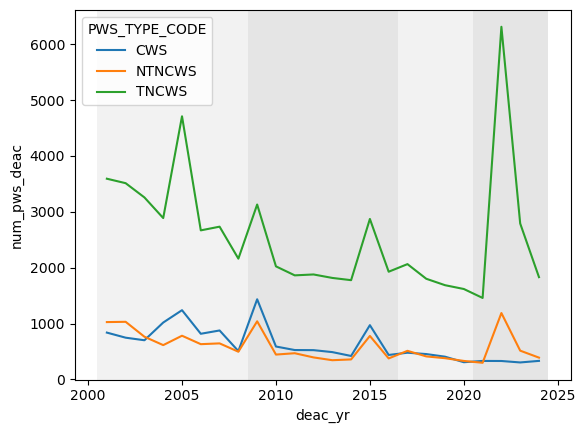

In [20]:
# get the number of pws that were deactivated each year
# by type
num_pws_deac_yr_type = sdwa_pws.groupby('PWS_TYPE_CODE', as_index=False)['PWS_DEACTIVATION_DATE'].value_counts().rename(columns={'PWS_DEACTIVATION_DATE':'deac_yr', 'count':'num_pws_deac'})
num_pws_deac_yr_type = num_pws_deac_yr_type.sort_values(by='deac_yr')

# add the spans for presidential administrations 
pres_spans()

# plot
sns.lineplot(data=num_pws_deac_yr_type, x='deac_yr', y='num_pws_deac', hue='PWS_TYPE_CODE')

In [21]:
num_pws_deac_yr_type

PWS_TYPE_CODE  deac_yr  num_pws_deac
5            CWS   2001.0           839
27        NTNCWS   2001.0          1027
50         TNCWS   2001.0          3592
26        NTNCWS   2002.0          1032
51         TNCWS   2002.0          3512
..           ...      ...           ...
56         TNCWS   2023.0          2791
34        NTNCWS   2023.0           516
19           CWS   2024.0           333
41        NTNCWS   2024.0           391
65         TNCWS   2024.0          1831

[72 rows x 3 columns]

In [22]:
# calculate the cumulative sum of deactivated systems (all types)
num_pws_deac_yr = num_pws_deac_yr_type.groupby('deac_yr').sum()['num_pws_deac']
num_pws_deac_cum = num_pws_deac_yr.sort_index(ascending=False).cumsum()

# add the cumulative sums to the number of currently active pws to back-calculate the total number of active pws per year
num_pws_yr = num_pws_deac_cum + (len(sdwa_pws[sdwa_pws['PWS_ACTIVITY_CODE'] == 'A']))
num_pws_yr = num_pws_yr.rename_axis(index={'PWS_DEACTIVATION_DATE': 'deac_yr'}).rename('num_active_pws')

In [23]:
# also need this by system type
# create a dictionary of grouped deactivation count data
num_pws_deac_yr_type = {name: group for name, group in num_pws_deac_yr_type.groupby('PWS_TYPE_CODE')}

## CWS
# calculate the cumulative sum of deactivated systems
num_cws_deac_cum = num_pws_deac_yr_type['CWS'].set_index('deac_yr').sort_index(ascending=False).cumsum().rename(columns={'num_pws_deac':'num_cws_deac'})['num_cws_deac']
# add the cumulative sums to the number of currently active pws to back-calculate the total number of active pws per year
num_cws_yr = num_cws_deac_cum + (len(sdwa_pws[(sdwa_pws['PWS_ACTIVITY_CODE'] == 'A') * (sdwa_pws['PWS_TYPE_CODE'] == 'CWS')]))
num_cws_yr = num_cws_yr.rename_axis(index={'PWS_DEACTIVATION_DATE': 'deac_yr'}).rename('num_active_cws')

## NTNCWS
# calculate the cumulative sum of deactivated systems
num_ntncws_deac_cum = num_pws_deac_yr_type['NTNCWS'].set_index('deac_yr').sort_index(ascending=False).cumsum().rename(columns={'num_pws_deac':'num_ntncws_deac'})['num_ntncws_deac']
# add the cumulative sums to the number of currently active pws to back-calculate the total number of active pws per year
num_ntncws_yr = num_ntncws_deac_cum + (len(sdwa_pws[(sdwa_pws['PWS_ACTIVITY_CODE'] == 'A') * (sdwa_pws['PWS_TYPE_CODE'] == 'NTNCWS')]))
num_ntncws_yr = num_ntncws_yr.rename_axis(index={'PWS_DEACTIVATION_DATE': 'deac_yr'}).rename('num_active_ntncws')

## TNCWS
# calculate the cumulative sum of deactivated systems
num_tncws_deac_cum = num_pws_deac_yr_type['TNCWS'].set_index('deac_yr').sort_index(ascending=False).cumsum().rename(columns={'num_pws_deac':'num_tncws_deac'})['num_tncws_deac']
# add the cumulative sums to the number of currently active pws to back-calculate the total number of active pws per year
num_tncws_yr = num_tncws_deac_cum + (len(sdwa_pws[(sdwa_pws['PWS_ACTIVITY_CODE'] == 'A') * (sdwa_pws['PWS_TYPE_CODE'] == 'TNCWS')]))
num_tncws_yr = num_tncws_yr.rename_axis(index={'PWS_DEACTIVATION_DATE': 'deac_yr'}).rename('num_active_tncws')

# combine the new series into a df
num_pws_yr = pd.DataFrame({'num_active_pws':num_pws_yr, 
                           'num_active_cws':num_cws_yr, 
                           'num_active_ntncws':num_ntncws_yr, 
                           'num_active_tncws':num_tncws_yr                           
                           })
num_pws_yr

num_active_pws  num_active_cws  num_active_ntncws  num_active_tncws
deac_yr                                                                     
2024.0           145044           49471              17332             78241
2023.0           148656           49776              17848             81032
2022.0           156486           50107              19037             87342
2021.0           158576           50439              19336             88801
2020.0           160836           50748              19668             90420
2019.0           163312           51156              20049             92107
2018.0           165982           51611              20462             93909
2017.0           169038           52090              20975             95973
2016.0           171782           52529              21352             97901
2015.0           176405           53501              22131            100773
2014.0           178962           53922              22490            102550
2013.0           181614           54412              22835            104367
2012.0           184413           54937              23230            106246
2011.0           187273           55464              23700            108109
2010.0           190333           56054              24146            110133
2009.0           195939           57489              25187            113263
2008.0           199106           57997              25684            115425
2007.0           203363           58874              26330            118159
2006.0           207481           59692              26962            120827
2005.0           214213           60932              27745            125536
2004.0           218735           61951              28360            128424
2003.0           223459           62653              29125            131681
2002.0           228751           63401              30157            135193
2001.0           234209           64240              31184            138785

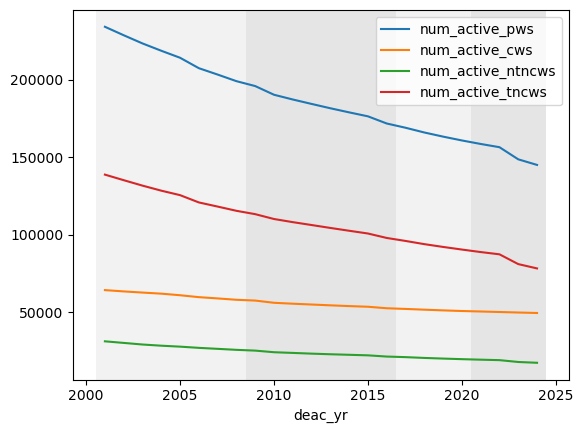

In [24]:
# plot number of pws deactivated by year
num_pws_yr.plot()
# add the spans for presidential administrations 
pres_spans()

# Load and Prep Violations Data

This section imports violations data (select columns), cleans up date fields, maps field codes, cleans up the state code field

In [25]:
# Load Violations data into notebook
# File is too large to load in entirety so only load selected columns
path = r"C:\Users\jenni\Workspaces\Projects\edgi\soe_report\data\sdwa\SDWA_latest_downloads\SDWA_VIOLATIONS_ENFORCEMENT.csv"
sdwa_viols = pd.read_csv(path,
                         usecols=['PWSID', 
                                  'VIOLATION_ID', 
                                  'VIOLATION_CODE',
                                  'VIOLATION_CATEGORY_CODE', 
                                  'IS_HEALTH_BASED_IND',
                                  'CONTAMINANT_CODE', 
                                  'RULE_CODE',
                                  'NON_COMPL_PER_BEGIN_DATE', 
                                  'NON_COMPL_PER_END_DATE',
                                  'VIOL_FIRST_REPORTED_DATE', 
                                  'ENFORCEMENT_ID',
                                  'ENFORCEMENT_DATE', 
                                  'ENFORCEMENT_ACTION_TYPE_CODE',
                                  'ENF_ACTION_CATEGORY', 
                                  'ENF_ORIGINATOR_CODE',
                                  'VIOLATION_STATUS'
                                 ],
                         parse_dates=['NON_COMPL_PER_BEGIN_DATE', 
                                      'NON_COMPL_PER_END_DATE', 
                                      'VIOL_FIRST_REPORTED_DATE', 
                                      'ENFORCEMENT_DATE'
                                     ],
                         low_memory=False
                        )
print("There are",len(sdwa_viols),"in the dataset.")

There are 14908621 in the dataset.


## This section fixes some typing problems and data entry anomalies in the date fields

In [26]:
# Check date fields for null values
print("Number of records with Null NON_COMPL_PER_BEGIN_DATE = " + str(len(sdwa_viols[sdwa_viols['NON_COMPL_PER_BEGIN_DATE'].isna()]==True)))
print("Number of records with Null NON_COMPL_PER_END_DATE = " + str(len(sdwa_viols[sdwa_viols['NON_COMPL_PER_END_DATE'].isna()]==True)))
print("Number of records with Null VIOL_FIRST_REPORTED_DATE = " + str(len(sdwa_viols[sdwa_viols['VIOL_FIRST_REPORTED_DATE'].isna()]==True)))
print("Number of records with Null ENFORCEMENT_DATE = " + str(len(sdwa_viols[sdwa_viols['ENFORCEMENT_DATE'].isna()]==True)))

Number of records with Null NON_COMPL_PER_BEGIN_DATE = 986459
Number of records with Null NON_COMPL_PER_END_DATE = 986459
Number of records with Null VIOL_FIRST_REPORTED_DATE = 986468
Number of records with Null ENFORCEMENT_DATE = 498147


In [27]:
# Check date field formats
print(type(sdwa_viols['NON_COMPL_PER_END_DATE'].loc[1]))
print(type(sdwa_viols['NON_COMPL_PER_BEGIN_DATE'].loc[1]))
print(type(sdwa_viols['VIOL_FIRST_REPORTED_DATE'].loc[1]))
print(type(sdwa_viols['ENFORCEMENT_DATE'].loc[1]))

<class 'str'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [28]:
# NON_COMPL_PER_END_DATE did not convert to timestamp
# why? some rows contain arrows; what do these mean?!?
sdwa_viols[sdwa_viols['NON_COMPL_PER_END_DATE']=='--->'].head()

PWSID VIOLATION_ID NON_COMPL_PER_BEGIN_DATE NON_COMPL_PER_END_DATE  \
278  055294101      1010481               2024-01-17                   --->   
282  055294101      1010485               2024-01-11                   --->   
298  055294101      1010500               2021-12-01                   --->   
751  MS0320001      7103381               2021-10-08                   --->   
752  MS0320001      7103381               2021-10-08                   --->   

    VIOLATION_CODE VIOLATION_CATEGORY_CODE IS_HEALTH_BASED_IND  \
278             75                   Other                   N   
282             75                   Other                   N   
298             75                   Other                   N   
751             45                      TT                   Y   
752             45                      TT                   Y   

    CONTAMINANT_CODE VIOLATION_STATUS  RULE_CODE VIOL_FIRST_REPORTED_DATE  \
278             7500        Addressed      410.0               2025-06-23   
282             7500        Addressed      410.0               2025-06-23   
298             7500        Addressed      410.0               2025-06-23   
751             0700      Unaddressed      140.0               2022-04-04   
752             0700      Unaddressed      140.0               2022-04-04   

    ENFORCEMENT_ID ENFORCEMENT_DATE ENFORCEMENT_ACTION_TYPE_CODE  \
278           1795       2024-03-20                          EFL   
282           1795       2024-03-20                          EFL   
298           1795       2024-03-20                          EFL   
751             42       2021-12-27                          SFJ   
752             43       2021-12-27                          SIE   

    ENF_ACTION_CATEGORY ENF_ORIGINATOR_CODE  
278              Formal                   R  
282              Formal                   R  
298              Formal                   R  
751            Informal                   S  
752            Informal                   S

In [29]:
# could the arrows indicate open violations but are incorrectly formatted? 
# data dictionary says open violations have NON_COMPL_PER_END_DATE = null
print("Number of records with Null NON_COMPL_PER_END_DATE = " + str(len(sdwa_viols[sdwa_viols['NON_COMPL_PER_END_DATE'].isna()]==True)))

Number of records with Null NON_COMPL_PER_END_DATE = 986459


In [30]:
# when did these null (open?) violations begin?
sdwa_viols[sdwa_viols['NON_COMPL_PER_END_DATE'].isna()==True]['NON_COMPL_PER_BEGIN_DATE']

13922162   NaT
13922163   NaT
13922164   NaT
13922165   NaT
13922166   NaT
            ..
14908616   NaT
14908617   NaT
14908618   NaT
14908619   NaT
14908620   NaT
Name: NON_COMPL_PER_BEGIN_DATE, Length: 986459, dtype: datetime64[ns]

In [31]:
# violations with NON_COMPL_PER_END_DATE = null (supposed to be open violations) do not seem to have begin dates either
# check how many records have null NON_COMPL_PER_END_DATE that have a valid NON_COMPL_PER_BEGIN_DATE
sdwa_viols[(sdwa_viols['NON_COMPL_PER_END_DATE'].isna()==True) & (sdwa_viols['NON_COMPL_PER_BEGIN_DATE'].isna()==False)]

Empty DataFrame
Columns: [PWSID, VIOLATION_ID, NON_COMPL_PER_BEGIN_DATE, NON_COMPL_PER_END_DATE, VIOLATION_CODE, VIOLATION_CATEGORY_CODE, IS_HEALTH_BASED_IND, CONTAMINANT_CODE, VIOLATION_STATUS, RULE_CODE, VIOL_FIRST_REPORTED_DATE, ENFORCEMENT_ID, ENFORCEMENT_DATE, ENFORCEMENT_ACTION_TYPE_CODE, ENF_ACTION_CATEGORY, ENF_ORIGINATOR_CODE]
Index: []

In [32]:
# that's an empty dataframe
# how many records have null NON_COMPL_PER_BEGIN_DATE & how many have null NON_COMPL_PER_END_DATE?
print("Number of records with Null NON_COMPL_PER_BEGIN_DATE = " + str(len(sdwa_viols[sdwa_viols['NON_COMPL_PER_BEGIN_DATE'].isna()]==True)))
print("Number of records with Null NON_COMPL_PER_END_DATE = " + str(len(sdwa_viols[sdwa_viols['NON_COMPL_PER_END_DATE'].isna()]==True)))

Number of records with Null NON_COMPL_PER_BEGIN_DATE = 986459
Number of records with Null NON_COMPL_PER_END_DATE = 986459


In [33]:
# same exact number of records 
# seems like the data coding for open violations is incorrect; instead of null they used arrows
# when do the violations with arrow notations for NON_COMPL_PER_END_DATE occur?
sdwa_viols[sdwa_viols['NON_COMPL_PER_END_DATE'] == '--->']['NON_COMPL_PER_BEGIN_DATE']

278        2024-01-17
282        2024-01-11
298        2021-12-01
751        2021-10-08
752        2021-10-08
              ...    
13922122   2023-01-11
13922137   2024-04-11
13922143   2023-07-11
13922147   2023-10-11
13922161   2022-10-11
Name: NON_COMPL_PER_BEGIN_DATE, Length: 97316, dtype: datetime64[ns]

In [34]:
# most of the rows with arrows are pre-2024
# will assume these are open violations
# what to do about the arrow notation? need to convert this field from string to date so that i can do calculations with the NON_COMPL_PER_END_DATE field
# can't do that with the arrows there
# replace arrows with a null value
sdwa_viols['NON_COMPL_PER_END_DATE'] = sdwa_viols['NON_COMPL_PER_END_DATE'].replace('--->',pd.NaT)

In [35]:
# now how many records with NON_COMPL_PER_END_DATE null?
print("Number of records with Null NON_COMPL_PER_END_DATE = " + str(len(sdwa_viols[sdwa_viols['NON_COMPL_PER_END_DATE'].isna()]==True)))

Number of records with Null NON_COMPL_PER_END_DATE = 1083775


In [36]:
# how many records have null NON_COMPL_PER_END_DATE & also null NON_COMPL_PER_BEGIN_DATE?
print(len(sdwa_viols[(sdwa_viols['NON_COMPL_PER_END_DATE'].isna()==True) & (sdwa_viols['NON_COMPL_PER_BEGIN_DATE'].isna()==True)]))

986459


In [37]:
# i've replaced the open violation arrow notation with a null value for those records with a valid NON_COMPL_PER_BEGIN_DATE
# still have 986,459 records missing non-compliance date data
# can't address those

In [38]:
# convert NON_COMPL_PER_END_DATE to datetime 
sdwa_viols['NON_COMPL_PER_END_DATE'] = pd.to_datetime(sdwa_viols['NON_COMPL_PER_END_DATE'], format='mixed')
print(type(sdwa_viols['NON_COMPL_PER_END_DATE'].loc[1]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [39]:
# Now it is possible to filter with and calculate dates (more) accurately

In [40]:
# Filter violations to those occurring from 2001-2024
sdwa_viols = sdwa_viols[(sdwa_viols['NON_COMPL_PER_BEGIN_DATE']>'12-31-2000') & (sdwa_viols['NON_COMPL_PER_BEGIN_DATE']<'01-01-2025')]
print("There are",(len(sdwa_viols)),"violations from 2001-2024")

There are 10405287 violations from 2001-2024


# Merge violations data with PWS list 

In [41]:
# Merge violations data with PWS list 
pws_viols = sdwa_viols.merge(sdwa_pws, left_on='PWSID', right_on='PWSID')

In [42]:
# check the size of this dataset
print("There are",(len(pws_viols)),"violations from 2001-2024")

There are 10264944 violations from 2001-2024


In [43]:
# create a column in the df to store just the year of the non compliance begin date
pws_viols['viol_yr'] = pws_viols['NON_COMPL_PER_BEGIN_DATE'].dt.year 

## Check inactive systems data

In [44]:
# can a violation occur for a system past its inactive date?
# look at violation dates by deactivation dates
#pd.options.display.max_rows = 600
pws_viols[['PWS_DEACTIVATION_DATE','viol_yr']].value_counts().sort_index(ascending=True)

PWS_DEACTIVATION_DATE  viol_yr
2001.0                 2001        5200
                       2002         604
                       2003         234
                       2004         330
                       2005         134
                                  ...  
2024.0                 2020        7185
                       2021        6866
                       2022        9355
                       2023       13719
                       2024        6660
Name: count, Length: 572, dtype: int64

In [45]:
# yes we can see that violations are being logged as beginning after pws are deactivated
# how many?
print("There are",len(pws_viols[(pws_viols['PWS_DEACTIVATION_DATE'] < pws_viols['viol_yr'])]),"violations logged after system deactivation.")

There are 22991 violations logged after system deactivation.


In [46]:
# this is not a lot of records compared to the total dataset size
# these might be important violations, but they might be errors
# drop these rows: better to be conservative and underestimate violations
pws_viols = pws_viols[~(pws_viols['PWS_DEACTIVATION_DATE'] < pws_viols['viol_yr'])]

In [47]:
# check the size of this dataset
print("There are",(len(pws_viols)),"violations from 2001-2024")

There are 10241953 violations from 2001-2024


In [48]:
print("These were reported for",len(pws_viols['PWSID'].unique()),"PWS")

These were reported for 169533 PWS


## Calculate duration of noncompliance

!!! remember: open violations have duration value null 

In [49]:
# create a column in the df to store the duration of noncompliance using the non-compliance begin/end fields
pws_viols['non_compl_duration'] = pws_viols['NON_COMPL_PER_END_DATE'] - pws_viols['NON_COMPL_PER_BEGIN_DATE']

In [50]:
# some of these are negative because some of the violations have noncompliance end dates earlier than begin dates
pws_viols[pws_viols['NON_COMPL_PER_END_DATE'] < pws_viols['NON_COMPL_PER_BEGIN_DATE']]

PWSID VIOLATION_ID NON_COMPL_PER_BEGIN_DATE  \
434       FL6531527  20170009679               2017-07-01   
1578      AK2360010      3207516               2013-11-01   
1579      AK2360010      3207517               2013-10-16   
2422      MS0200018           11               2023-01-01   
2423      MS0200018           11               2023-01-01   
...             ...          ...                      ...   
10263298  WV9931030      5009941               2021-12-16   
10263955  PA2350515      1933708               2019-09-01   
10264275  AK2121496        11406               2006-05-01   
10264865  WV3303603         1V02               2002-07-01   
10264901  CT0181184         1051               2022-08-13   

         NON_COMPL_PER_END_DATE VIOLATION_CODE VIOLATION_CATEGORY_CODE  \
434                  2017-06-30             72                   Other   
1578                 2013-09-30             45                      TT   
1579                 2013-09-30             45                      TT   
2422                 2021-04-21             03                      MR   
2423                 2021-04-21             03                      MR   
...                         ...            ...                     ...   
10263298             2021-04-12             75                   Other   
10263955             2019-08-19             4F                     RPT   
10264275             2006-02-06             23                      MR   
10264865             2002-03-01             71                   Other   
10264901             2022-01-11             75                   Other   

         IS_HEALTH_BASED_IND CONTAMINANT_CODE VIOLATION_STATUS  RULE_CODE  \
434                        N             7000         Resolved      420.0   
1578                       Y             0700         Resolved      140.0   
1579                       Y             0700         Resolved      140.0   
2422                       N             1040         Resolved      331.0   
2423                       N             1040         Resolved      331.0   
...                      ...              ...              ...        ...   
10263298                   N             7500         Resolved      410.0   
10263955                   N             8000         Archived      111.0   
10264275                   N             3100         Archived      110.0   
10264865                   N             7000         Archived      420.0   
10264901                   N             7500         Archived      410.0   

          ... SOURCE_WATER_PROTECTION_CODE SOURCE_PROTECTION_BEGIN_DATE  \
434       ...                          NaN                          NaN   
1578      ...                            N                          NaN   
1579      ...                            N                          NaN   
2422      ...                          NaN                          NaN   
2423      ...                          NaN                          NaN   
...       ...                          ...                          ...   
10263298  ...                            N                          NaN   
10263955  ...                          NaN                          NaN   
10264275  ...                            N                          NaN   
10264865  ...                            N                          NaN   
10264901  ...                            N                          NaN   

         OUTSTANDING_PERFORMER OUTSTANDING_PERFORM_BEGIN_DATE  \
434                        NaN                            NaN   
1578                       NaN                            NaN   
1579                       NaN                            NaN   
2422                       NaN                            NaN   
2423                       NaN                            NaN   
...                        ...                            ...   
10263298                   NaN                            NaN   
10263955                   NaN                

## Map the field descriptions for data codes using the data dictionary

In [51]:
# Read ref codes dictionary
path = r"C:\Users\jenni\Workspaces\Projects\edgi\soe_report\data\sdwa\SDWA_latest_downloads\SDWA_REF_CODE_VALUES.csv"
sdwa_ref_codes = pd.read_csv(path)

# violation codes
violations = sdwa_ref_codes.loc[sdwa_ref_codes["VALUE_TYPE"]=='VIOLATION_CODE'].set_index("VALUE_CODE")[["VALUE_DESCRIPTION"]].to_dict()["VALUE_DESCRIPTION"]
pws_viols['VIOLATION_CODE'] = pws_viols['VIOLATION_CODE'].astype(str).map(violations)

# violation category codes
violation_categories = sdwa_ref_codes.loc[sdwa_ref_codes["VALUE_TYPE"]=='VIOLATION_CATEGORY_CODE'].set_index("VALUE_CODE")[["VALUE_DESCRIPTION"]].to_dict()["VALUE_DESCRIPTION"]
pws_viols['VIOLATION_CATEGORY_CODE'] = pws_viols['VIOLATION_CATEGORY_CODE'].astype(str).map(violation_categories)

# rule codes
rules = sdwa_ref_codes.loc[sdwa_ref_codes["VALUE_TYPE"]=='RULE_CODE'].set_index("VALUE_CODE")[["VALUE_DESCRIPTION"]].to_dict()["VALUE_DESCRIPTION"]
pws_viols['RULE_CODE'] = pws_viols['RULE_CODE'].astype(int).astype(str).map(rules) # some of these imported as floats so have to convert to int then string to avoid losing data

# contaminant codes
# note: There are no NaNs in the contaminant codes field in the imported data but after mapping there are 47 NaNs
contaminants = sdwa_ref_codes.loc[sdwa_ref_codes["VALUE_TYPE"]=='CONTAMINANT_CODE'].set_index("VALUE_CODE")[["VALUE_DESCRIPTION"]].to_dict()["VALUE_DESCRIPTION"]
pws_viols['CONTAMINANT_CODE'] = pws_viols['CONTAMINANT_CODE'].dropna().astype(str).map(contaminants) # some of these imported as floats so have to convert to int then string to avoid losing data

# enforcement action type codes
enforcement_action_types = sdwa_ref_codes.loc[sdwa_ref_codes["VALUE_TYPE"]=='ENFORCEMENT_ACTION_TYPE_CODE'].set_index("VALUE_CODE")[["VALUE_DESCRIPTION"]].to_dict()["VALUE_DESCRIPTION"]
pws_viols['ENFORCEMENT_ACTION_TYPE_CODE'] = pws_viols['ENFORCEMENT_ACTION_TYPE_CODE'].astype(str).map(enforcement_action_types)

## Create a health-based violations df

In [52]:
# create df of health viols only
pws_viols_health = pws_viols[pws_viols['IS_HEALTH_BASED_IND']=='Y']

In [53]:
# create a series of the number of health violations per year, for later use
num_viols_health = pws_viols_health.groupby(['viol_yr']).count().rename(columns={'VIOLATION_ID':'num_viols_tot_yr'})['num_viols_tot_yr']

# Violations Data Analysis

In [54]:
print("The dataset includes",len(pws_viols),"violations at",len(pws_viols['PWSID'].unique()),"water systems")
print("The average number of violations per year is",int((len(pws_viols) / 24)))
print("\n")
print("The dataset includes",len(pws_viols_health),"health-based violations at",len(pws_viols_health['PWSID'].unique()),"water systems")
print("The average number of health_based violations per year is",int((len(pws_viols_health) / 24)))

The dataset includes 10241953 violations at 169533 water systems
The average number of violations per year is 426748


The dataset includes 1463853 health-based violations at 85160 water systems
The average number of health_based violations per year is 60993


## Number of violations per year

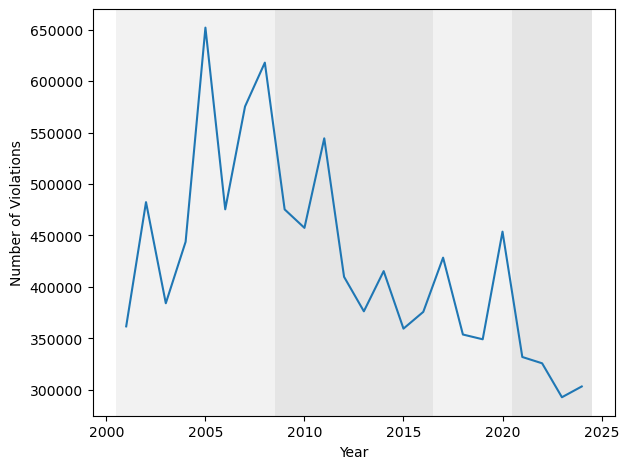

In [55]:
# make a plot of violations by year
sns.lineplot(data=pws_viols.groupby(['viol_yr']).count(), x='viol_yr', y='VIOLATION_ID')

# add the spans for presidential administrations 
pres_spans()

plt.tight_layout()
plt.ylabel('Number of Violations')
plt.xlabel('Year')
plt.savefig('num_viols_by_year_all_sys.png')

## Type of violations by year

In [56]:
# group violations by type and year
pws_viols_type = pws_viols.groupby(['viol_yr', 'VIOLATION_CATEGORY_CODE'], as_index=False)[['VIOLATION_ID']].count()
pws_viols_type

viol_yr              VIOLATION_CATEGORY_CODE  VIOLATION_ID
0       2001  Maximum Contaminant Level Violation         40380
1       2001             Monitoring and Reporting        298823
2       2001                      Other Violation         16686
3       2001        Treatment Technique Violation          5578
4       2002  Maximum Contaminant Level Violation         43361
..       ...                                  ...           ...
134     2024                 Monitoring Violation         64068
135     2024             Monitoring and Reporting        149560
136     2024                      Other Violation         31366
137     2024                  Reporting Violation         17005
138     2024        Treatment Technique Violation         22162

[139 rows x 3 columns]

In [57]:
# make an array of the violation types
viol_types = pws_viols_type['VIOLATION_CATEGORY_CODE'].unique()
viol_types

array(['Maximum Contaminant Level Violation', 'Monitoring and Reporting',
       'Other Violation', 'Treatment Technique Violation',
       'Maximum Residual Disinfectant Level', 'Monitoring Violation',
       'Reporting Violation'], dtype=object)

In [58]:
# there are 7 violation types but they aren't consistent over the years
# create a dictionary of violation categories with values over the years
viol_counts = dict()
for viol_type in viol_types:
    array = np.array(pws_viols_type[pws_viols_type['VIOLATION_CATEGORY_CODE'] == viol_type]['VIOLATION_ID'])
    viol_counts.update({viol_type: array})
viol_counts

{'Maximum Contaminant Level Violation': array([40380, 43361, 47896, 56233, 72403, 74870, 76027, 75540, 72618,
        69773, 66839, 62217, 61545, 60526, 64319, 40728, 35206, 33816,
        32831, 28384, 25795, 23723, 22046, 18803]),
 'Monitoring and Reporting': array([298823, 407627, 293998, 346431, 536181, 361441, 455230, 500169,
        362196, 345695, 436843, 303497, 276735, 314198, 251012, 204810,
        255873, 188067, 190378, 304980, 183988, 182646, 151074, 149560]),
 'Other Violation': array([16686, 26033, 36237, 34237, 34458, 29818, 36443, 36209, 34980,
        35532, 33932, 36759, 30337, 32132, 32583, 40873, 33528, 29517,
        28651, 29178, 28221, 28159, 31221, 31366]),
 'Treatment Technique Violation': array([ 5578,  5293,  5810,  6775,  8915,  9179,  7621,  6035,  5398,
         6233,  6732,  7171,  7485,  8315, 10348, 16718, 16802, 17650,
        16969, 13283, 15282, 15687, 15290, 22162]),
 'Maximum Residual Disinfectant Level': array([  4,   3,  62,  90,  11,   6,  38,

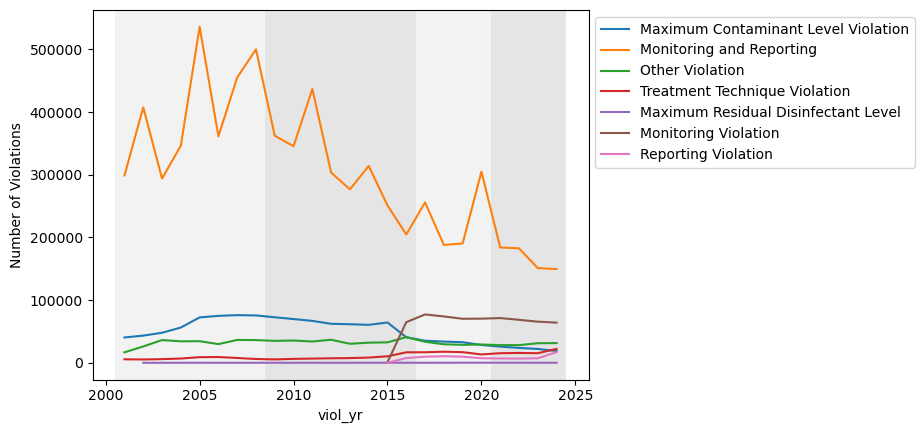

In [59]:
# take a look at the change over time
sns.lineplot(data=pws_viols_type, x='viol_yr', y='VIOLATION_ID', hue='VIOLATION_CATEGORY_CODE')
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.ylabel('Number of Violations')
# add the spans for presidential administrations 
pres_spans()

In [60]:
# maximum residual disinfectant level appears in 2002 and is consistently negligibly low
# in 2015 monitoring and reporting violation categories appear
# the monitoring category is a relatively low but non-negligible number
# lump these 2 categories with the M&R category

# map the new category values
# use a copy of the pws_viols df because I'm about to drop data and also not sure the significance of the M&R coding
pws_viols_copy = pws_viols.copy(deep=True) # this is a deep copy
pws_viols_copy = pws_viols_copy.replace(['Monitoring Violation','Reporting Violation'],['Monitoring and Reporting','Monitoring and Reporting'])
viol_types = pws_viols_copy['VIOLATION_CATEGORY_CODE'].unique()
viol_types

array(['Monitoring and Reporting', 'Treatment Technique Violation',
       'Maximum Contaminant Level Violation', 'Other Violation',
       'Maximum Residual Disinfectant Level'], dtype=object)

In [61]:
# regroup violations by type and year
pws_viols_type = pws_viols_copy.groupby(['viol_yr', 'VIOLATION_CATEGORY_CODE'], as_index=False)[['VIOLATION_ID']].count()

In [62]:
# new dictionary of violation counts
viol_counts = dict()
for viol_type in viol_types:
    array = np.array(pws_viols_type[pws_viols_type['VIOLATION_CATEGORY_CODE'] == viol_type]['VIOLATION_ID'])
    viol_counts.update({viol_type: array})
viol_counts

{'Monitoring and Reporting': array([298823, 407627, 293998, 346431, 536181, 361441, 455230, 500169,
        362196, 345695, 436843, 303497, 276735, 314198, 251938, 277157,
        342735, 272486, 270330, 382620, 262241, 257888, 223918, 230633]),
 'Treatment Technique Violation': array([ 5578,  5293,  5810,  6775,  8915,  9179,  7621,  6035,  5398,
         6233,  6732,  7171,  7485,  8315, 10348, 16718, 16802, 17650,
        16969, 13283, 15282, 15687, 15290, 22162]),
 'Maximum Contaminant Level Violation': array([40380, 43361, 47896, 56233, 72403, 74870, 76027, 75540, 72618,
        69773, 66839, 62217, 61545, 60526, 64319, 40728, 35206, 33816,
        32831, 28384, 25795, 23723, 22046, 18803]),
 'Other Violation': array([16686, 26033, 36237, 34237, 34458, 29818, 36443, 36209, 34980,
        35532, 33932, 36759, 30337, 32132, 32583, 40873, 33528, 29517,
        28651, 29178, 28221, 28159, 31221, 31366]),
 'Maximum Residual Disinfectant Level': array([  4,   3,  62,  90,  11,   6,  38,

In [63]:
# compare array lengths to make sure they are all equal
print('Maximum Contaminant Level Violation',len(viol_counts['Maximum Contaminant Level Violation']))
print('Other Violation',len(viol_counts['Other Violation']))
print('Monitoring and Reporting',len(viol_counts['Monitoring and Reporting']))
print('Treatment Technique Violation',len(viol_counts['Treatment Technique Violation']))
print('Maximum Residual Disinfectant Level',len(viol_counts['Maximum Residual Disinfectant Level']))

Maximum Contaminant Level Violation 24
Other Violation 24
Monitoring and Reporting 24
Treatment Technique Violation 24
Maximum Residual Disinfectant Level 23


In [64]:
# Maximum Residual Disinfectant Level violation count was zero in 2001
# need to add a zero value at the beginning of the array 
counts = list(viol_counts['Maximum Residual Disinfectant Level'])
counts.insert(0,0)
np.array(counts)
viol_counts['Maximum Residual Disinfectant Level'] = counts
print('Maximum Residual Disinfectant Level',len(viol_counts['Maximum Residual Disinfectant Level']))

Maximum Residual Disinfectant Level 24


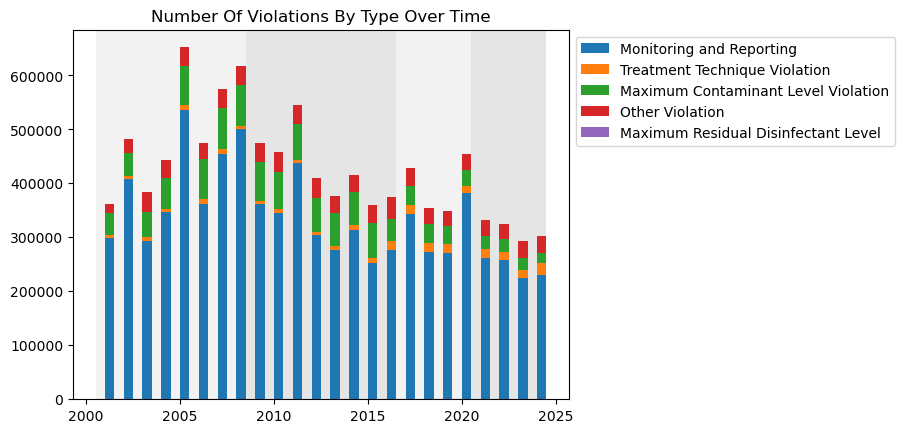

In [65]:
# plot the data
years = np.array(range(2001,2025))

width = 0.5
fig, ax = plt.subplots()
bottom = np.zeros(len(years))

for viol_type, viol_count in viol_counts.items():
    p = ax.bar(years, viol_count, width, label=viol_type, bottom=bottom, align='edge', zorder=1)
    bottom += viol_count

ax.set_title("Number Of Violations By Type Over Time")
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

# add the spans for presidential administrations 
pres_spans()

plt.savefig('num_viols_type_all_sys.png', bbox_inches='tight')
plt.show()

## Percentage of violations that were health-based by year

In [66]:
# create a df of percentage health-based 
per_health_based = pd.DataFrame((pws_viols.groupby(['viol_yr', 'IS_HEALTH_BASED_IND'])[['VIOLATION_ID']].count()['VIOLATION_ID'][:,'Y'] / (pws_viols.groupby(['viol_yr', 'IS_HEALTH_BASED_IND'])[['VIOLATION_ID']].count()['VIOLATION_ID'][:,'Y']+pws_viols.groupby(['viol_yr', 'IS_HEALTH_BASED_IND'])[['VIOLATION_ID']].count()['VIOLATION_ID'][:,'N'])) * 100)

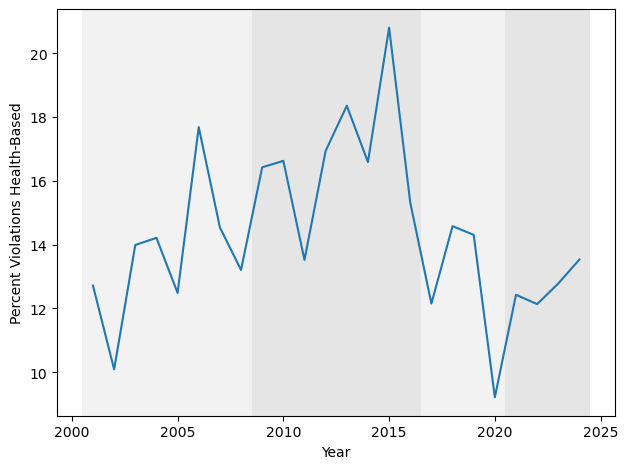

In [67]:
# plot
sns.lineplot(data=per_health_based, x='viol_yr', y='VIOLATION_ID')

# add the spans for presidential administrations 
pres_spans()

plt.tight_layout()
plt.ylabel('Percent Violations Health-Based')
plt.xlabel('Year')
plt.savefig('per_viols_health_by_year_all_sys.png')

## Number of health-based violations by category by year

In [68]:
health_cat = pws_viols_health.groupby(['viol_yr', 'VIOLATION_CATEGORY_CODE'], as_index=False).count()

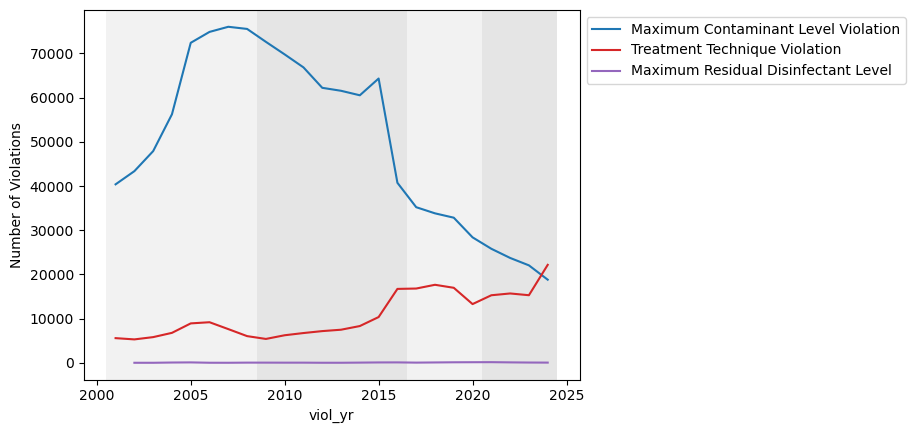

In [69]:
# make a plot of violation categories by year
sns.lineplot(data=health_cat, x='viol_yr', y='VIOLATION_ID', hue='VIOLATION_CATEGORY_CODE', palette=['tab:blue','tab:red','tab:purple'])

# add the spans for presidential administrations 
pres_spans()

plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.ylabel('Number of Violations')
plt.savefig('num_health_viols_by_cat_all_sys.png', bbox_inches='tight')

## Number of health-based violations by year

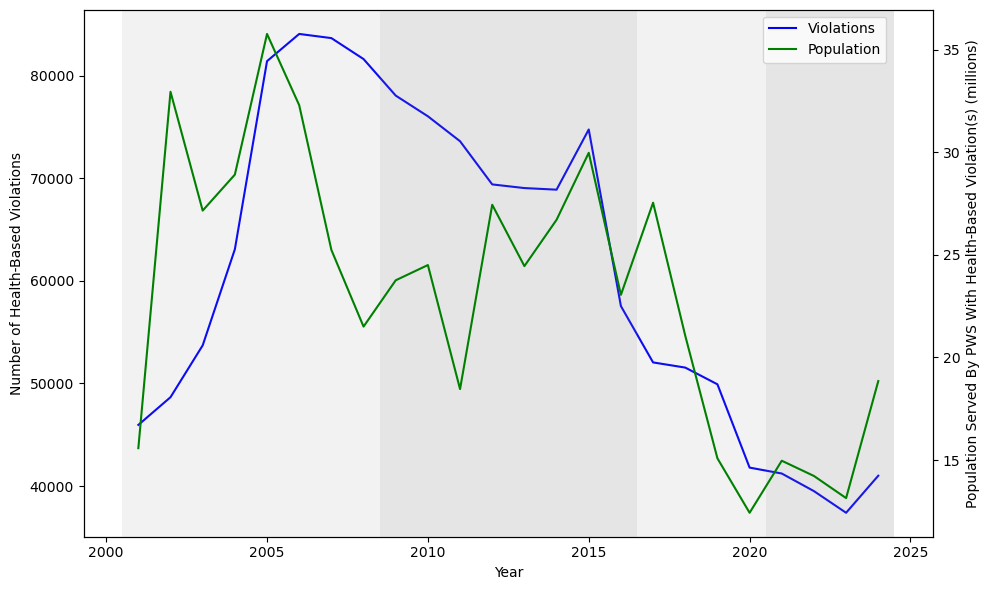

In [70]:
# how many people are affected by health-based violations?
viols_health_pop = pws_viols_health.groupby(['viol_yr','PWSID'], as_index=False).count()[['viol_yr','PWSID']]
viols_health_pop = viols_health_pop.merge(sdwa_pws, on=['PWSID'])[['viol_yr','PWSID','POPULATION_SERVED_COUNT']]
viols_health_pop = viols_health_pop.groupby(['viol_yr'], as_index=False).sum()[['viol_yr','POPULATION_SERVED_COUNT']]

# plot population affected by health-based violations per year 
fig, ax1 = plt.subplots(figsize=(10,6))
sns.lineplot(data=pws_viols_health.groupby(['viol_yr']).count(), x='viol_yr', y='VIOLATION_ID', ax=ax1, color='blue')
ax1.set_ylabel('Number of Health-Based Violations')
ax1.set_xlabel('Year')

ax2 = ax1.twinx()
sns.lineplot(data=viols_health_pop, x='viol_yr', y='POPULATION_SERVED_COUNT', ax=ax2, color='green')
ax2.set_ylabel('Population Served')
def ticklabel(x, pos):
    return f'{x/1000000:g}'
ax2.yaxis.set_major_formatter(FuncFormatter(ticklabel))

# add the spans for presidential administrations 
pres_spans()

plt.tight_layout()
plt.ylabel('Population Served By PWS With Health-Based Violation(s) (millions)')
plt.legend(handles=[Line2D([], [], color='blue', label='Violations'), Line2D([], [], color='green', label='Population')], loc=(0.8,0.9))
plt.savefig('pop_served_h_viol_all_sys.png')

## Number of health-based violations by rule by year

In [71]:
# create a df of the number of violations by rule by year
health_rule = pws_viols_health.groupby(['viol_yr', 'RULE_CODE'], as_index=False).count().rename(columns={'VIOLATION_ID':'num_viols_rule'})[['viol_yr','RULE_CODE','num_viols_rule']]
# take a look at the rules
health_rule['RULE_CODE'].unique()

array(['Arsenic Rule', 'Former Total Trihalomethane Rule',
       'Inorganic Chemicals',
       'Interim and Long Term 1 Enhanced Surface Water Treatment Rule',
       'Lead and Copper Rule', 'Nitrate Rule',
       'Radionuclides and Revised Rad Rule',
       'Surface Water Treatment Rule', 'Synthetic Organic Chemicals',
       'Total Coliform Rule', 'Volatile Organic Chemicals',
       'Stage 1 Disinfectants and Disinfection Byproducts Rule',
       'Long Term 2 Enhanced Surface Water Treatment Rule',
       'Ground Water Rule',
       'Stage 2 Disinfectants and Disinfection Byproducts Rule',
       'Lead and Copper Rule Revisions', 'Revised Total Coliform Rule'],
      dtype=object)

In [72]:
# look at top 5 rules by violation count by year
# define a function to return top 5 violation counts
def year_top(df, n=5, column='num_viols_rule'):
  return df.sort_values(column, ascending=False)[:n]

# group by year and apply this function
health_rule_top = health_rule.groupby('viol_yr').apply(year_top, include_groups=False)[['RULE_CODE','num_viols_rule']]
# look at the number of years each rule was in the top 5
health_rule_top['RULE_CODE'].value_counts()

RULE_CODE
Radionuclides and Revised Rad Rule                        21
Nitrate Rule                                              19
Arsenic Rule                                              17
Total Coliform Rule                                       15
Stage 2 Disinfectants and Disinfection Byproducts Rule    11
Stage 1 Disinfectants and Disinfection Byproducts Rule    11
Revised Total Coliform Rule                                9
Ground Water Rule                                          9
Surface Water Treatment Rule                               5
Inorganic Chemicals                                        1
Lead and Copper Rule                                       1
Lead and Copper Rule Revisions                             1
Name: count, dtype: int64

In [73]:
# grid plot of health-based violation counts by rule over time
health_rule_reformat = (health_rule.pivot(index='RULE_CODE', columns='viol_yr', values='num_viols_rule'))

# calculate values as a percentage
for year in range(2001,2025):
    health_rule_reformat[year] = (health_rule_reformat[year] / num_viols_health[year]) * 100

In [74]:
# check the percentages add up to 100?
health_rule_reformat.sum()

viol_yr
2001    100.0
2002    100.0
2003    100.0
2004    100.0
2005    100.0
2006    100.0
2007    100.0
2008    100.0
2009    100.0
2010    100.0
2011    100.0
2012    100.0
2013    100.0
2014    100.0
2015    100.0
2016    100.0
2017    100.0
2018    100.0
2019    100.0
2020    100.0
2021    100.0
2022    100.0
2023    100.0
2024    100.0
dtype: float64

In [75]:
# export results
health_rule_reformat.to_csv('health_rule_top_all_sys.csv')

In [76]:
# reorder index so rules with phases/stages are grouped side by side
health_rule_reformat = health_rule_reformat.reindex(['Arsenic Rule', 
                                                     'Former Total Trihalomethane Rule', 
                                                     'Stage 1 Disinfectants and Disinfection Byproducts Rule',
                                                     'Stage 2 Disinfectants and Disinfection Byproducts Rule',
                                                     'Ground Water Rule',
                                                     'Inorganic Chemicals',
                                                     'Lead and Copper Rule',
                                                     'Lead and Copper Rule Revisions',
                                                     'Nitrate Rule',
                                                     'Radionuclides and Revised Rad Rule', 
                                                     'Surface Water Treatment Rule',
                                                     'Interim and Long Term 1 Enhanced Surface Water Treatment Rule',
                                                     'Long Term 2 Enhanced Surface Water Treatment Rule',  
                                                     'Synthetic Organic Chemicals',
                                                     'Total Coliform Rule', 
                                                     'Revised Total Coliform Rule', 
                                                     'Volatile Organic Chemicals'])

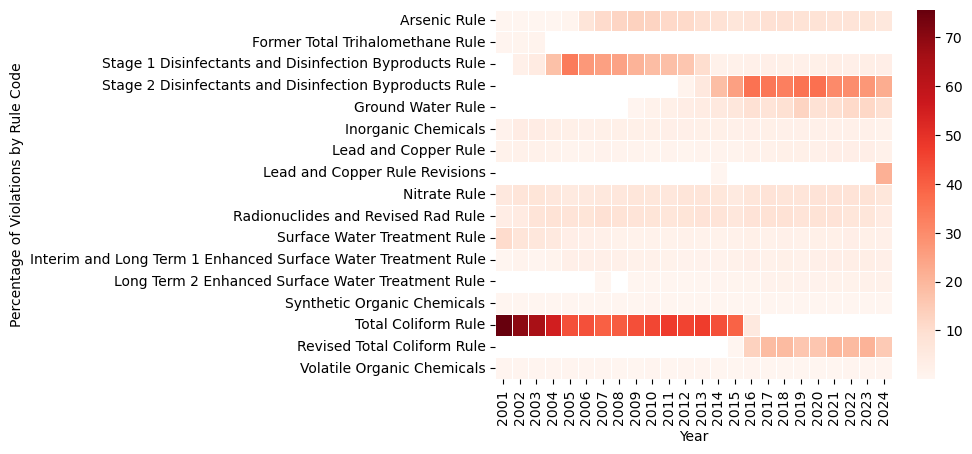

In [77]:
# grid plot of percentage of violations by rule code by year
sns.heatmap(health_rule_reformat, linewidth=.5, cmap='Reds')
plt.ylabel('Percentage of Violations by Rule Code')
plt.xlabel('Year')
plt.savefig('per_health_viols_by_rule.png', bbox_inches='tight')

# Enforcement Analysis

## Enforcement action types

In [79]:
# number of enforcement actions by type for all violation types
viols_enf_type = pws_viols.groupby(['viol_yr', 'ENFORCEMENT_ACTION_TYPE_CODE'], as_index=False).count()[['viol_yr', 'ENFORCEMENT_ACTION_TYPE_CODE','VIOLATION_ID',]].rename(columns={'VIOLATION_ID':'num_enfs_type'})
viols_enf_type

viol_yr                       ENFORCEMENT_ACTION_TYPE_CODE  \
0        2001      Federal Bilateral Compliance Agreement signed   
1        2001                           Federal Civil Case filed   
2        2001  Federal Complaint for Penalty Consent Order or...   
3        2001               Federal Complaint for Penalty issued   
4        2001               Federal Compliance Meeting conducted   
...       ...                                                ...   
1106     2024                                   State Unresolved   
1107     2024                    State Variance/Exemption issued   
1108     2024                    State Violation/Reminder Notice   
1109     2024           State no additional Formal Action needed   
1110     2024                    State no longer subject to Rule   

      num_enfs_type  
0                47  
1                32  
2                 7  
3               244  
4                 2  
...             ...  
1106              3  
1107             19  
1108          71109  
1109           1758  
1110            313  

[1111 rows x 3 columns]

Text(50.722222222222186, 0.5, 'Enforcement Action Type')

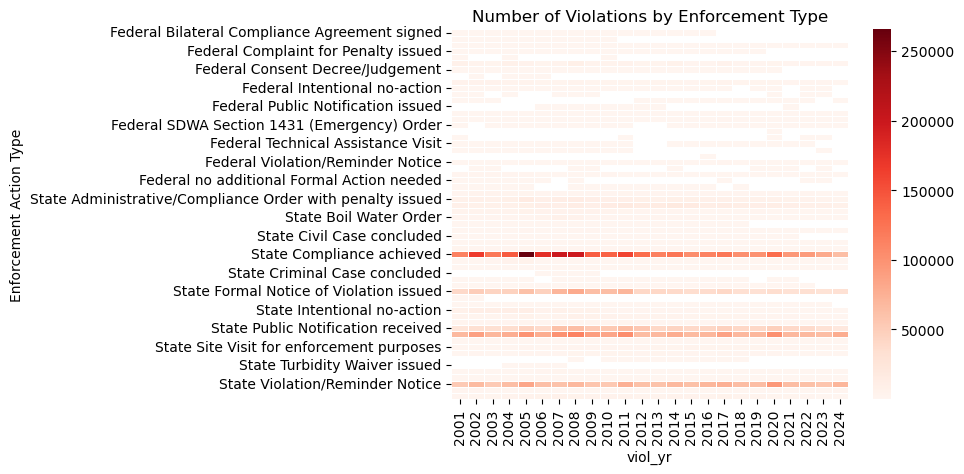

In [80]:
# plot using a heatmap
viols_enf_type_reformat = (viols_enf_type.pivot(index='ENFORCEMENT_ACTION_TYPE_CODE', columns='viol_yr', values='num_enfs_type'))
sns.heatmap(viols_enf_type_reformat, linewidth=.5, cmap='Reds')
plt.title('Number of Violations by Enforcement Type')
plt.ylabel('Enforcement Action Type')

In [81]:
# most of the enforcement actions are only a few types
# narrow down to most common over the years

In [82]:
# filter the dataset for the top 10 action types from 2001-2024
# group the original viols df by enforcement type over all years
viols_enf_type_top10 = pws_viols.groupby(['ENFORCEMENT_ACTION_TYPE_CODE'], as_index=False).count()[['ENFORCEMENT_ACTION_TYPE_CODE','VIOLATION_ID']]
# list of the top 10 types
viols_enf_type_top10_vals = list(viols_enf_type_top10.sort_values(by='VIOLATION_ID',ascending=False).head(10)['ENFORCEMENT_ACTION_TYPE_CODE'])
viols_enf_type_top10_vals

['State Compliance achieved',
 'State Public Notification requested',
 'State Violation/Reminder Notice',
 'State Formal Notice of Violation issued',
 'State Public Notification received',
 'State Administrative/Compliance Order without penalty issued',
 'State Administrative/Compliance Order with penalty issued',
 'State Intentional no-action',
 'State no longer subject to Rule',
 'Federal Compliance achieved']

In [83]:
# most enforcements are resolved by states

In [84]:
# create a new viols df by filtering for only the top 10 enforcement types
viols_enf_type_top10 = pws_viols[pws_viols['ENFORCEMENT_ACTION_TYPE_CODE'].isin(viols_enf_type_top10_vals)]
# group this new df by year 
viols_enf_type_top10 = viols_enf_type_top10.groupby(['viol_yr', 'ENFORCEMENT_ACTION_TYPE_CODE'], as_index=False).count()[['viol_yr', 'ENFORCEMENT_ACTION_TYPE_CODE','ENFORCEMENT_ID',]].rename(columns={'ENFORCEMENT_ID':'num_enfs'})

In [85]:
## Enforcement types as a percentage of total violations
# create a dictionary of {year : total number of violations} 
num_viols_any_type = pws_viols.groupby(['viol_yr']).count().rename(columns={'VIOLATION_ID':'num_viols_tot_yr'})['num_viols_tot_yr'].to_dict() 

# add a column for the total violations per year values
viols_enf_type_top10['yr_viols_tot'] = viols_enf_type_top10['viol_yr']
viols_enf_type_top10['yr_viols_tot'] = viols_enf_type_top10['yr_viols_tot'].map(num_viols_any_type)

# calculate the percentages
viols_enf_type_top10['per_enfs'] = (viols_enf_type_top10['num_enfs']/viols_enf_type_top10['yr_viols_tot']) * 100

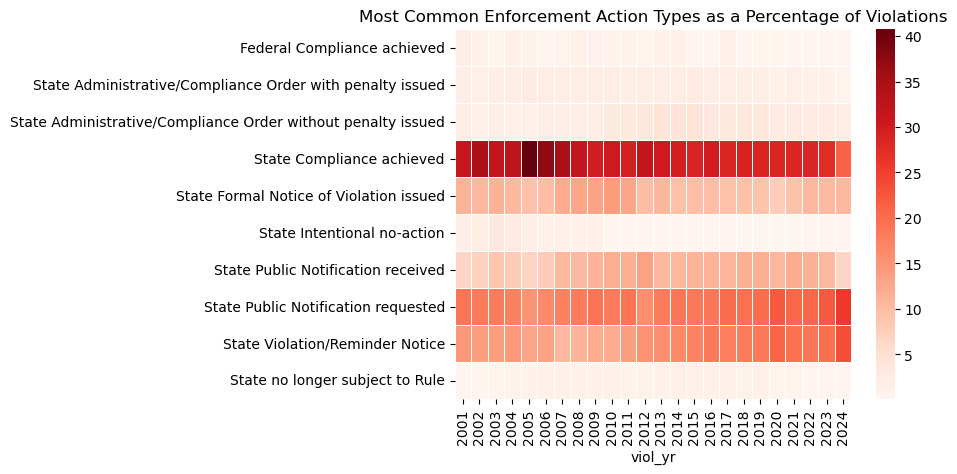

In [86]:
# plot heatmap
viols_enf_type_top10_reformat = (viols_enf_type_top10.pivot(index='ENFORCEMENT_ACTION_TYPE_CODE', columns='viol_yr', values='per_enfs'))
sns.heatmap(viols_enf_type_top10_reformat, linewidth=.5, cmap='Reds')
plt.ylabel('')
plt.title('Most Common Enforcement Action Types as a Percentage of Violations')
plt.savefig('per_enf_by_type_top10_heat_corrected.png', bbox_inches='tight')

In [87]:
# "State Compliance achieved" is consistently the most common enforcement type but is never half or more of violations
viols_enf_type_top10[viols_enf_type_top10['ENFORCEMENT_ACTION_TYPE_CODE']=='State Compliance achieved'].groupby('viol_yr').max()['per_enfs']

viol_yr
2001    31.377415
2002    34.597506
2003    31.551737
2004    32.310508
2005    40.720224
2006    37.290956
2007    34.533752
2008    31.979754
2009    29.846516
2010    30.185539
2011    29.400527
2012    31.882183
2013    30.130201
2014    29.477160
2015    28.713304
2016    30.034854
2017    28.396656
2018    29.029238
2019    28.713714
2020    28.617158
2021    28.570438
2022    28.593896
2023    27.501513
2024    21.040837
Name: per_enfs, dtype: float64

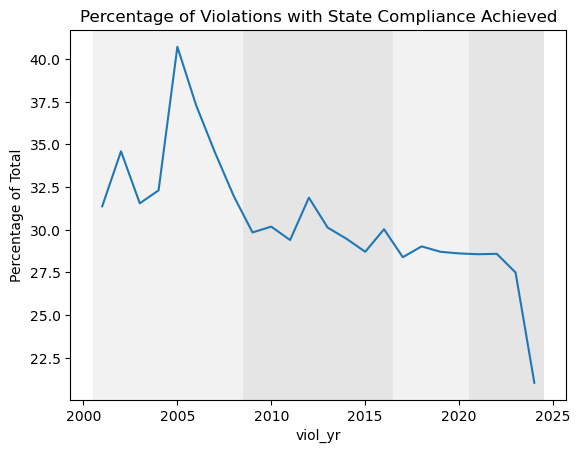

In [88]:
# plot percentage of violations with state compliance achieved by year
sns.lineplot(data=viols_enf_type_top10[viols_enf_type_top10['ENFORCEMENT_ACTION_TYPE_CODE']=='State Compliance achieved'].groupby('viol_yr').max(), x='viol_yr', y='per_enfs')

# add the spans for presidential administrations
pres_spans()
#plt.tight_layout()
plt.title('Percentage of Violations with State Compliance Achieved')
plt.ylabel('Percentage of Total')
plt.savefig('per_st_comp_ach_by_year_all_sys.png')


## Enforcement action categories: Have systems come back into compliance?

In [89]:
# some 'ENF_ACTION_CATEGORY' values are null 
# add a 'None' category
pws_viols['ENF_ACTION_CATEGORY'] = pws_viols['ENF_ACTION_CATEGORY'].fillna(value='None')

# summarize violations by year and enforcement category
viols_enf_cat = pws_viols.groupby(['viol_yr', 'ENF_ACTION_CATEGORY'], as_index=False).count()[['viol_yr', 'ENF_ACTION_CATEGORY','VIOLATION_ID',]].rename(columns={'VIOLATION_ID':'num_enfs_cat'})

# add a column for the total violations per year values
viols_enf_cat['yr_viols_tot'] = viols_enf_cat['viol_yr']
viols_enf_cat['yr_viols_tot'] = viols_enf_cat['yr_viols_tot'].map(num_viols_any_type)

# calculate the percentages
viols_enf_cat['per_enfs'] = (viols_enf_cat['num_enfs_cat']/viols_enf_cat['yr_viols_tot']) * 100

# check the math
viols_enf_cat.groupby('viol_yr').sum()['per_enfs']

viol_yr
2001    100.0
2002    100.0
2003    100.0
2004    100.0
2005    100.0
2006    100.0
2007    100.0
2008    100.0
2009    100.0
2010    100.0
2011    100.0
2012    100.0
2013    100.0
2014    100.0
2015    100.0
2016    100.0
2017    100.0
2018    100.0
2019    100.0
2020    100.0
2021    100.0
2022    100.0
2023    100.0
2024    100.0
Name: per_enfs, dtype: float64

In [90]:
# create a dictionary to plot the values as stacked bar chart
enf_cats = ['Resolving', 'Informal', 'Formal', 'None']
enf_pers = dict()
for enf_cat in enf_cats:
    array = np.array(viols_enf_cat[viols_enf_cat['ENF_ACTION_CATEGORY'] == enf_cat]['per_enfs'])
    enf_pers.update({enf_cat:array})
# What are the ranges for the types? 
print("Resolving:")
print("Max % of enforcements resolving:",enf_pers['Resolving'].max())
print("Min % of enforcements resolving:",enf_pers['Resolving'].min())
print("\nInformal:")
print("Max % of enforcements informal:",enf_pers['Informal'].max())
print("Min % of enforcements informal:",enf_pers['Informal'].min())
print("\nFormal:")
print("Max % of enforcements formal:",enf_pers['Formal'].max())
print("Min % of enforcements formal:",enf_pers['Formal'].min())
print("\nInformal:")
print("None:")
print("Max % of enforcements with null value (coded as 'None':",enf_pers['None'].max())
print("Min % of enforcements with null value (coded as 'None':",enf_pers['None'].min())

Resolving:
Max % of enforcements resolving: 43.156091508740936
Min % of enforcements resolving: 21.5137654039854

Informal:
Max % of enforcements informal: 68.38016408915996
Min % of enforcements informal: 48.25802434487085

Formal:
Max % of enforcements formal: 8.094770213962239
Min % of enforcements formal: 3.4893698474617665

Informal:
None:
Max % of enforcements with null value (coded as 'None': 6.616700659392884
Min % of enforcements with null value (coded as 'None': 0.4311532584219624


In [91]:
enf_pers['Resolving']

array([33.81608833, 36.48878955, 34.6237993 , 36.16142859, 43.15609151,
       39.54691481, 37.14861288, 35.08012253, 32.53238446, 32.1529014 ,
       31.31776082, 33.52626131, 31.90175241, 32.00574163, 30.41871133,
       31.62658061, 30.7426146 , 30.42226352, 30.28352288, 29.81007286,
       29.60245054, 29.5903573 , 28.32535133, 21.5137654 ])

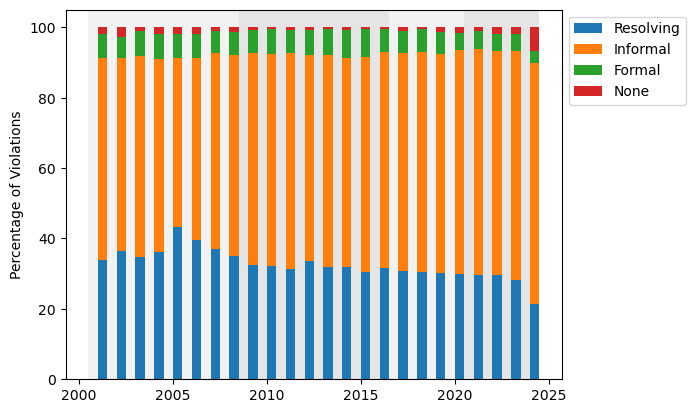

In [92]:
# plot the data
years = np.array(range(2001,2025))

width = 0.5
fig, ax = plt.subplots()
bottom = np.zeros(len(years))

for enf_cat, enf_per in enf_pers.items():
    p = ax.bar(years, enf_per, width, label=enf_cat, bottom=bottom, align='edge', zorder=1)
    bottom += enf_per

#ax.set_title("Violation Enforcement Categories Over Time")
plt.ylabel("Percentage of Violations")
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

# add the spans for presidential administrations
pres_spans() 

plt.savefig('enf_cats_time_all_sys.png', bbox_inches='tight')

## Enforcement action categories for health-based violations

In [93]:
# add a 'None' category for null values
mask = pws_viols_health['ENF_ACTION_CATEGORY'].isna()
pws_viols_health.loc[mask, 'ENF_ACTION_CATEGORY'] = 'None'

# look at enforcement category for health-based violations 
viols_health_enf_cat = pws_viols_health.groupby(['viol_yr', 'ENF_ACTION_CATEGORY'], as_index=False).count()[['viol_yr', 'ENF_ACTION_CATEGORY','VIOLATION_ID',]].rename(columns={'VIOLATION_ID':'num_enfs_cat'})

# add a column for the total violations per year values
viols_health_enf_cat['yr_viols_health'] = viols_health_enf_cat['viol_yr']
viols_health_enf_cat['yr_viols_health'] = viols_health_enf_cat['yr_viols_health'].map(num_viols_health)

# calculate the percentages
viols_health_enf_cat['per_enfs'] = (viols_health_enf_cat['num_enfs_cat']/viols_health_enf_cat['yr_viols_health']) * 100
viols_health_enf_cat

# make a dictionary to plot the values as stacked bar chart
enf_cats = ['Resolving', 'Informal', 'Formal', 'None']
enf_pers_health = dict()
for enf_cat in enf_cats:
    array = np.array(viols_health_enf_cat[viols_health_enf_cat['ENF_ACTION_CATEGORY'] == enf_cat]['per_enfs'])
    enf_pers_health.update({enf_cat:array})

In [94]:
# What are the ranges for the types? 
print("Resolving:")
print("Max % of enforcements resolving:",enf_pers_health['Resolving'].max())
print("Min % of enforcements resolving:",enf_pers_health['Resolving'].min())
print("\nInformal:")
print("Max % of enforcements informal:",enf_pers_health['Informal'].max())
print("Min % of enforcements informal:",enf_pers_health['Informal'].min())
print("\nFormal:")
print("Max % of enforcements formal:",enf_pers_health['Formal'].max())
print("Min % of enforcements formal:",enf_pers_health['Formal'].min())
print("\nInformal:")
print("None:")
print("Max % of enforcements with null value (coded as 'None':",enf_pers_health['None'].max())
print("Min % of enforcements with null value (coded as 'None':",enf_pers_health['None'].min())

Resolving:
Max % of enforcements resolving: 25.354515187636157
Min % of enforcements resolving: 13.300168263954934

Informal:
Max % of enforcements informal: 70.80010729875387
Min % of enforcements informal: 59.455234971557424

Formal:
Max % of enforcements formal: 17.43905064956815
Min % of enforcements formal: 7.020428295449875

Informal:
None:
Max % of enforcements with null value (coded as 'None': 6.067256809812959
Min % of enforcements with null value (coded as 'None': 0.08837995696280357


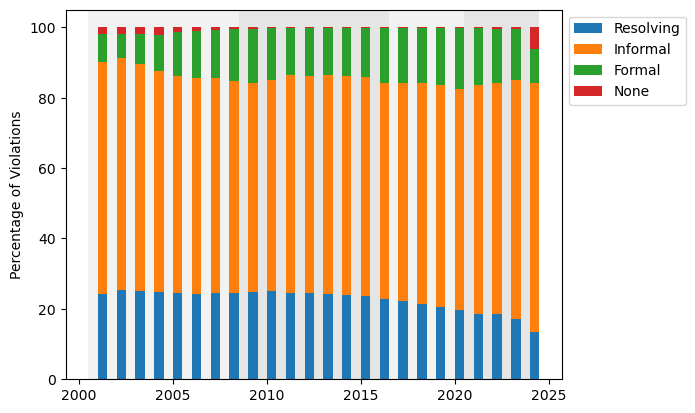

In [95]:
# plot the data
years = np.array(range(2001,2025))

width = 0.5
fig, ax = plt.subplots()
bottom = np.zeros(len(years))

for enf_cat, enf_per in enf_pers_health.items():
    p = ax.bar(years, enf_per, width, label=enf_cat, bottom=bottom, align='edge', zorder=1)
    bottom += enf_per

#ax.set_title("Violation Enforcement Categories Over Time, Health-Based Violations Only")
plt.ylabel("Percentage of Violations")
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

# add the spans for presidential administrations
pres_spans()

plt.savefig('enf_cats_health_time_all_sys.png', bbox_inches='tight')
plt.show()

## Violations & Enforcement by State

### Aggregate the violations data by state/year

In [152]:
# count violations by state
pws_viols_agg_state = pws_viols.groupby(['STATE_CODE', 'viol_yr'], as_index=False)['VIOLATION_ID'].count().rename(columns={'VIOLATION_ID':'num_viols'})

# add column for resolving violations 
num_viols_res = pws_viols[pws_viols['ENF_ACTION_CATEGORY']=='Resolving'].groupby(['STATE_CODE', 'viol_yr'], as_index=False)['VIOLATION_ID'].count().rename(columns={'VIOLATION_ID':'num_viols_res'})
pws_viols_agg_state = pd.merge(pws_viols_agg_state, num_viols_res, on=['STATE_CODE', 'viol_yr'])

# add a column for percent violations resolved
pws_viols_agg_state['per_viols_res'] = (pws_viols_agg_state['num_viols_res'] / pws_viols_agg_state['num_viols']) * 100

# add a column for non-compliance duration
non_comp_dur = pws_viols.groupby(['STATE_CODE', 'viol_yr'], as_index=False)['non_compl_duration'].mean()
non_comp_dur['avg_non_compl_dur'] = non_comp_dur['non_compl_duration'].dt.days
non_comp_dur = non_comp_dur.drop(columns=['non_compl_duration'])
pws_viols_agg_state = pd.merge(pws_viols_agg_state, non_comp_dur, on=['STATE_CODE', 'viol_yr'])

# add column for number of health-related violations
pws_viols_h = pws_viols_health.groupby(['STATE_CODE', 'viol_yr'], as_index=False)['VIOLATION_ID'].count().rename(columns={'VIOLATION_ID':'num_viols_h'})
pws_viols_agg_state = pd.merge(pws_viols_agg_state, pws_viols_h, on=['STATE_CODE', 'viol_yr'])

# add column for health-related violations resolving
num_viols_h_res = pws_viols_health[pws_viols_health['ENF_ACTION_CATEGORY']=='Resolving'].groupby(['STATE_CODE', 'viol_yr'], as_index=False)['VIOLATION_ID'].count().rename(columns={'VIOLATION_ID':'num_viols_h_res'})
pws_viols_agg_state = pd.merge(pws_viols_agg_state, num_viols_h_res, on=['STATE_CODE', 'viol_yr'])

# add a column for percent health-based violations resolved
pws_viols_agg_state['per_viols_res_h'] = (pws_viols_agg_state['num_viols_h_res'] / pws_viols_agg_state['num_viols_h']) * 100

# add a column for health-based non-compliance duration
non_comp_dur_h = pws_viols_health.groupby(['STATE_CODE', 'viol_yr'], as_index=False)['non_compl_duration'].mean()
non_comp_dur_h['avg_non_compl_dur_h'] = non_comp_dur_h['non_compl_duration'].dt.days
non_comp_dur_h = non_comp_dur_h.drop(columns=['non_compl_duration'])
pws_viols_agg_state = pd.merge(pws_viols_agg_state, non_comp_dur_h, on=['STATE_CODE', 'viol_yr'])

### Normalize violation counts to number of PWS

In [153]:
# add a column for the number of pws per year
pws_viols_agg_state['num_pws_yr'] = pws_viols_agg_state['viol_yr']

# get the number of pws that were deactivated each year by state
num_pws_deac_yr_state = sdwa_pws.groupby('STATE_CODE', as_index=False)['PWS_DEACTIVATION_DATE'].value_counts().rename(columns={'PWS_DEACTIVATION_DATE':'deac_yr', 'count':'num_pws_deac'})
num_pws_deac_yr_state = num_pws_deac_yr_state.sort_values(by='deac_yr')
# create a dictionary of grouped deactivation count data
num_pws_deac_yr_state_dict = {name: group for name, group in num_pws_deac_yr_state.groupby('STATE_CODE')}

## get the number of active pws each year by state
# loop through states
for state in usps_codes:
    # calculate the cumulative sum of deactivated pws by state
    num_pws_deac_cum_state = num_pws_deac_yr_state_dict[state].set_index('deac_yr').sort_index(ascending=False).cumsum()['num_pws_deac']
    # add the cumulative sums to the number of currently active pws to back-calculate the total number of active pws per year
    num_pws_yr_state = num_pws_deac_cum_state + (len(sdwa_pws[(sdwa_pws['PWS_ACTIVITY_CODE'] == 'A') * (sdwa_pws['PWS_TYPE_CODE'] == state)]))
    num_pws_yr_state = num_pws_yr_state.rename_axis(index={'PWS_DEACTIVATION_DATE': 'deac_yr'}).rename('num_active_cws').astype('int32')
    if len(num_pws_yr_state) != 24: # ensure that num_pws_yr_state has a value for each year in the range
        index = [i for i in range(2001,2025)]
        num_pws_yr_state = num_pws_yr_state.reindex(index, method='bfill')
    # map the values to the aggregated df
    pws_viols_agg_state.loc[pws_viols_agg_state['STATE_CODE']==state, 'num_pws_yr'] = pws_viols_agg_state.loc[pws_viols_agg_state['STATE_CODE']==state, 'num_pws_yr'].map(lambda x: num_pws_yr_state[x])

In [154]:
## calculate the normalized values
# number of violations
pws_viols_agg_state['num_viols_pws'] = pws_viols_agg_state['num_viols'] / pws_viols_agg_state['num_pws_yr']

# number of violations resolving
pws_viols_agg_state['num_viols_res_pws'] = pws_viols_agg_state['num_viols_res'] / pws_viols_agg_state['num_pws_yr']

# number of health violations
pws_viols_agg_state['num_viols_h_pws'] = pws_viols_agg_state['num_viols_h'] / pws_viols_agg_state['num_pws_yr']

# number of health violations resolving
pws_viols_agg_state['num_viols_h_res_pws'] = pws_viols_agg_state['num_viols_h_res'] / pws_viols_agg_state['num_pws_yr']

In [155]:
pws_viols_agg_state

STATE_CODE  viol_yr  num_viols  num_viols_res  per_viols_res  \
0            AK     2001      11992           5857      48.840894   
1            AK     2002       6482           3755      57.929651   
2            AK     2003       7499           3694      49.259901   
3            AK     2004       9972           5012      50.260730   
4            AK     2005      10085           5487      54.407536   
...         ...      ...        ...            ...            ...   
1234         WY     2020       1824           1184      64.912281   
1235         WY     2021        800            566      70.750000   
1236         WY     2022       1186            656      55.311973   
1237         WY     2023       1076            682      63.382900   
1238         WY     2024        985            545      55.329949   

      avg_non_compl_dur  num_viols_h  num_viols_h_res  per_viols_res_h  \
0                   166          348               26         7.471264   
1                   629          231               28        12.121212   
2                   275          448              155        34.598214   
3                   219          437              170        38.901602   
4                   337          642              361        56.230530   
...                 ...          ...              ...              ...   
1234                735          124               67        54.032258   
1235                172          106               63        59.433962   
1236                162           87               46        52.873563   
1237                121          163               71        43.558282   
1238                103          177               49        27.683616   

      avg_non_compl_dur_h  num_pws_yr  num_viols_pws  num_viols_res_pws  \
0                      78      1294.0       9.267388           4.526275   
1                     240      1274.0       5.087912           2.947410   
2                      84      1245.0       6.023293           2.967068   
3                     106      1193.0       8.358759           4.201174   
4                     121      1175.0       8.582979           4.669787   
...                   ...         ...            ...                ...   
1234                  257        51.0      35.764706          23.215686   
1235                  154        35.0      22.857143          16.171429   
1236                  292        30.0      39.533333          21.866667   
1237                  134        19.0      56.631579          35.894737   
1238                   88        10.0      98.500000          54.500000   

      num_viols_h_pws  num_viols_h_res_pws  
0            0.268934             0.020093  
1            0.181319             0.021978  
2            0.359839             0.124498  
3            0.366303             0.142498  
4            0.546383             0.307234  
...               ...                  ...  
1234         2.431373             1.313725  
1235         3.028571             1.800000  
1236         2.900000             1.533333  
1237         8.578947             3.736842  
1238        17.700000             4.900000  

[1239 rows x 15 columns]

In [ ]:
### Number of health-based violations per PWS is much different than in previous version
# this is due to an error in the calculations in the previous version whereby the 
# violation counts were divided by the number of pws twice

## Take a look at the data by state over time

### All violations

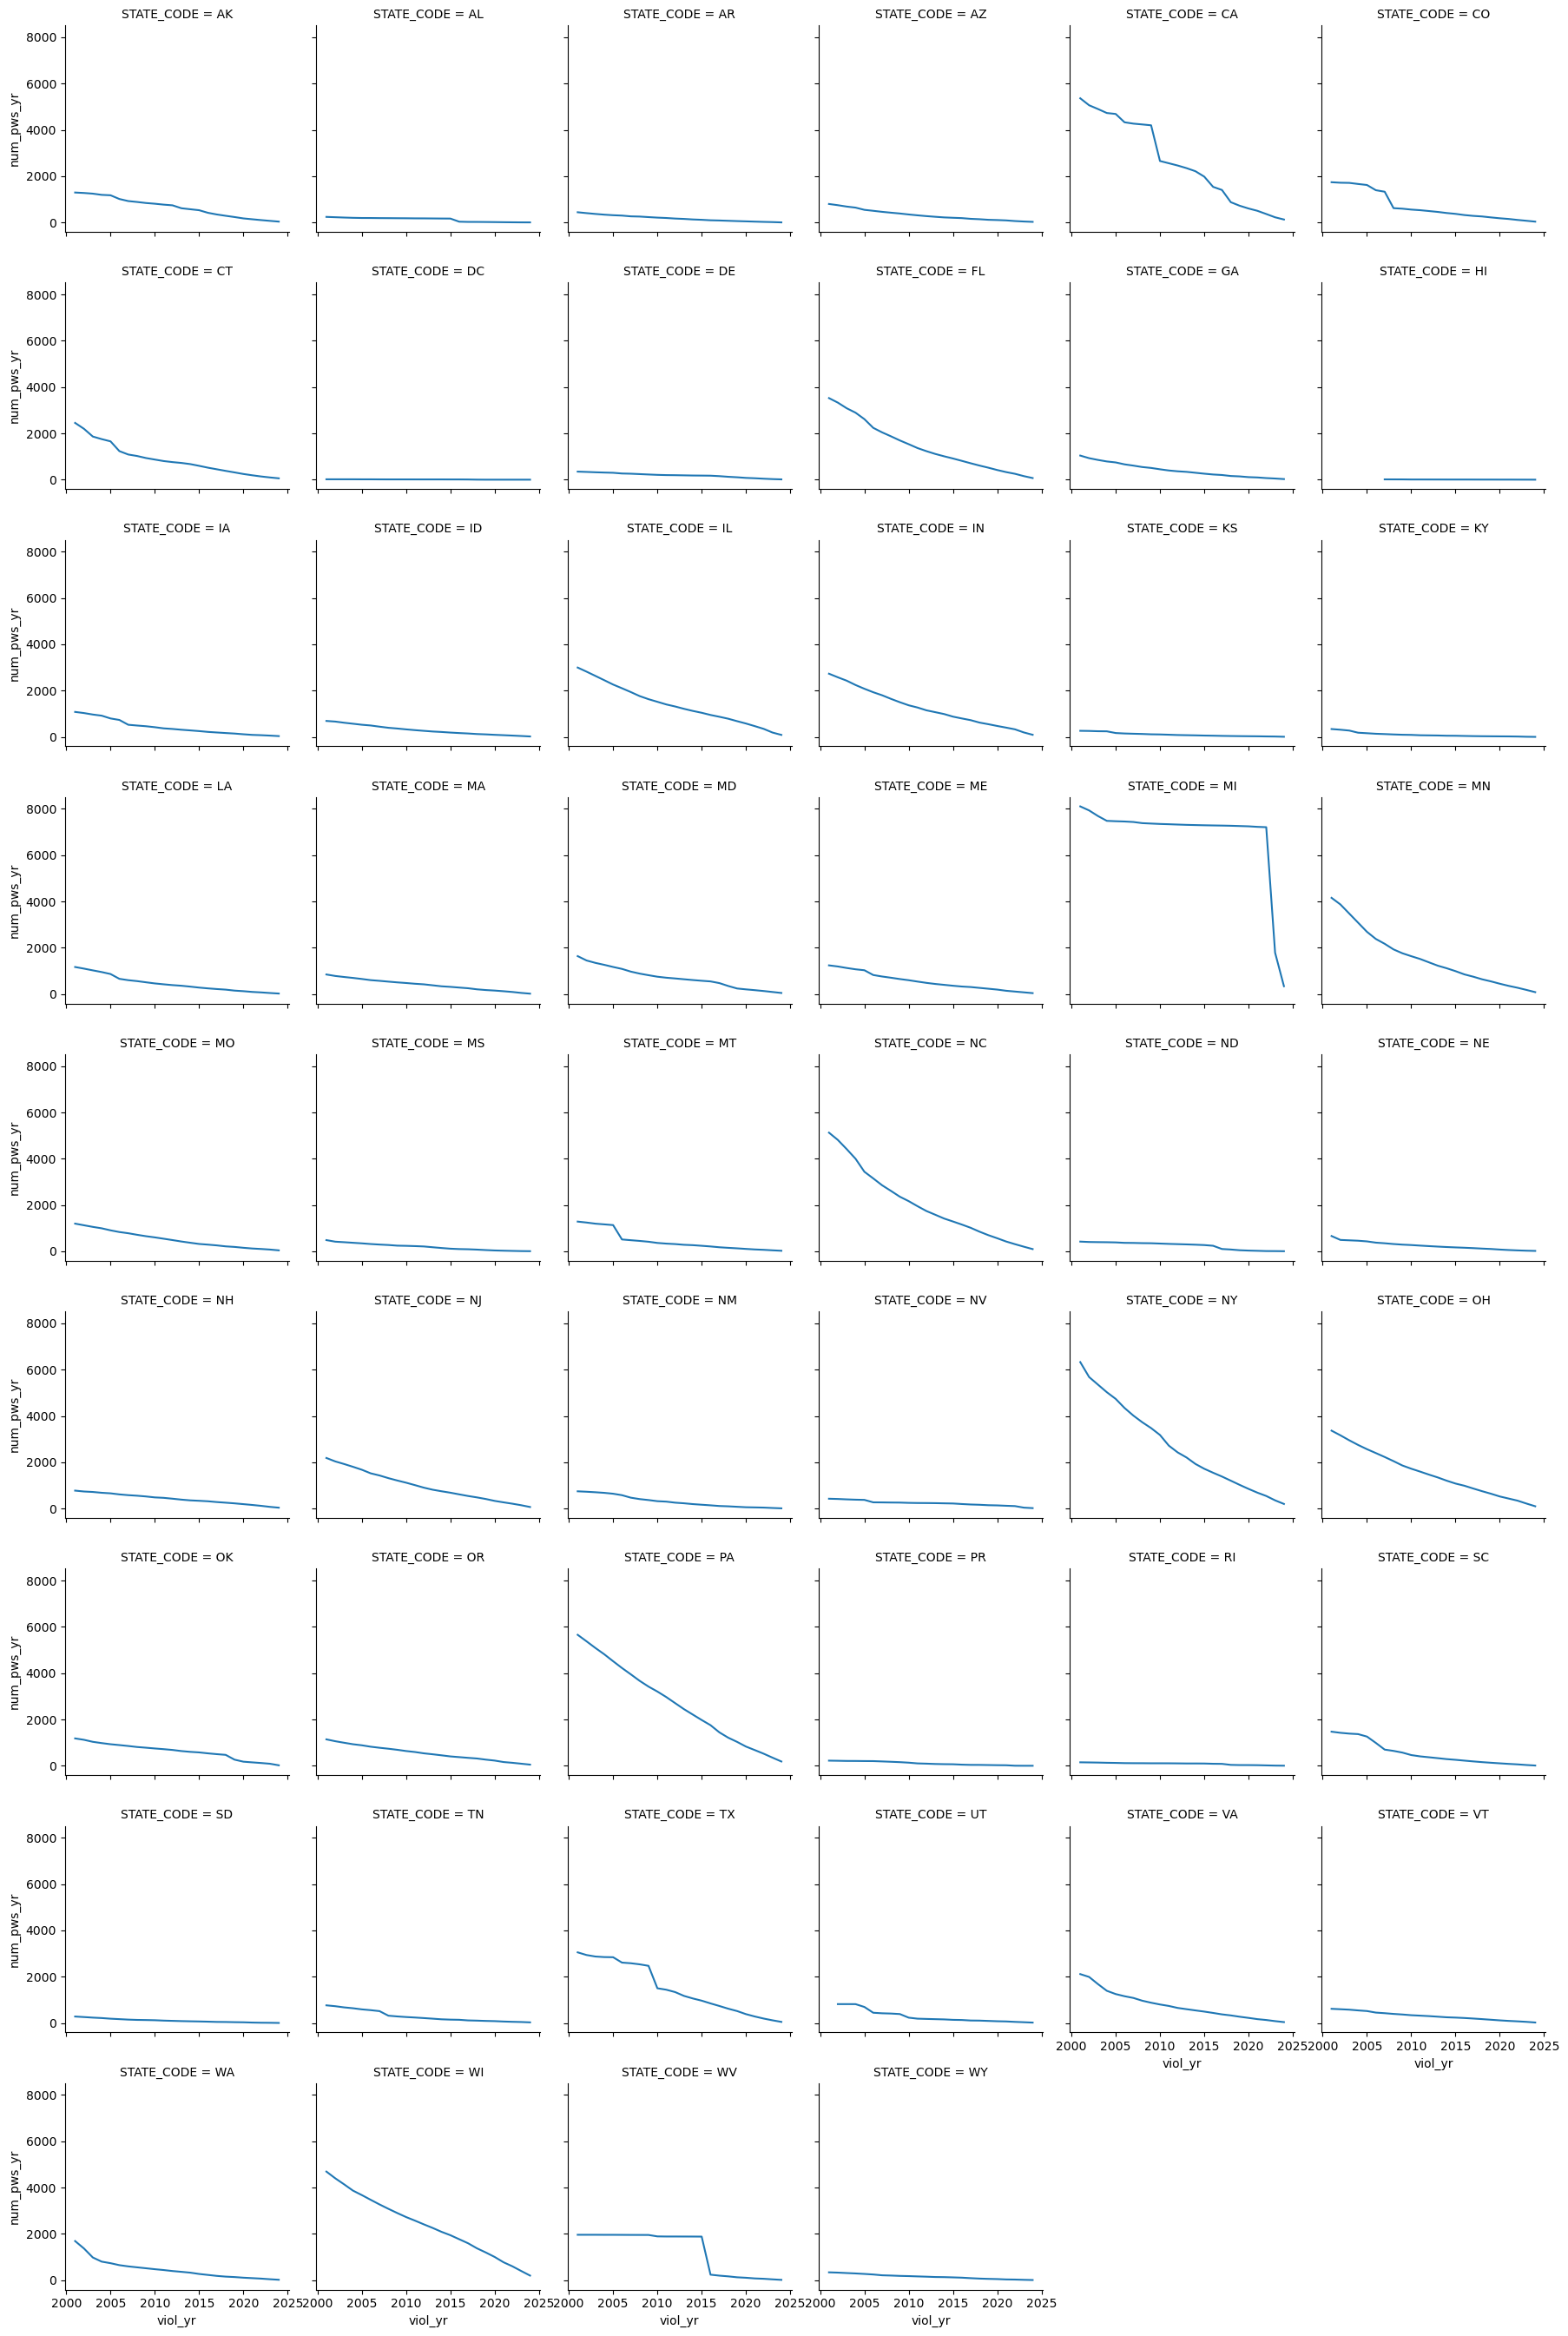

In [100]:
# how have number of pws changed over time by states? ### What is going on with Michigan?
g = sns.FacetGrid(pws_viols_agg_state, col='STATE_CODE', col_wrap=6)
g.map(sns.lineplot, 'viol_yr', 'num_pws_yr')
plt.savefig('num_pws_yr_states.png', bbox_inches='tight')

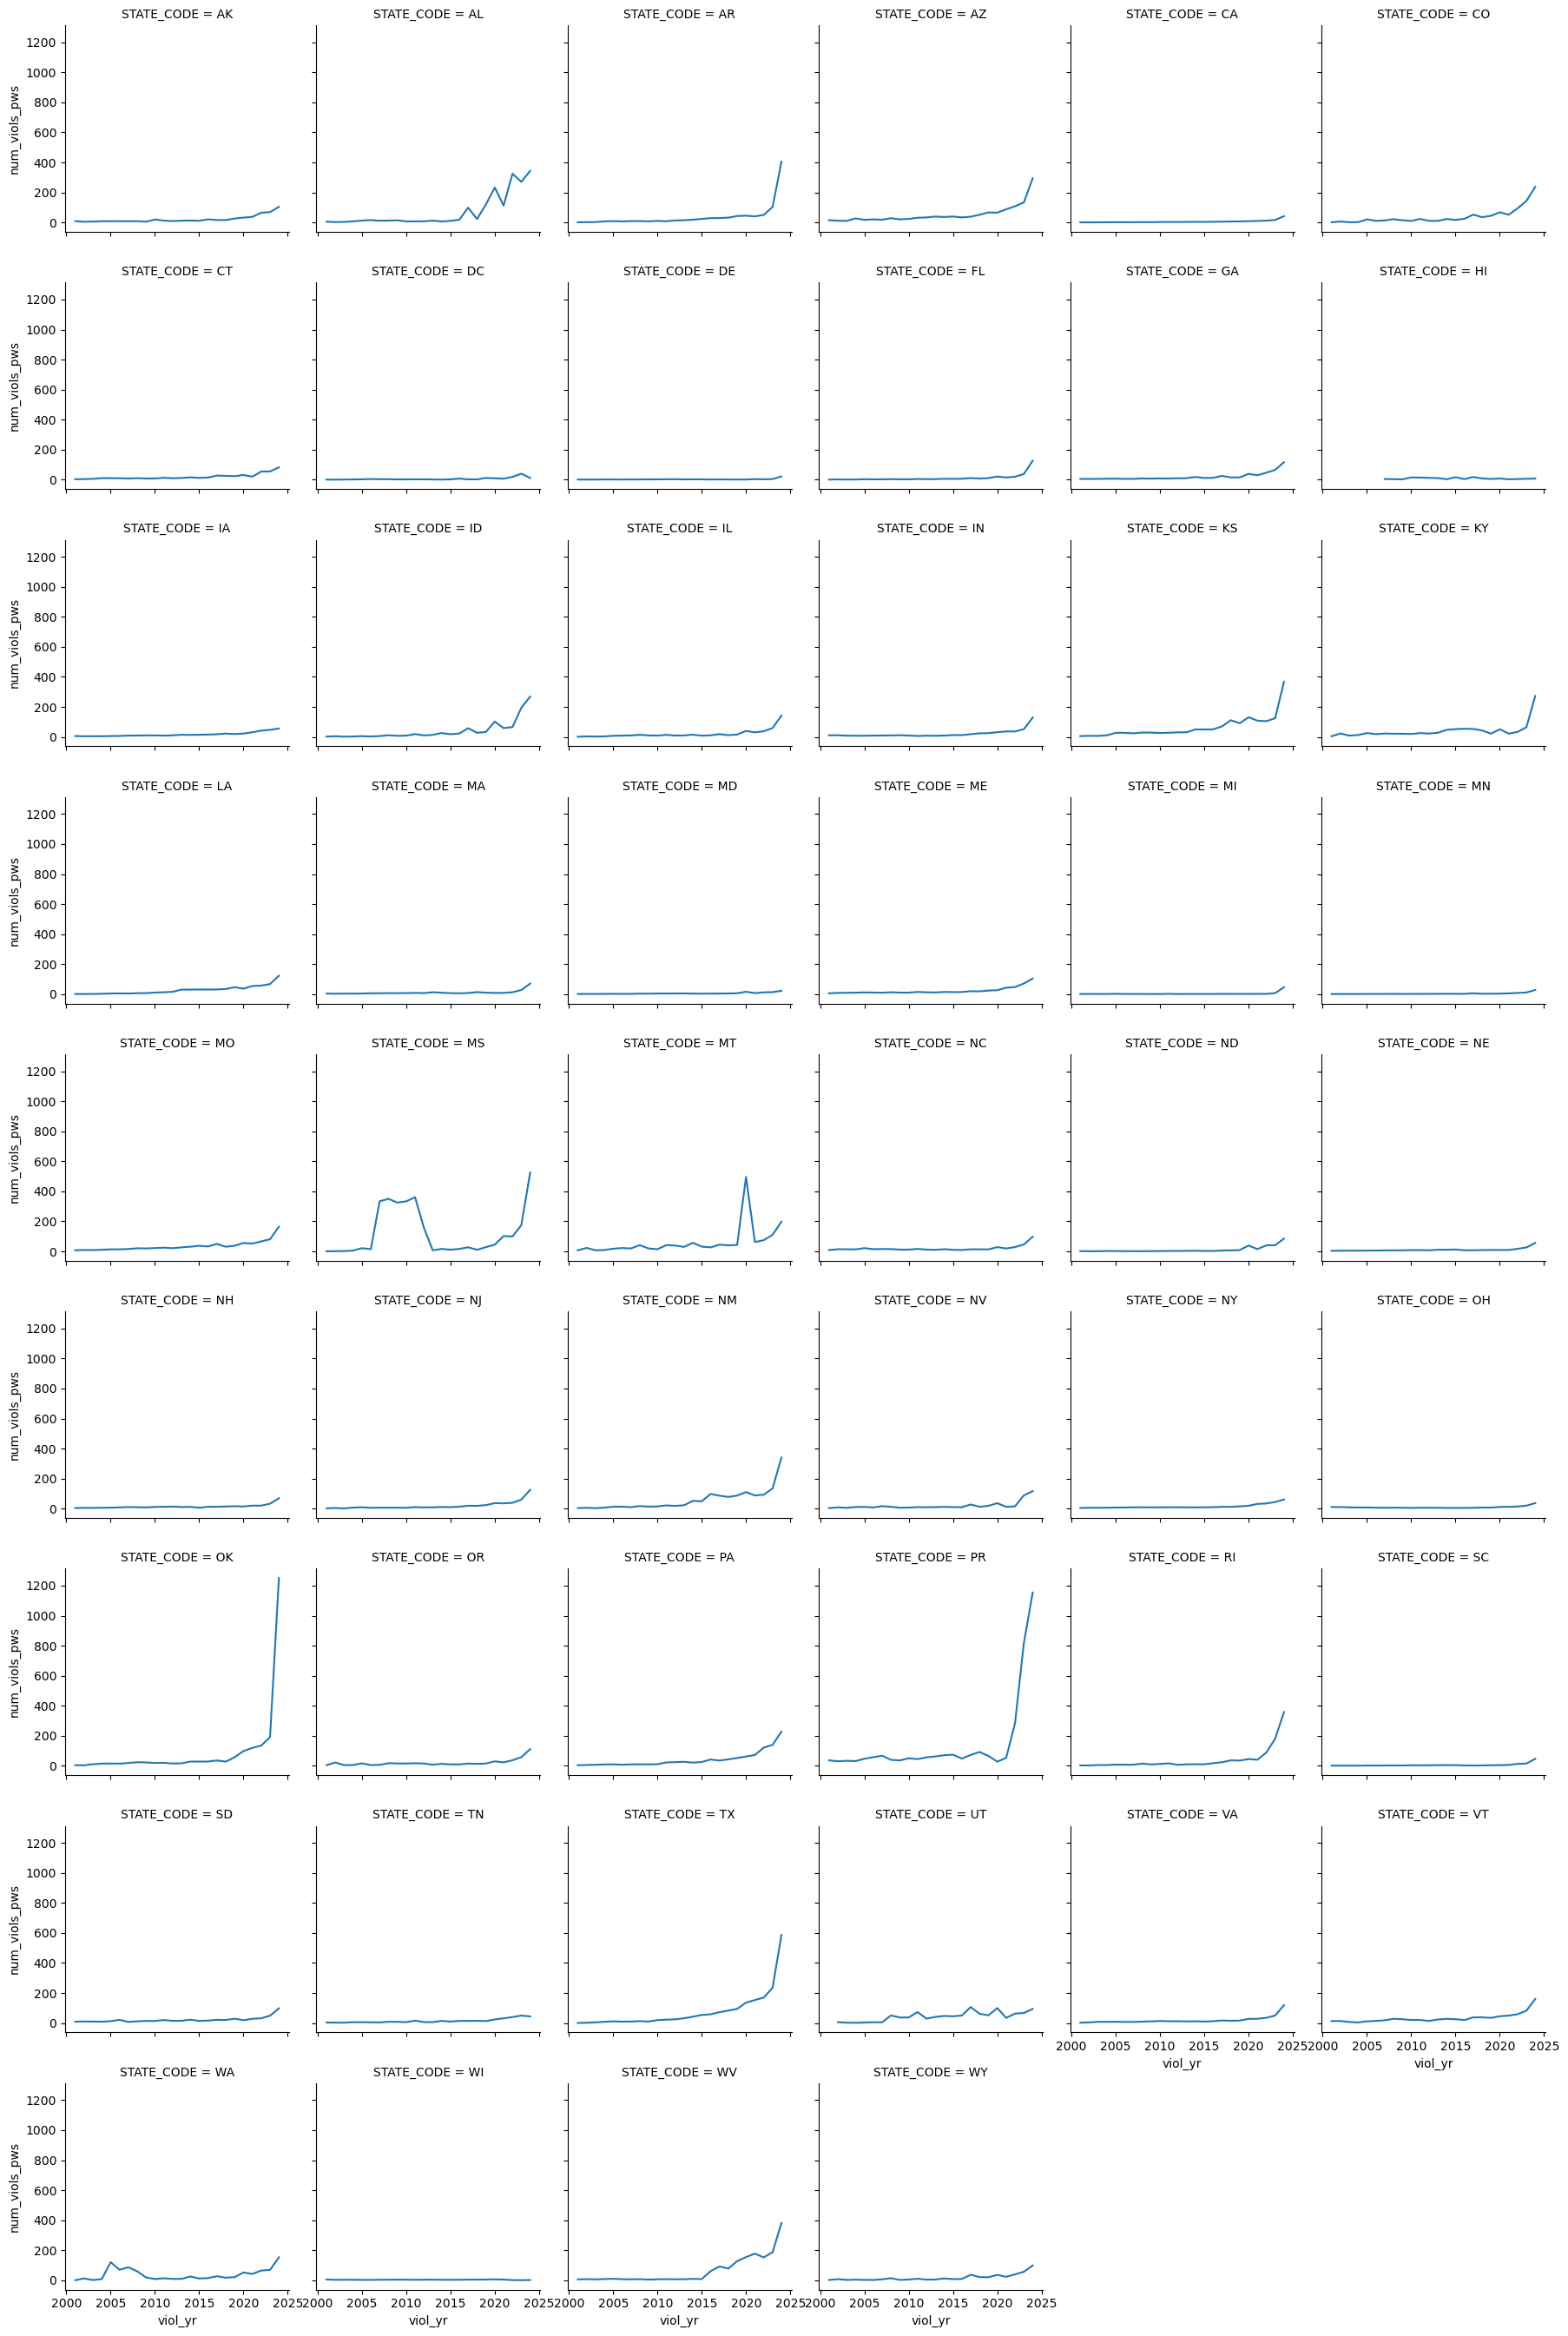

In [101]:
# number of violations per pws ### This is increasing almost everywhere but some of these numbers look like outliers, see OK & PR
g = sns.FacetGrid(pws_viols_agg_state, col='STATE_CODE', col_wrap=6)
g.map(sns.lineplot, 'viol_yr', 'num_viols_pws')
plt.savefig('num_viols_pws_yr_states.png', bbox_inches='tight')

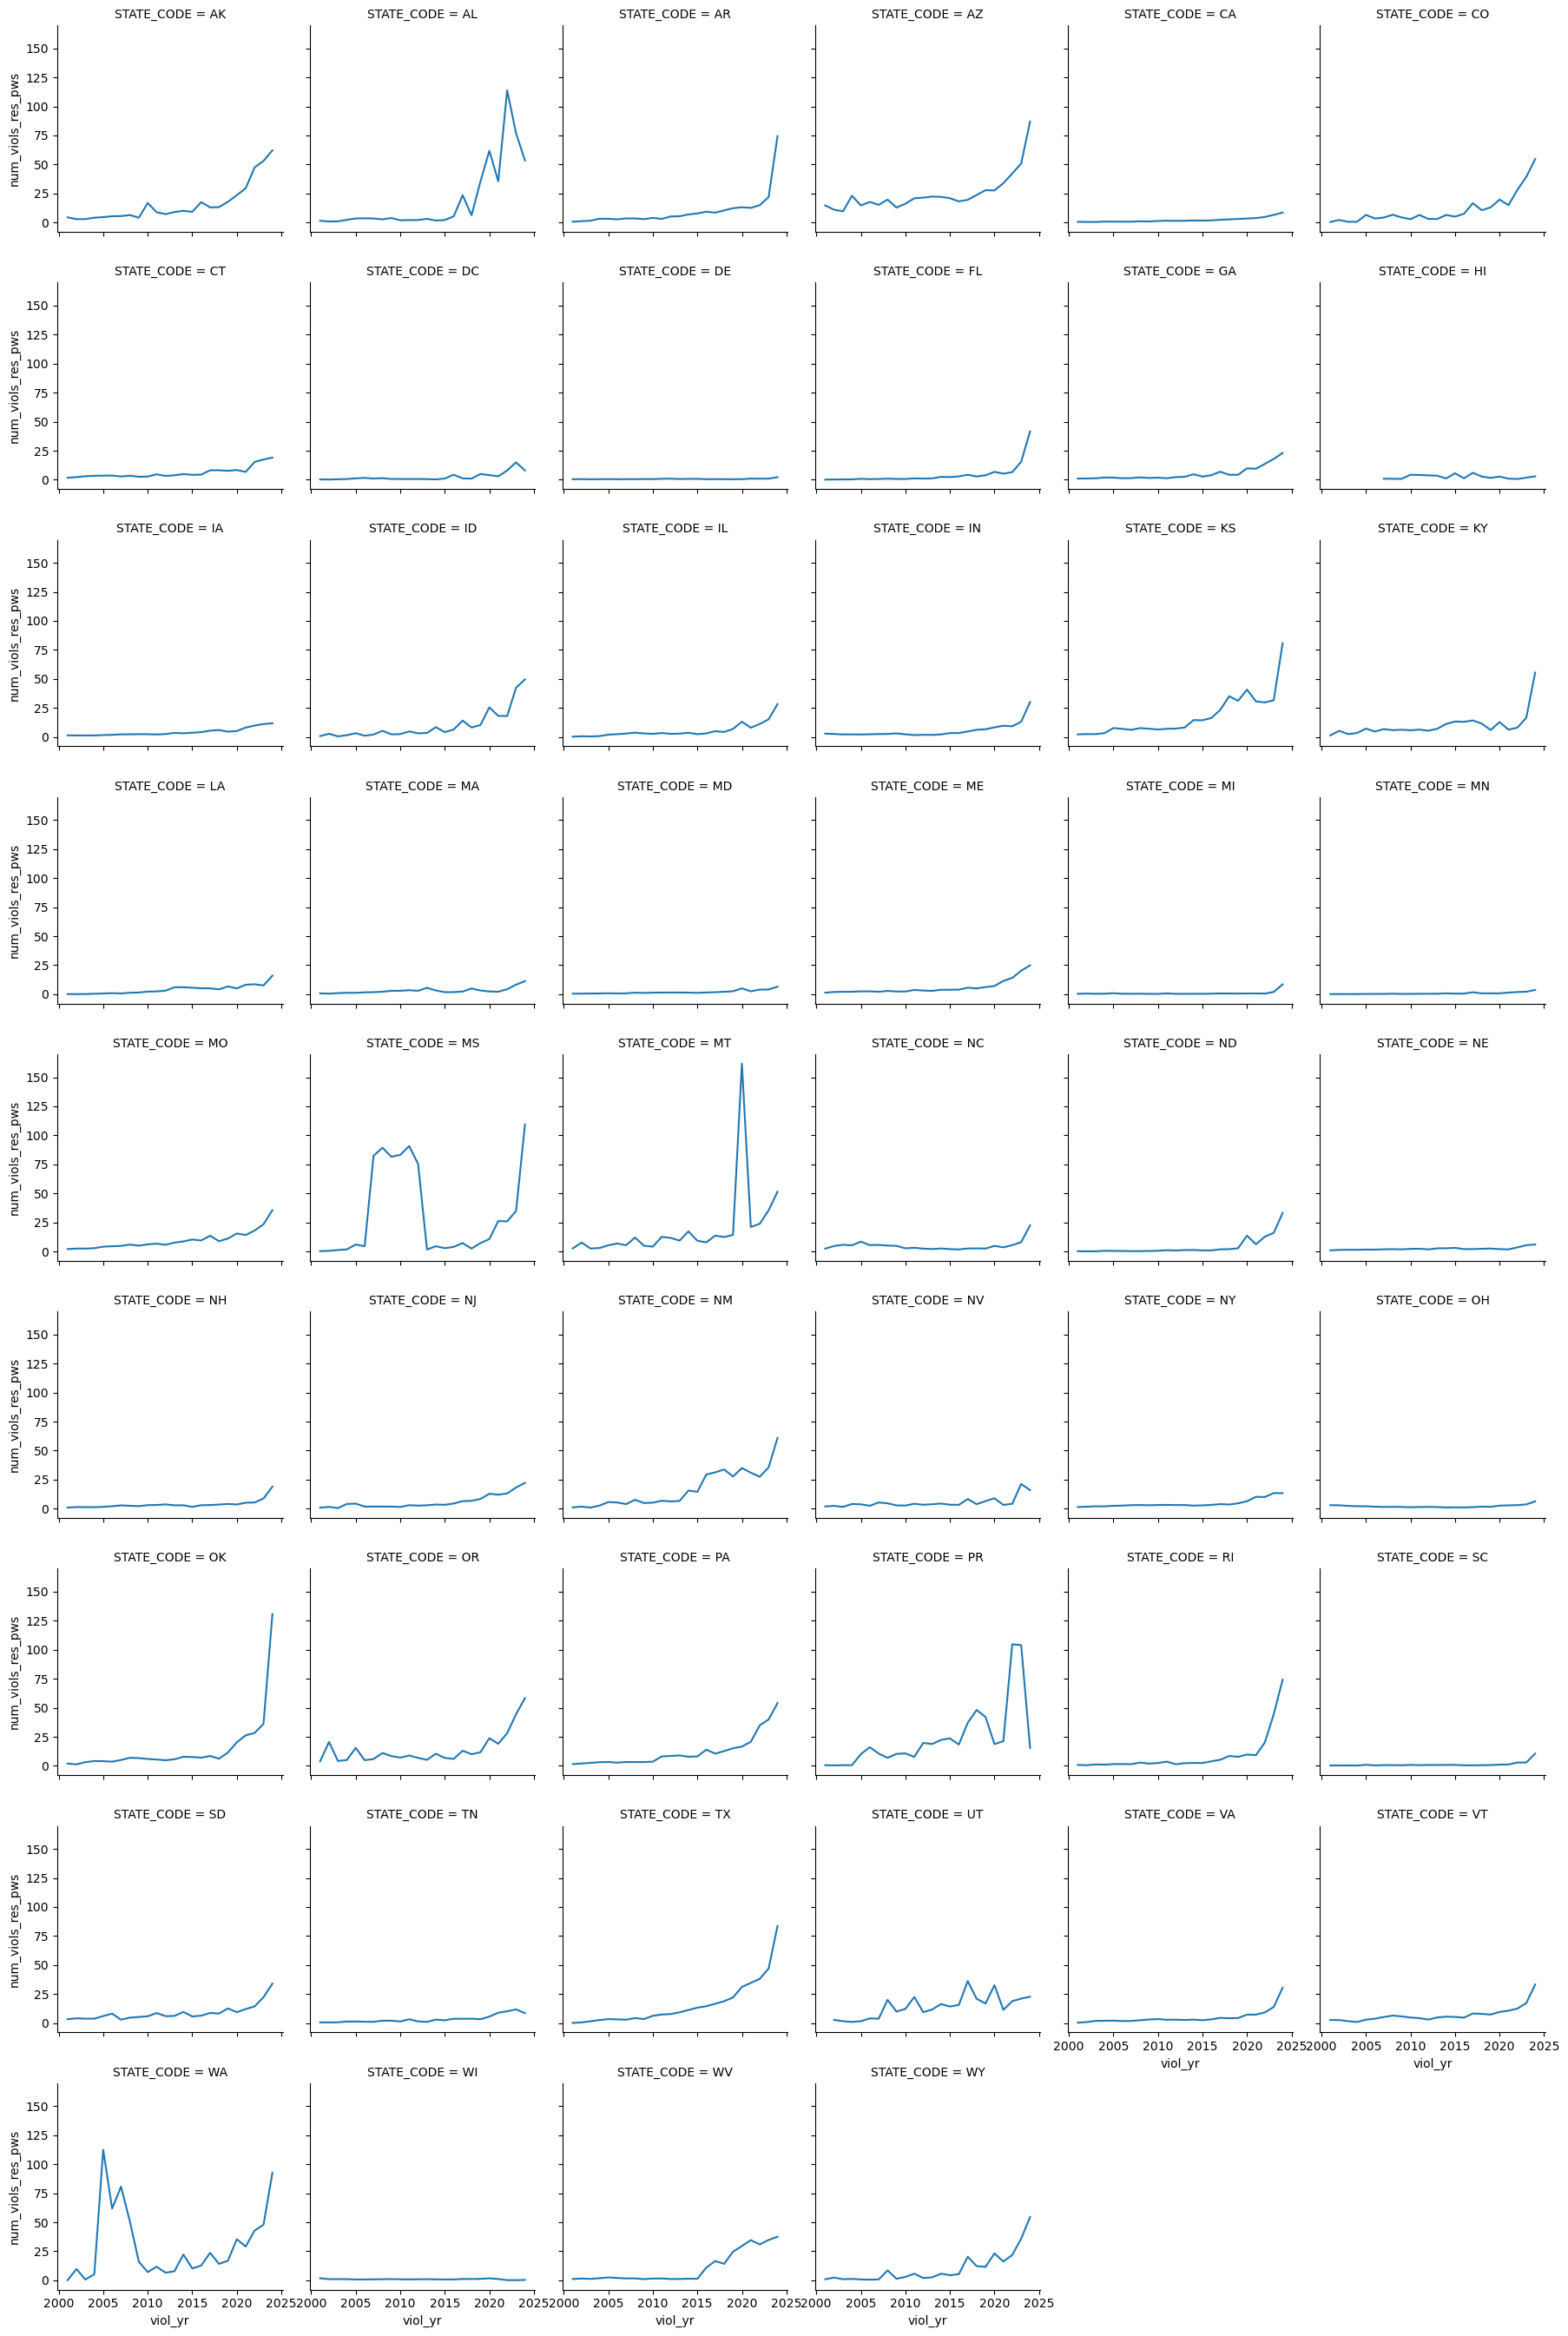

In [102]:
# number of violations resolving per pws
g = sns.FacetGrid(pws_viols_agg_state, col='STATE_CODE', col_wrap=6)
g.map(sns.lineplot, 'viol_yr', 'num_viols_res_pws')
plt.savefig('num_viols_res_pws_yr_states.png', bbox_inches='tight')

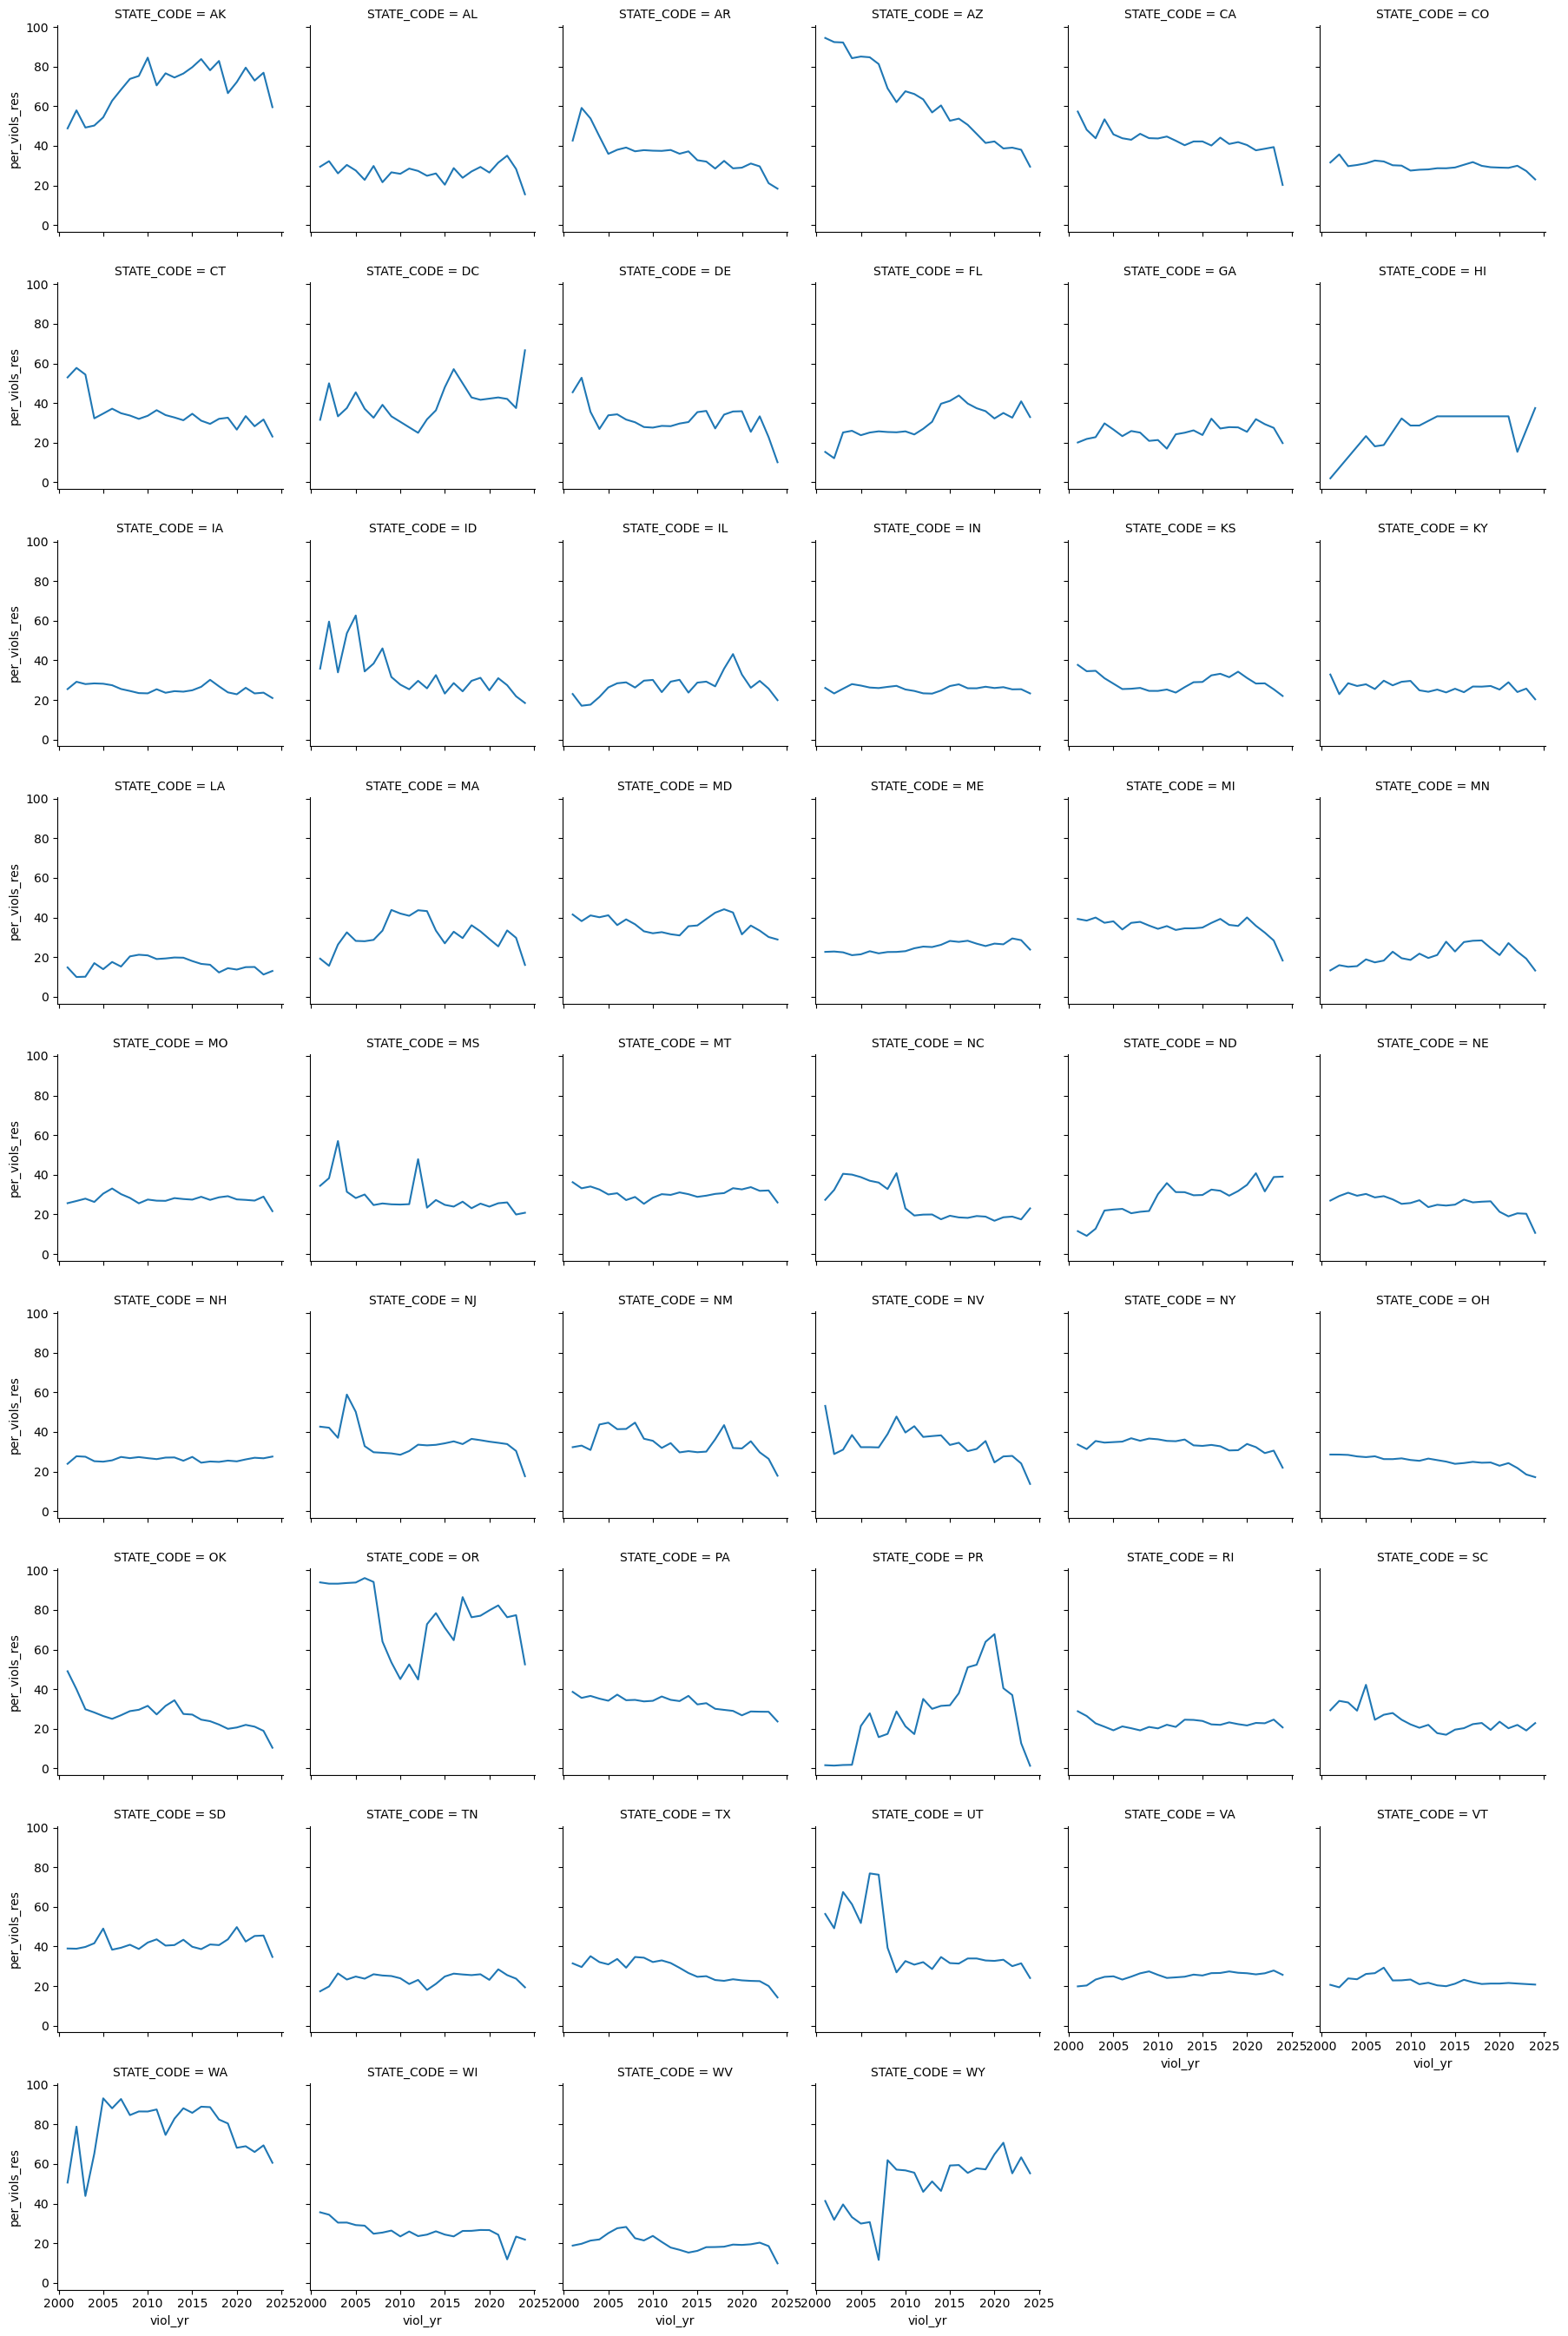

In [103]:
# percentage of violations resolving
g = sns.FacetGrid(pws_viols_agg_state, col='STATE_CODE', col_wrap=6)
g.map(sns.lineplot, 'viol_yr', 'per_viols_res')
plt.savefig('per_viols_res_yr_states.png', bbox_inches='tight')

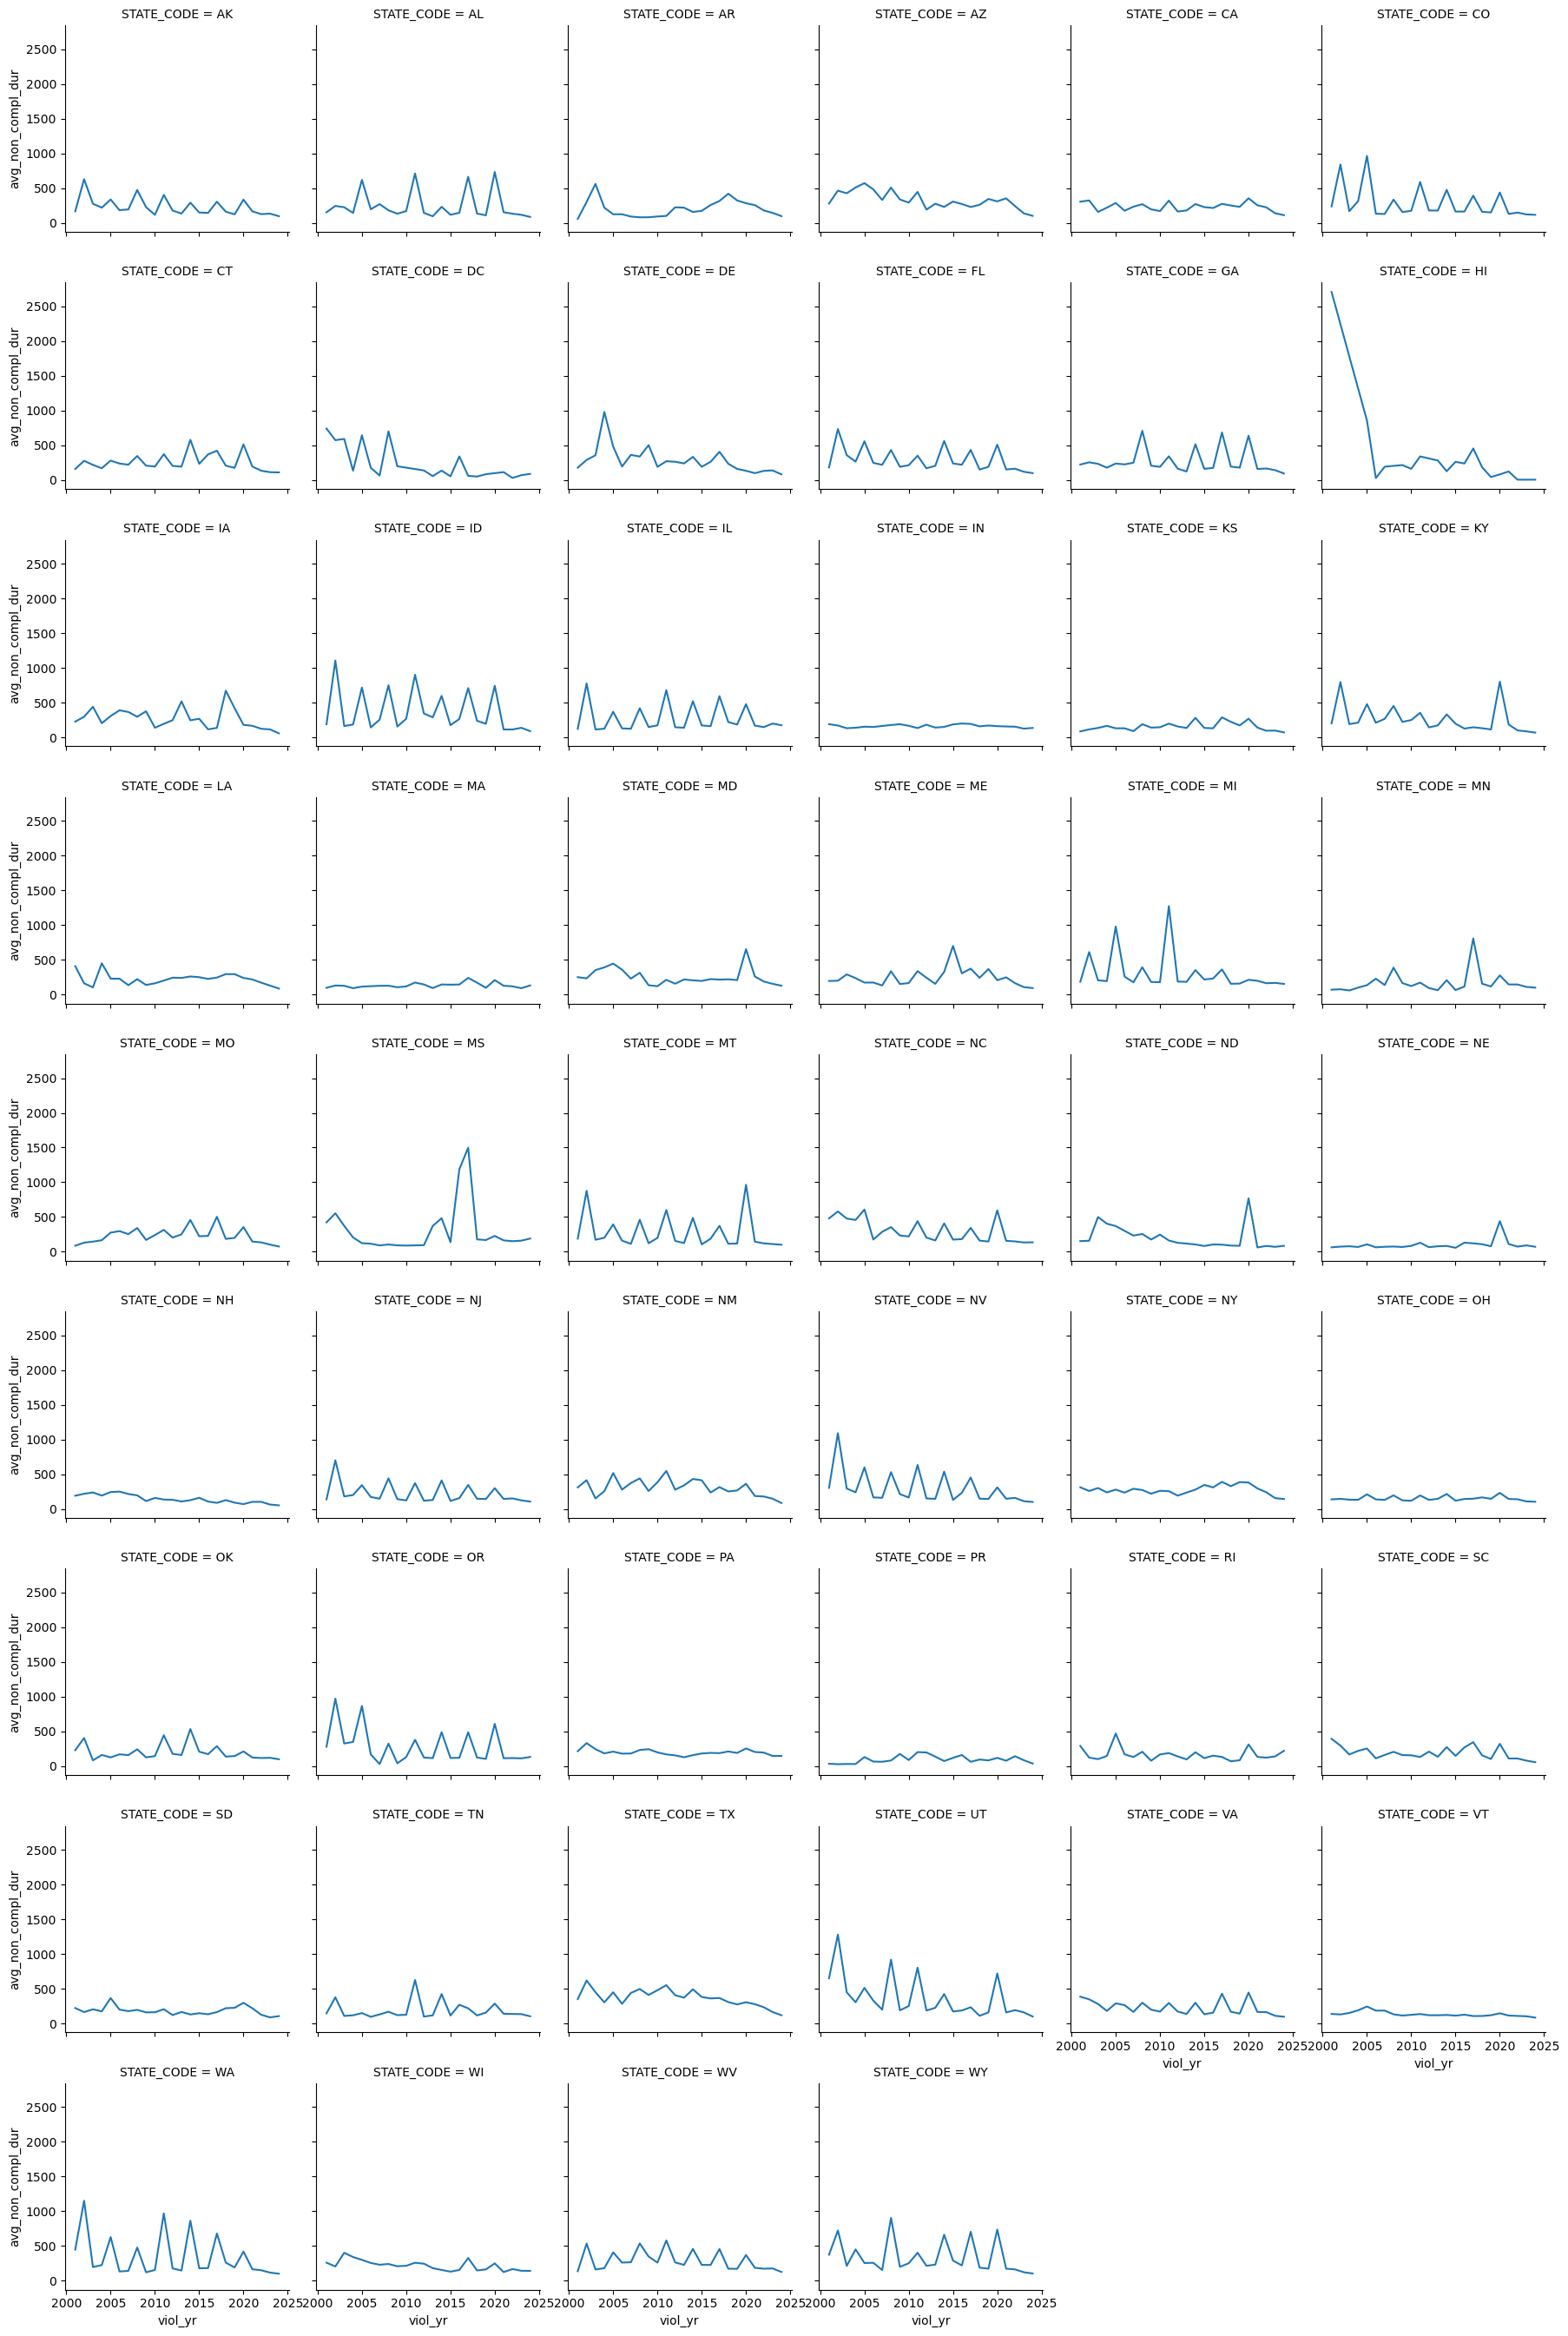

In [104]:
# average duration of violation noncompliance ### why these cyclical patterns?
g = sns.FacetGrid(pws_viols_agg_state, col='STATE_CODE', col_wrap=6)
g.map(sns.lineplot, 'viol_yr', 'avg_non_compl_dur')
plt.savefig('avg_non_compl_dur_yr_states.png', bbox_inches='tight')

### Health-based violations

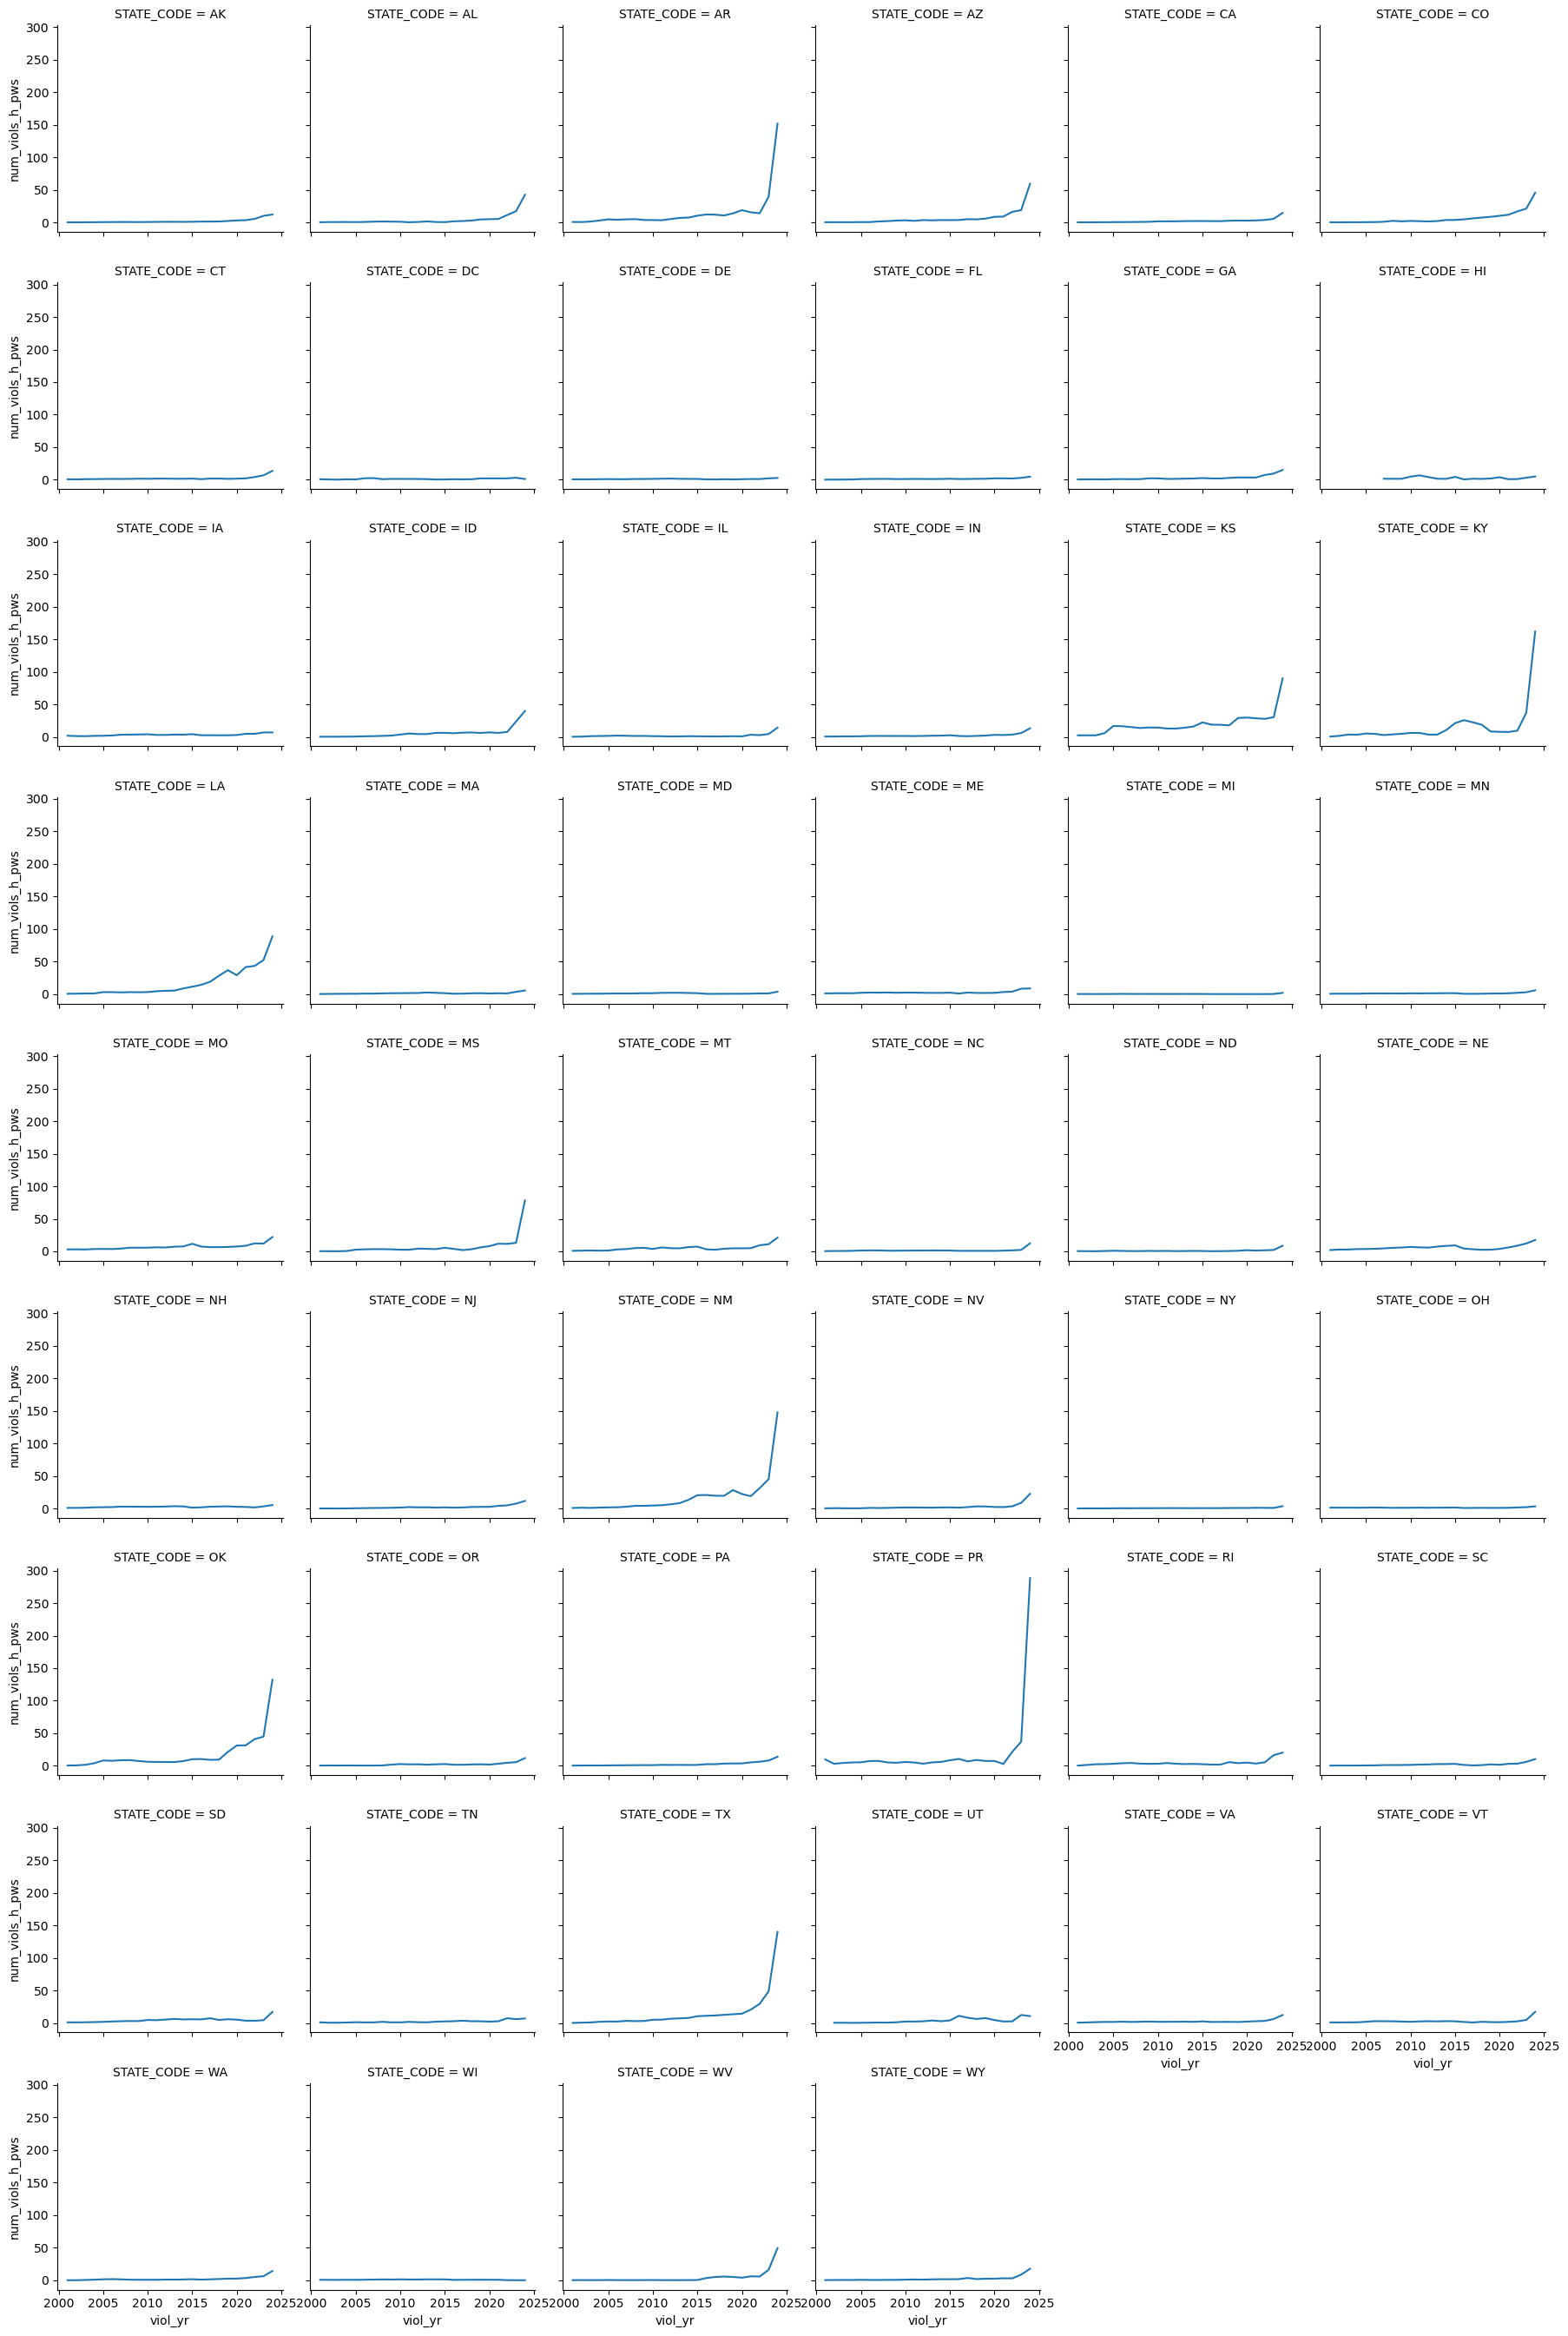

In [105]:
# number of health-based violations per pws
g = sns.FacetGrid(pws_viols_agg_state, col='STATE_CODE', col_wrap=6)
g.map(sns.lineplot, 'viol_yr', 'num_viols_h_pws')
plt.savefig('num_viols_h_pws_yr_states.png', bbox_inches='tight')

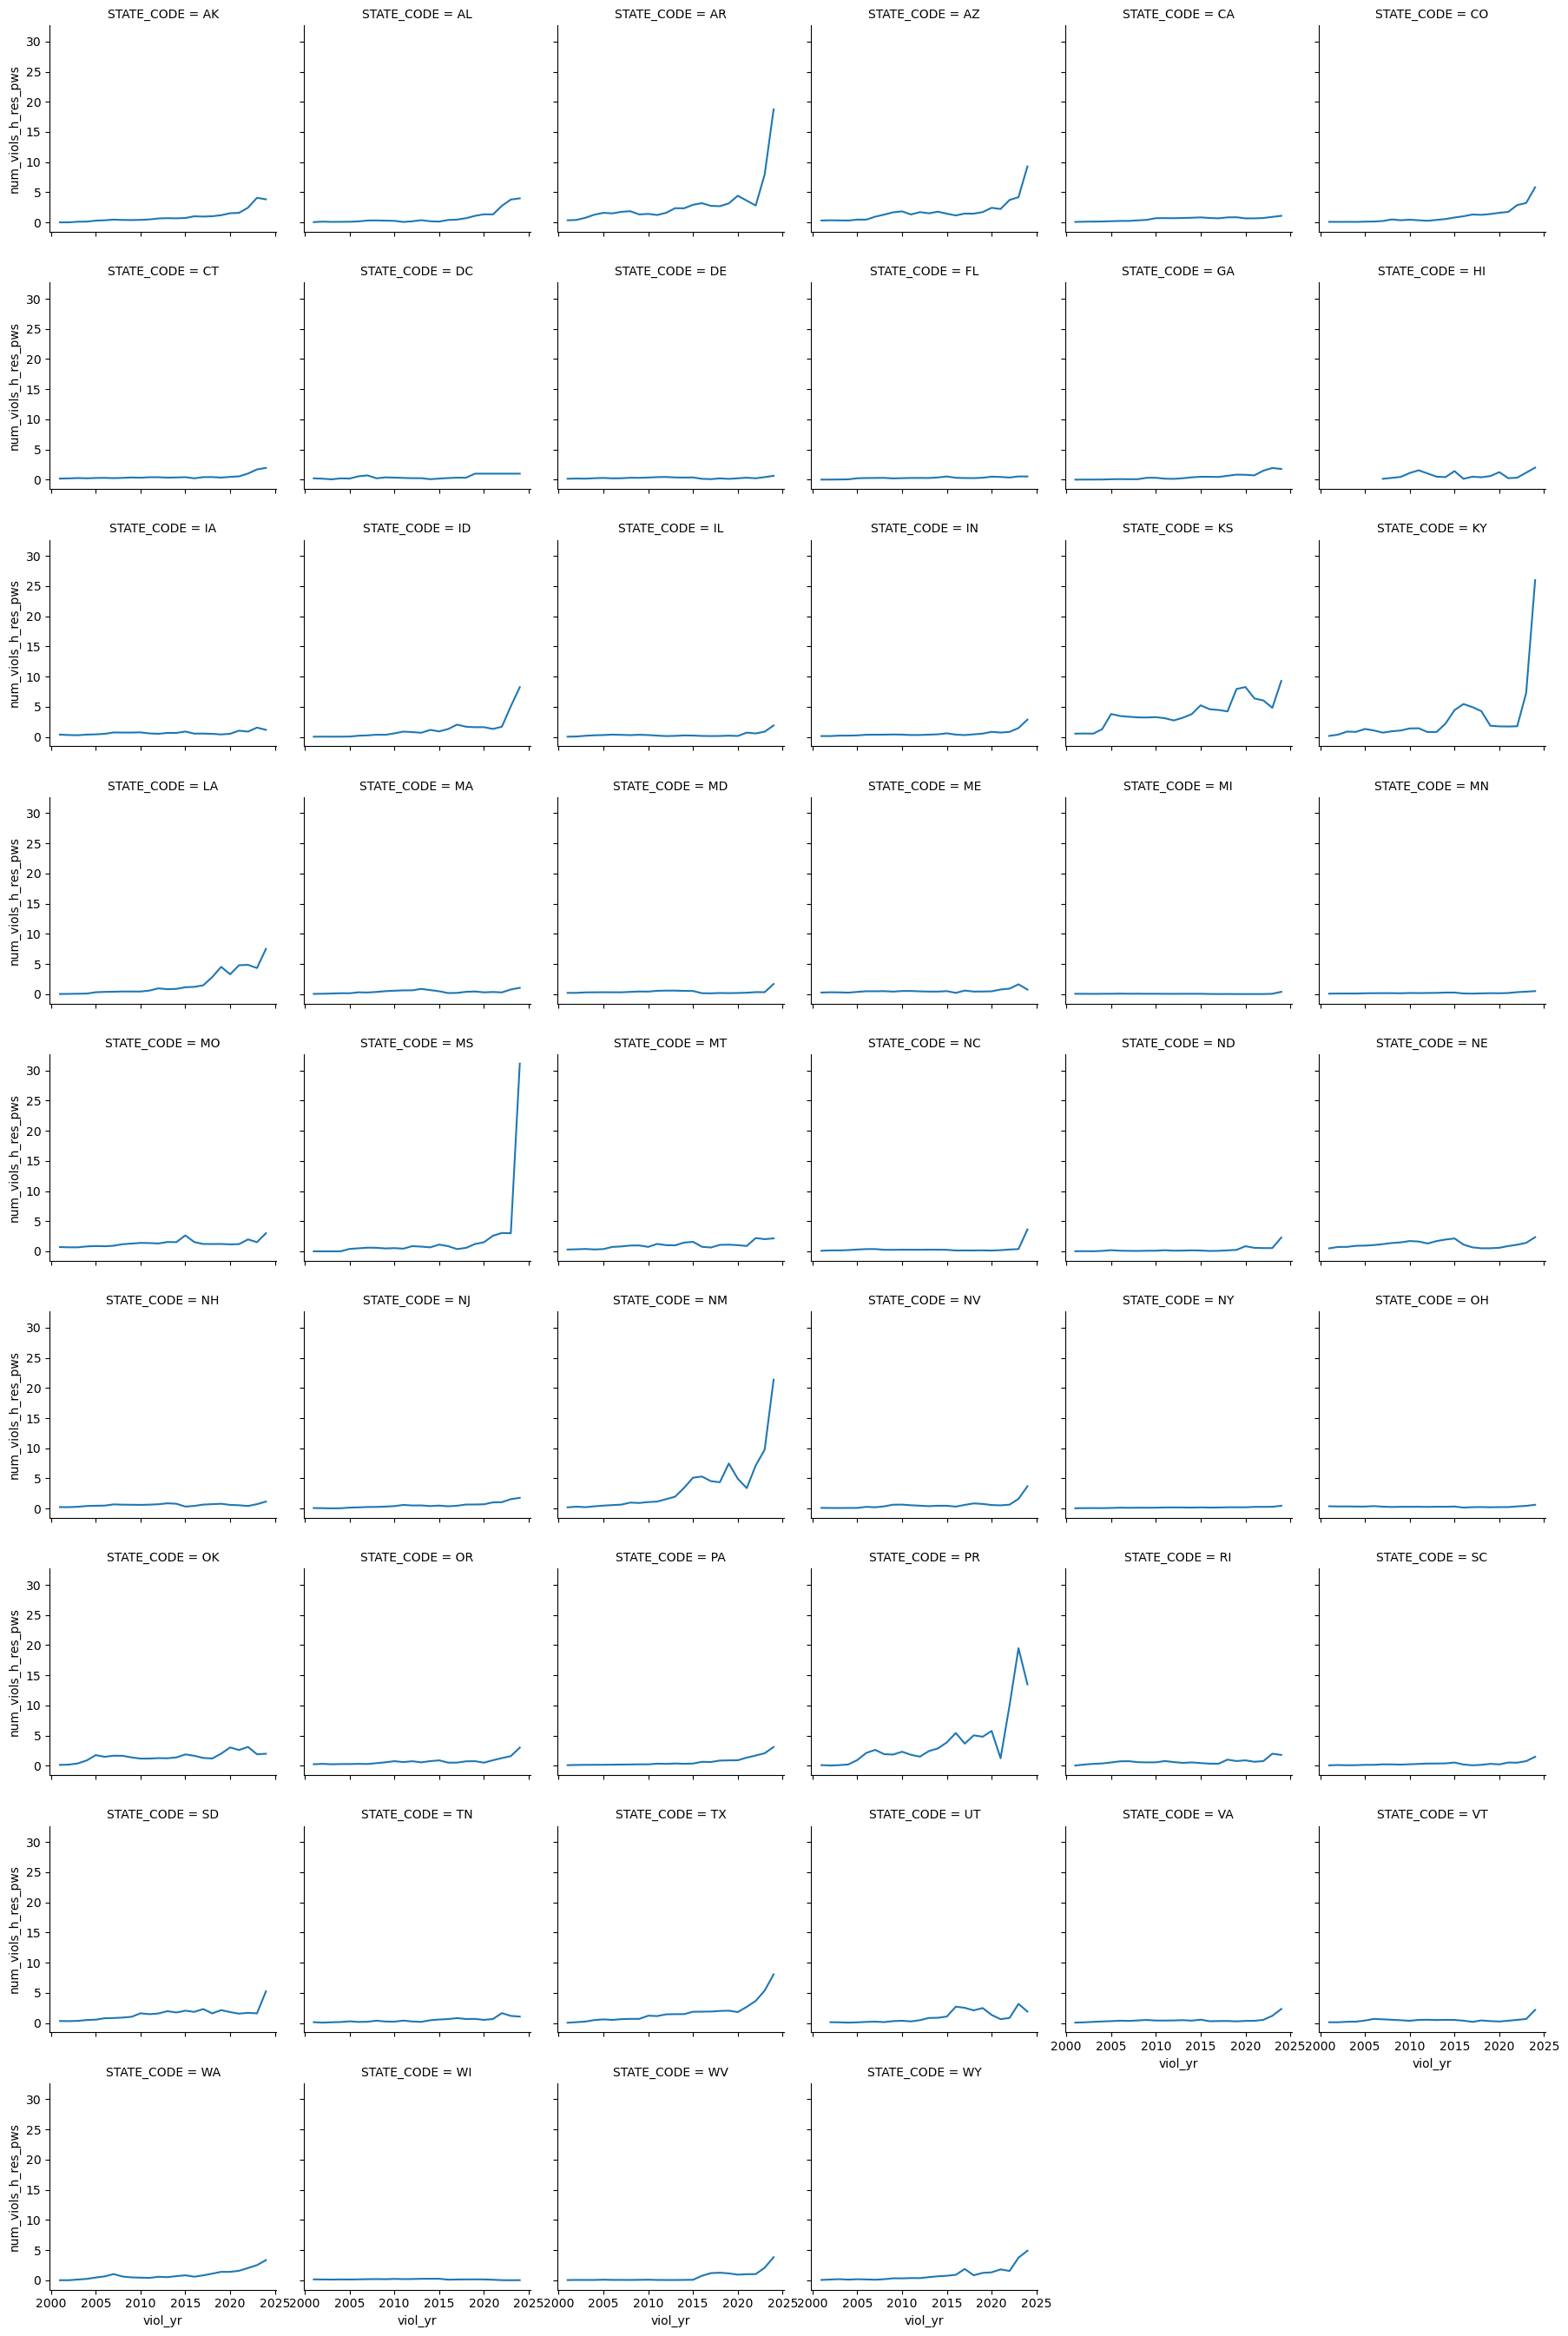

In [106]:
# number of health-based violations resolving per pws
g = sns.FacetGrid(pws_viols_agg_state, col='STATE_CODE', col_wrap=6)
g.map(sns.lineplot, 'viol_yr', 'num_viols_h_res_pws')
plt.savefig('num_viols_h_res_pws_yr_states.png', bbox_inches='tight')

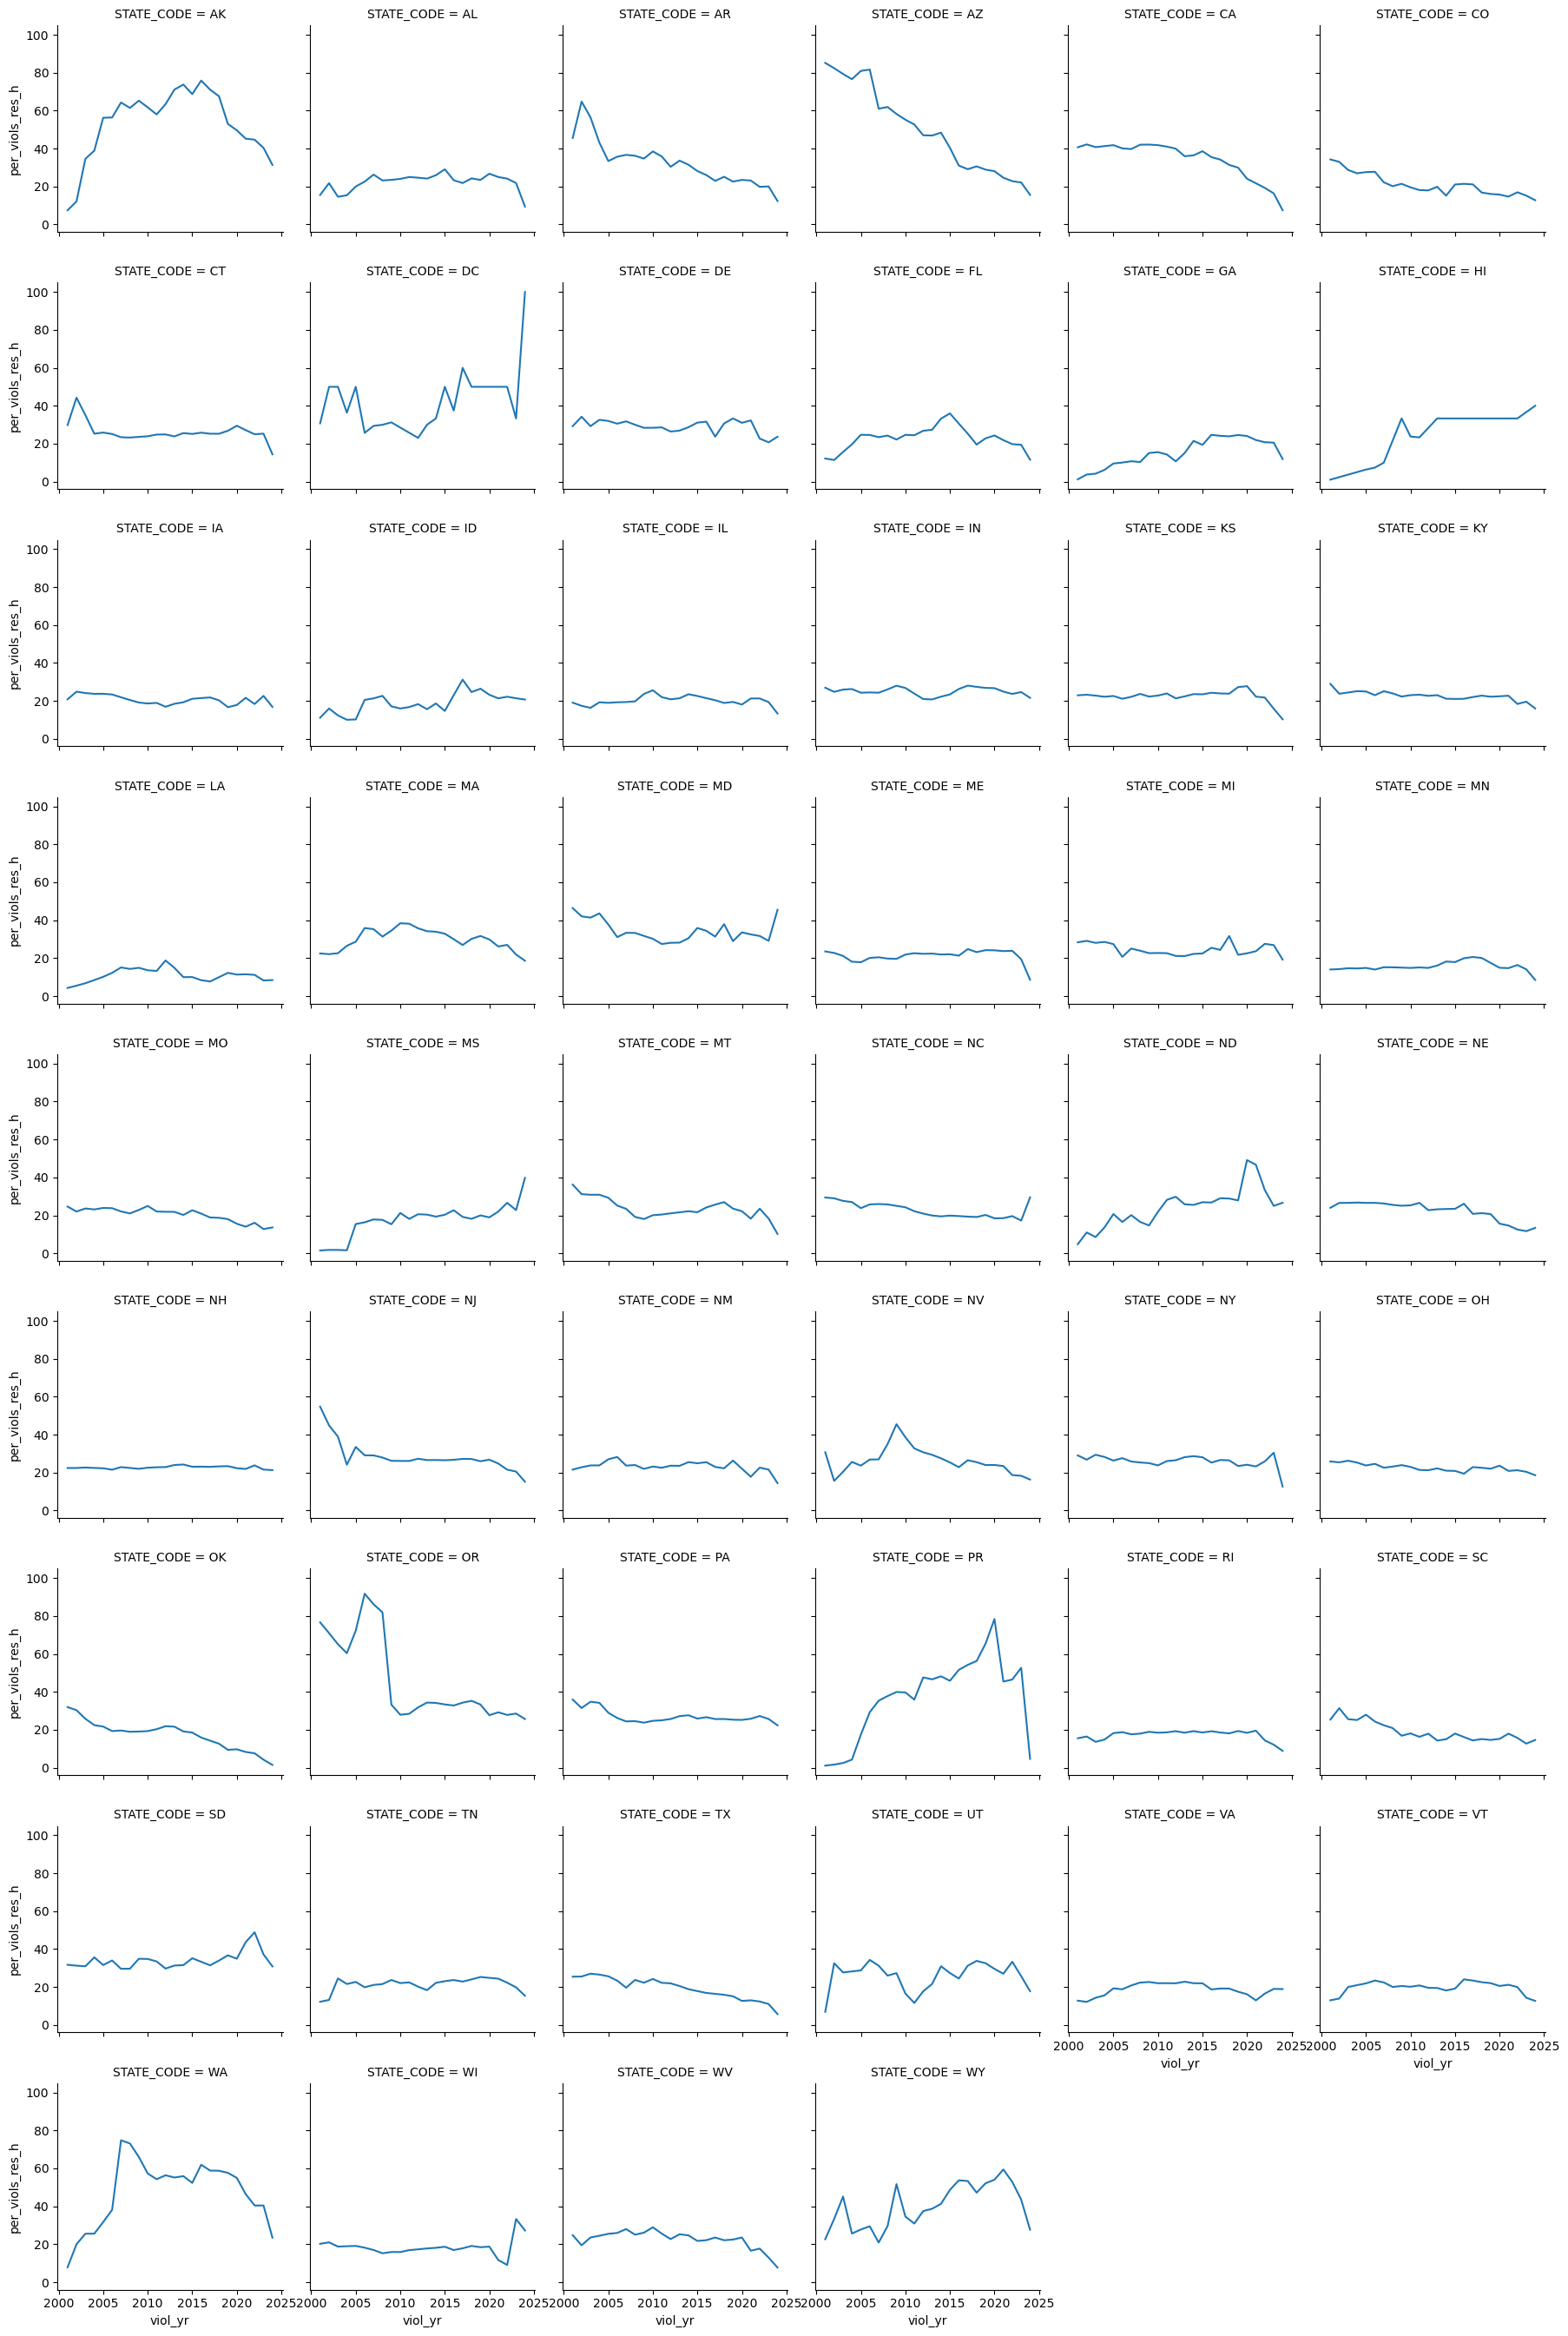

In [107]:
# percentage of health-based violations resolving
g = sns.FacetGrid(pws_viols_agg_state, col='STATE_CODE', col_wrap=6)
g.map(sns.lineplot, 'viol_yr', 'per_viols_res_h')
plt.savefig('per_viols_res_h_yr_states.png', bbox_inches='tight')

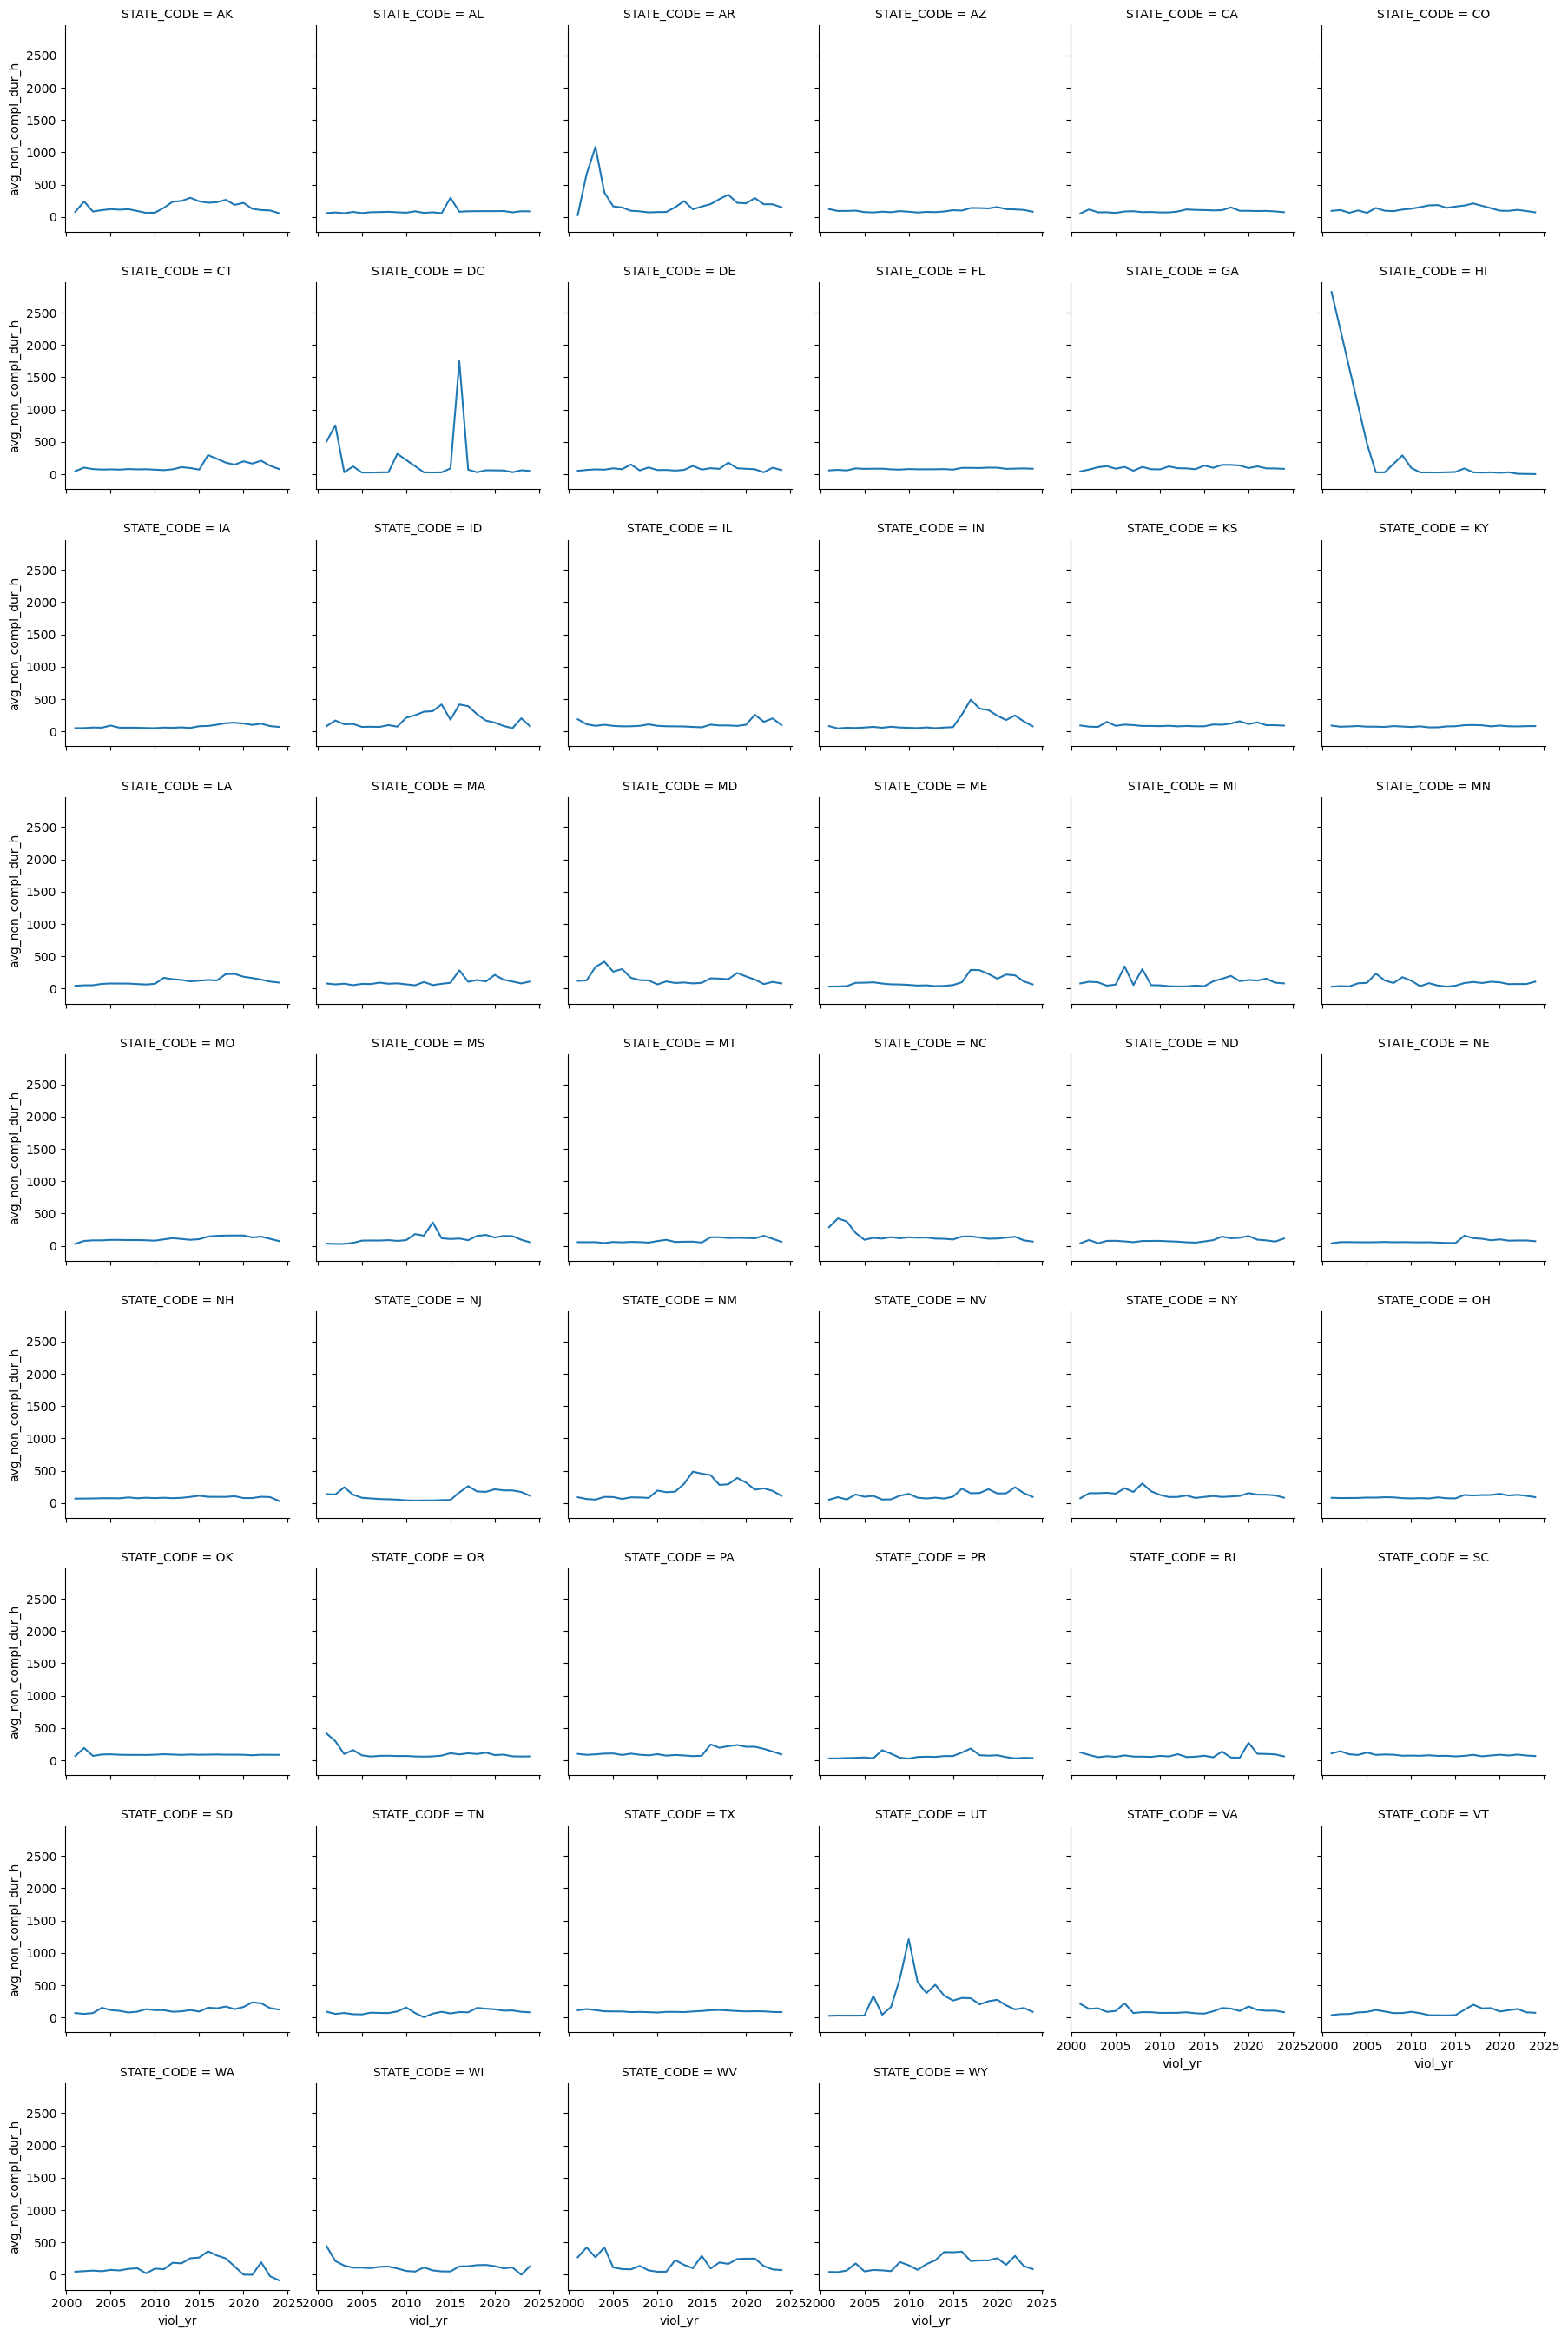

In [108]:
# average duration of health-based violation noncompliance
g = sns.FacetGrid(pws_viols_agg_state, col='STATE_CODE', col_wrap=6)
g.map(sns.lineplot, 'viol_yr', 'avg_non_compl_dur_h')
plt.savefig('avg_non_compl_dur_h_yr_states.png', bbox_inches='tight')

## Violations & Enforcement by State -- Averaged Over Entire Duration

In [109]:
# state averages over the entire time period
pws_viols_state_avgs = pws_viols_agg_state.groupby('STATE_CODE').mean().drop(['viol_yr','num_pws_yr'], axis=1)
pws_viols_state_avgs

num_viols  num_viols_res  per_viols_res  avg_non_compl_dur  \
STATE_CODE                                                                  
AK           7533.875000    5210.291667      69.839125         231.750000   
AL           1806.583333     482.041667      26.925604         245.833333   
AR           2053.416667     716.375000      35.784579         203.250000   
AZ           8781.958333    5735.333333      62.183407         329.041667   
CA           7081.541667    3054.666667      42.709470         231.000000   
CO          10293.208333    3098.583333      29.729231         285.416667   
CT           9168.958333    3240.666667      35.051300         256.250000   
DC             29.000000      11.904762      41.050462         241.190476   
DE            366.250000     115.166667      31.662473         285.083333   
FL           5784.375000    1754.125000      30.129656         291.000000   
GA           3862.416667     964.916667      25.139771         269.291667   
HI             63.777778      16.944444      28.050088         351.111111   
IA           3902.541667    1001.458333      25.433878         270.208333   
ID           3956.750000    1209.458333      33.233370         367.875000   
IL          13838.666667    3812.041667      27.247352         269.458333   
IN          14868.708333    3833.208333      25.717664         161.083333   
KS           2941.083333     841.208333      28.850989         154.500000   
KY           2019.291667     529.458333      26.369352         259.333333   
LA           4928.375000     829.916667      16.030186         222.000000   
MA           2605.958333     850.166667      31.326932         132.416667   
MD           2186.416667     787.375000      36.428648         252.458333   
ME           6973.958333    1694.750000      24.858499         246.333333   
MI          10249.208333    3590.250000      35.403375         307.125000   
MN           2636.333333     543.750000      20.865686         168.708333   
MO          10314.750000    2868.291667      27.726680         228.916667   
MS          21247.416667    5677.791667      28.479380         303.291667   
MT          11934.083333    3708.666667      30.702474         275.083333   
NC          28800.166667    8844.541667      25.595758         303.125000   
ND            693.458333     195.041667      27.624769         202.083333   
NE           1695.875000     446.291667      25.280551         100.125000   
NH           3872.375000    1017.291667      26.236184         145.416667   
NJ           8401.375000    3002.458333      34.961882         223.333333   
NM           5976.583333    2076.375000      34.322368         309.750000   
NV           2716.833333     895.666667      33.955923         299.000000   
NY          22676.000000    7692.833333      33.325773         275.666667   
OH          11128.708333    2969.166667      25.146435         150.375000   
OK          14828.833333    3716.125000      26.981112         200.291667   
OR           7101.541667    5322.708333      75.571002         277.125000   
PA          47111.375000   15285.333333      32.780164         198.458333   
PR           5206.333333    1115.750000      27.082173          97.583333   
RI           1168.166667     258.958333      22.465600         167.208333   
SC           1179.458333     309.583333      24.359476         191.458333   
SD           1469.208333     605.333333      41.536611         181.458333   
TN           2125.041667     500.666667      23.643960         186.041667   
TX          33276.125000    8831.708333      27.688357         369.958333   
UT           6113.666667    2193.208333      40.808694         370.875000   
VA           7295.125000    1823.625000      25.177747         228.291667   
VT           6033.458333    1349.041667      22.307705         133.458333   
WA          13238.791667   11511.750000      77.654809         344.000000   
WI           8369.708333    2342.916667      26.008725         217.666667   
WV         

In [110]:
# export state data for mapping in GIS
pws_viols_state_avgs.to_csv('pws_viols_state_avgs.csv')

### Look at some rankings and map results

In [111]:
# import state boundaries
file = r"C:\Users\jenni\Workspaces\Projects\edgi\soe_report\data\boundaries\cb_2018_us_state_500k\cb_2018_us_state_500k.shp" # https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
state_bds = gpd.read_file(file)
state_bds = state_bds.rename(columns={'STUSPS':'STATE_CODE'})
# join violations stats to state boundaries
state_bds = state_bds.merge(pws_viols_state_avgs, on='STATE_CODE')

In [112]:
# top 10 most violations per pws
pws_viols_state_avgs.sort_values('num_viols_pws', ascending=False)['num_viols_pws'].head(10)

STATE_CODE
PR    139.708212
MS    123.734175
OK     91.645442
TX     77.158268
AL     70.300027
KS     64.317391
WV     63.274296
MT     61.571188
NM     57.201115
AZ     52.423748
Name: num_viols_pws, dtype: float64

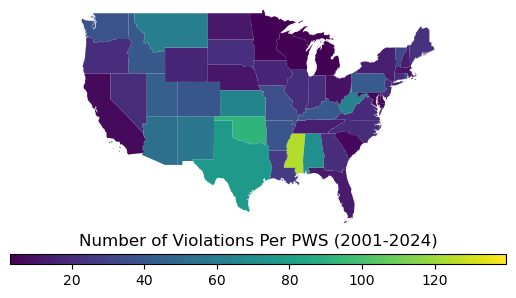

In [113]:
# map
fig, ax = plt.subplots(1,1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.3)
ax.set_xlim([-124.725839, -66.949895])
ax.set_ylim([24.498131, 49.384358])

state_bds.plot(
    column='num_viols_pws', 
    legend=True, 
    ax=ax, 
    cax=cax,
    legend_kwds={'orientation': 'horizontal'}
)

ax.set_axis_off()
plt.title('Number of Violations Per PWS (2001-2024)')
plt.savefig('num_viols_pws_map.png')#, bbox_inches='tight')
plt.show()

In [114]:
# top 10 most health violations per pws
pws_viols_state_avgs.sort_values('num_viols_h_pws', ascending=False)['num_viols_h_pws'].head(10)

STATE_CODE
PR    19.862208
KS    19.681348
NM    18.054494
OK    17.458539
LA    17.075664
KY    15.861849
TX    15.062300
AR    14.803884
MS     7.347267
MO     7.018346
Name: num_viols_h_pws, dtype: float64

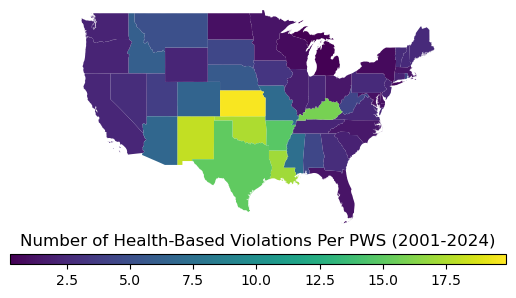

In [115]:
# map
fig, ax = plt.subplots(1,1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.3)
ax.set_xlim([-124.725839, -66.949895])
ax.set_ylim([24.498131, 49.384358])

state_bds.plot(
    column='num_viols_h_pws', 
    legend=True, 
    ax=ax, 
    cax=cax,
    legend_kwds={'orientation': 'horizontal'}
)

ax.set_axis_off()
plt.title('Number of Health-Based Violations Per PWS (2001-2024)')
plt.savefig('num_viols_h_pws_map.png', bbox_inches='tight')
plt.show()

In [116]:
# top 10 longest noncompliance duration
pws_viols_state_avgs.sort_values('avg_non_compl_dur', ascending=False)['avg_non_compl_dur'].head(10)

STATE_CODE
UT    370.875000
TX    369.958333
ID    367.875000
HI    351.111111
WA    344.000000
WY    339.375000
AZ    329.041667
NM    309.750000
MI    307.125000
MS    303.291667
Name: avg_non_compl_dur, dtype: float64

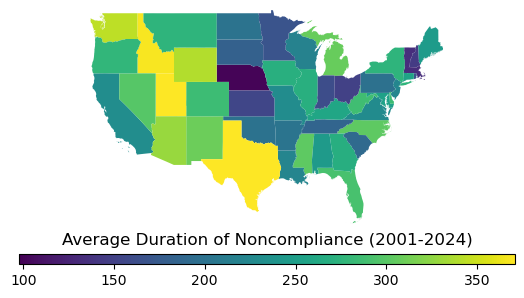

In [117]:
# map
fig, ax = plt.subplots(1,1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.3)
ax.set_xlim([-124.725839, -66.949895])
ax.set_ylim([24.498131, 49.384358])

state_bds.plot(
    column='avg_non_compl_dur', 
    legend=True, 
    ax=ax, 
    cax=cax,
    legend_kwds={'orientation': 'horizontal'}
)

ax.set_axis_off()
plt.title('Average Duration of Noncompliance (2001-2024)')
plt.savefig('avg_non_compl_dur_map.png', bbox_inches='tight')
plt.show()

In [118]:
# top 10 longest health-based noncompliance duration
pws_viols_state_avgs.sort_values('avg_non_compl_dur_h', ascending=False)['avg_non_compl_dur_h'].head(10)

STATE_CODE
UT    267.375000
AR    235.041667
HI    227.444444
NM    206.083333
DC    196.380952
ID    180.916667
WV    176.291667
WY    167.416667
MD    158.958333
AK    156.791667
Name: avg_non_compl_dur_h, dtype: float64

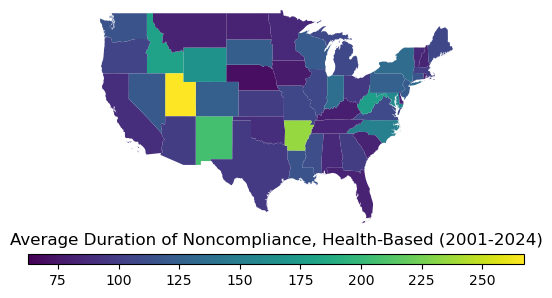

In [119]:
# map
fig, ax = plt.subplots(1,1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.3)
ax.set_xlim([-124.725839, -66.949895])
ax.set_ylim([24.498131, 49.384358])

state_bds.plot(
    column='avg_non_compl_dur_h', 
    legend=True, 
    ax=ax, 
    cax=cax,
    legend_kwds={'orientation': 'horizontal'}
)

ax.set_axis_off()
plt.title('Average Duration of Noncompliance, Health-Based (2001-2024)')
plt.savefig('avg_non_compl_dur_h_map.png', bbox_inches='tight')
plt.show()

In [120]:
# top 10 lowest percentage violations resolved
pws_viols_state_avgs.sort_values('per_viols_res', ascending=True)['per_viols_res'].head(10)

STATE_CODE
LA    16.030186
WV    19.930227
MN    20.865686
VT    22.307705
RI    22.465600
TN    23.643960
SC    24.359476
ME    24.858499
GA    25.139771
OH    25.146435
Name: per_viols_res, dtype: float64

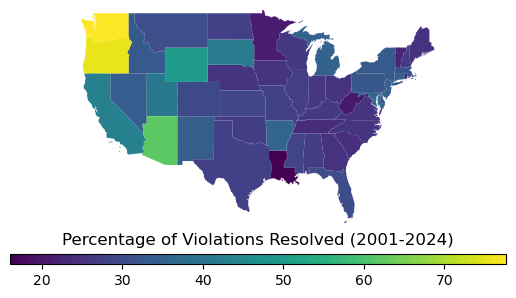

In [121]:
# map
fig, ax = plt.subplots(1,1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.3)
ax.set_xlim([-124.725839, -66.949895])
ax.set_ylim([24.498131, 49.384358])

state_bds.plot(
    column='per_viols_res', 
    legend=True, 
    ax=ax, 
    cax=cax,
    legend_kwds={'orientation': 'horizontal'}
)

ax.set_axis_off()
plt.title('Percentage of Violations Resolved (2001-2024)')
plt.savefig('per_viols_res_map.png', bbox_inches='tight')
plt.show()

In [122]:
# top 10 lowest percentage health violations resolved
pws_viols_state_avgs.sort_values('per_viols_res_h', ascending=True)['per_viols_res_h'].head(10)

STATE_CODE
LA    10.899540
GA    15.191974
MN    15.661775
RI    17.249162
OK    17.262493
MS    17.490768
WI    18.414644
VA    18.765552
ID    19.013410
SC    19.037744
Name: per_viols_res_h, dtype: float64

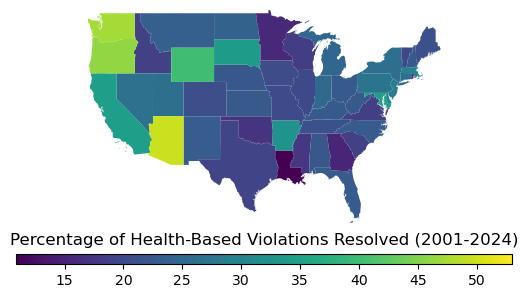

In [123]:
# map
fig, ax = plt.subplots(1,1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.3)
ax.set_xlim([-124.725839, -66.949895])
ax.set_ylim([24.498131, 49.384358])

state_bds.plot(
    column='per_viols_res_h', 
    legend=True, 
    ax=ax, 
    cax=cax,
    legend_kwds={'orientation': 'horizontal'}
)

ax.set_axis_off()
plt.title('Percentage of Health-Based Violations Resolved (2001-2024)')
plt.savefig('per_viols_res_h_map.png', bbox_inches='tight')
plt.show()

# Site Visit Analysis

## Prep the site visit data

In [124]:
# Load site visit data
path = r"C:\Users\jenni\Workspaces\Projects\edgi\soe_report\data\sdwa\SDWA_latest_downloads\SDWA_SITE_VISITS.csv"
visits = pd.read_csv(path, parse_dates=['VISIT_DATE'])
# look at data fields
visits.columns

Index(['SUBMISSIONYEARQUARTER', 'PWSID', 'VISIT_ID', 'VISIT_DATE',
       'AGENCY_TYPE_CODE', 'VISIT_REASON_CODE', 'MANAGEMENT_OPS_EVAL_CODE',
       'SOURCE_WATER_EVAL_CODE', 'SECURITY_EVAL_CODE', 'PUMPS_EVAL_CODE',
       'OTHER_EVAL_CODE', 'COMPLIANCE_EVAL_CODE',
       'DATA_VERIFICATION_EVAL_CODE', 'TREATMENT_EVAL_CODE',
       'FINISHED_WATER_STOR_EVAL_CODE', 'DISTRIBUTION_EVAL_CODE',
       'FINANCIAL_EVAL_CODE', 'VISIT_COMMENTS', 'FIRST_REPORTED_DATE',
       'LAST_REPORTED_DATE'],
      dtype='object')

In [125]:
# Map the visit reason codes 
reasons = sdwa_ref_codes.loc[sdwa_ref_codes["VALUE_TYPE"]=='VISIT_REASON_CODE'].set_index("VALUE_CODE")[["VALUE_DESCRIPTION"]].to_dict()["VALUE_DESCRIPTION"]
visits['VISIT_REASON_CODE'] = visits['VISIT_REASON_CODE'].astype(str).map(reasons)

# Map some other codes that aren't in the csv
# Map evaluation results categories
eval_results_dict = {'M':'Minor deficiencies',
                     'N':'No deficiencies or recommendations',
                     'R':'Recommendations made',
                     'S':'Significant deficiencies',
                     'X':'Not evaluated',
                     'Z':'Not applicable',
                     'D':'Sanitary defect'
                    }

evals = ['MANAGEMENT_OPS_EVAL_CODE', 'SOURCE_WATER_EVAL_CODE', 'SECURITY_EVAL_CODE', 'PUMPS_EVAL_CODE',
         'OTHER_EVAL_CODE', 'COMPLIANCE_EVAL_CODE', 'DATA_VERIFICATION_EVAL_CODE', 'TREATMENT_EVAL_CODE',
         'FINISHED_WATER_STOR_EVAL_CODE', 'DISTRIBUTION_EVAL_CODE', 'FINANCIAL_EVAL_CODE']

for eval in evals:
    visits[eval] = visits[eval].astype(str).map(eval_results_dict)

# Map agencies
agency_dict = {'NULL':'Unknown Agency Type','AR':'Alaskan Remote Village','AT':'Authority','BR':'Borough',
               'CM':'Commission','CN':'County','CT':'City','DS':'District','FD':'Federal','MN':'Municipality',
               'NA':'Native American Tribe','PR':'Parish','RG':'Region','SA':'State Administrative District',
               'SD':'School District','SR':'State Administrative Region','ST':'State','TW':'Town','WD':'Water District',
               'SC':'State Contractor','TA':'Non-State Provider Engineering/Technical Assistance Firm','WS':'Water System'
              }
visits['AGENCY_TYPE_CODE'] = visits['AGENCY_TYPE_CODE'].astype(str).map(agency_dict)


In [126]:
# Join the visits data to the PWS data
pws_visits = sdwa_pws.merge(visits, on='PWSID')

# Filter visits to those occurring from 2001-2024
pws_visits = pws_visits[(pws_visits['VISIT_DATE']>'12-31-2000') & (pws_visits['VISIT_DATE']<'01-01-2025')]

# Add a column to record the site visit date year value only
pws_visits['visit_yr'] = pws_visits['VISIT_DATE'].dt.year
pws_visits['visit_yr'] = pws_visits['visit_yr'].astype(int)

print(f'There were {len(pws_visits)} site visits at {len(pws_visits['PWSID'].unique())} water systems from 2000-2024')

There were 1709303 site visits at 199678 water systems from 2000-2024


In [127]:
# filter the df to exclude visits to inactive pws
pws_visits = pws_visits[(pws_visits['visit_yr'] < pws_visits['PWS_DEACTIVATION_DATE'])|(pws_visits['PWS_DEACTIVATION_DATE'].isna() == True)]

## Number of Site Visits Per Year

**Note** these are total visits, not number of unique PWS visited

In [128]:
# Count site visits per year by PWS type 
# This is one place where there seemed to be a notable difference between CWS and other system types
# create a df of site visit counts grouped by year and system type
visits_by_year = pd.DataFrame(pws_visits.groupby(['visit_yr','PWS_TYPE_CODE']).count().rename(columns={'VISIT_ID':'num_visits'})['num_visits'])

In [129]:
# Format site visits per year for stacked bar chart
years = range(2001,2025)
visit_counts = {'CWS':[], 'NTNCWS':[], 'TNCWS':[]}

# loop through the years
for year in years:
    # append visit counts to corresponding lists
    visit_counts['CWS'].append(int(visits_by_year.loc[year,'CWS'].iloc[0]))
    visit_counts['NTNCWS'].append(int(visits_by_year.loc[year,'NTNCWS'].iloc[0]))
    visit_counts['TNCWS'].append(int(visits_by_year.loc[year,'TNCWS'].iloc[0]))

# convert lists to np arrays
visit_counts['CWS'] = np.array(visit_counts['CWS'])
visit_counts['NTNCWS'] = np.array(visit_counts['NTNCWS'])
visit_counts['TNCWS'] = np.array(visit_counts['TNCWS'])

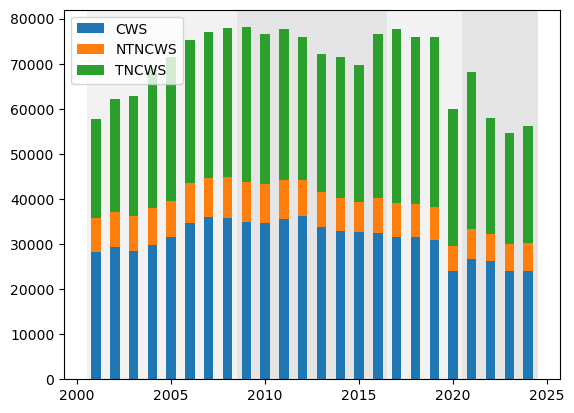

In [130]:
# plot the data
width = 0.5

plt.bar(years, visit_counts['CWS'], width, label='CWS')
plt.bar(years, visit_counts['NTNCWS'], width, bottom=visit_counts['CWS'], label='NTNCWS')
plt.bar(years, visit_counts['TNCWS'], width, bottom=visit_counts['CWS']+visit_counts['NTNCWS'], label='TNCWS')

# add the spans for presidential administrations
pres_spans()

#ax.set_title("Number Of Site Visits By System Type")
plt.legend(bbox_to_anchor=(0,1), loc='upper left')

plt.savefig('num_visits_yr_type_bar.png', bbox_inches='tight')
plt.show()

In [131]:
# add the total number of visits per year
total_visits = pd.DataFrame(pws_visits.groupby('visit_yr').count().rename(columns={'VISIT_ID':'num_visits'})['num_visits'])
total_visits['PWS_TYPE_CODE'] = 'Annual Total'
total_visits = total_visits.reset_index().set_index(['visit_yr','PWS_TYPE_CODE'])
visits_with_tot = pd.concat([visits_by_year,total_visits])

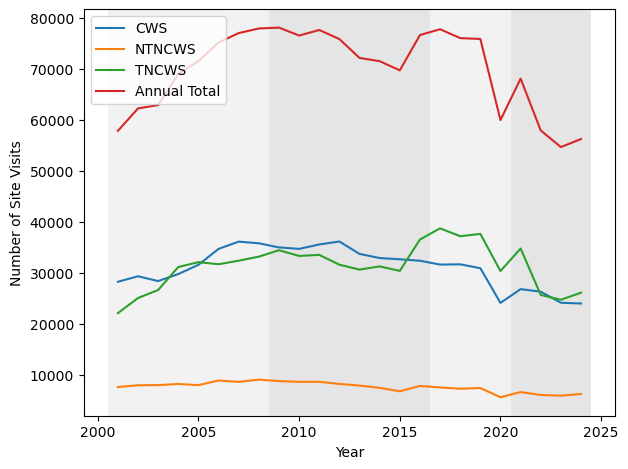

In [192]:
# make a plot of site visits by year with total
sns.lineplot(data=visits_with_tot, x='visit_yr', y='num_visits', hue='PWS_TYPE_CODE')

# add the spans for presidential administrations
pres_spans()

plt.tight_layout()
plt.legend(bbox_to_anchor=(0,1), loc='upper left')
plt.ylabel('Number of Site Visits')
plt.xlabel('Year')
plt.savefig('num_visits_yr_type_line.png')

## What percentage of PWS in each site type gets a visit each year?

**Note** these are unique PWS visits

In [133]:
# group visits per pws by year
per_visits_year = pws_visits.groupby(['visit_yr','PWS_TYPE_CODE','PWSID']).count().reset_index().rename(columns={'VISIT_ID':'num_visits'})[['visit_yr','PWS_TYPE_CODE','PWSID','num_visits']]
# count pws visited per year
per_visits_year = per_visits_year.groupby(['visit_yr','PWS_TYPE_CODE']).count().reset_index().rename(columns={'num_visits':'num_pws_visited'}).drop(columns='PWSID')
per_visits_year

visit_yr PWS_TYPE_CODE  num_pws_visited
0       2001           CWS            16961
1       2001        NTNCWS             5092
2       2001         TNCWS            16082
3       2002           CWS            18097
4       2002        NTNCWS             5579
..       ...           ...              ...
67      2023        NTNCWS             5165
68      2023         TNCWS            21373
69      2024           CWS            19177
70      2024        NTNCWS             5294
71      2024         TNCWS            22541

[72 rows x 3 columns]

In [134]:
# add a column for percentage of pws visited
# use num_pws_yr df already created
num_pws_yr

num_active_pws  num_active_cws  num_active_ntncws  num_active_tncws
deac_yr                                                                     
2024.0           145044           49471              17332             78241
2023.0           148656           49776              17848             81032
2022.0           156486           50107              19037             87342
2021.0           158576           50439              19336             88801
2020.0           160836           50748              19668             90420
2019.0           163312           51156              20049             92107
2018.0           165982           51611              20462             93909
2017.0           169038           52090              20975             95973
2016.0           171782           52529              21352             97901
2015.0           176405           53501              22131            100773
2014.0           178962           53922              22490            102550
2013.0           181614           54412              22835            104367
2012.0           184413           54937              23230            106246
2011.0           187273           55464              23700            108109
2010.0           190333           56054              24146            110133
2009.0           195939           57489              25187            113263
2008.0           199106           57997              25684            115425
2007.0           203363           58874              26330            118159
2006.0           207481           59692              26962            120827
2005.0           214213           60932              27745            125536
2004.0           218735           61951              28360            128424
2003.0           223459           62653              29125            131681
2002.0           228751           63401              30157            135193
2001.0           234209           64240              31184            138785

In [135]:
# add a column for the num pws by type/year
per_visits_year['num_pws_yr'] = per_visits_year['visit_yr']
# map the values from the df for CWS
per_visits_year.loc[per_visits_year['PWS_TYPE_CODE']=='CWS', 'num_pws_yr'] = per_visits_year.loc[per_visits_year['PWS_TYPE_CODE']=='CWS', 'num_pws_yr'].apply(lambda x: num_pws_yr.loc[x, 'num_active_cws'])
# map the values from the df for NTNCWS
per_visits_year.loc[per_visits_year['PWS_TYPE_CODE']=='NTNCWS', 'num_pws_yr'] = per_visits_year.loc[per_visits_year['PWS_TYPE_CODE']=='NTNCWS', 'num_pws_yr'].apply(lambda x: num_pws_yr.loc[x, 'num_active_ntncws'])
# map the values from the df for TNCWS
per_visits_year.loc[per_visits_year['PWS_TYPE_CODE']=='TNCWS', 'num_pws_yr'] = per_visits_year.loc[per_visits_year['PWS_TYPE_CODE']=='TNCWS', 'num_pws_yr'].apply(lambda x: num_pws_yr.loc[x, 'num_active_tncws'])                                                                                                                                                              

In [136]:
# calculate the percentage
per_visits_year['per_pws_visited'] = (per_visits_year['num_pws_visited'] / per_visits_year['num_pws_yr']) * 100

In [137]:
per_visits_year

visit_yr PWS_TYPE_CODE  num_pws_visited  num_pws_yr  per_pws_visited
0       2001           CWS            16961       64240        26.402553
1       2001        NTNCWS             5092       31184        16.328887
2       2001         TNCWS            16082      138785        11.587708
3       2002           CWS            18097       63401        28.543714
4       2002        NTNCWS             5579       30157        18.499851
..       ...           ...              ...         ...              ...
67      2023        NTNCWS             5165       17848        28.938817
68      2023         TNCWS            21373       81032        26.376000
69      2024           CWS            19177       49471        38.764124
70      2024        NTNCWS             5294       17332        30.544657
71      2024         TNCWS            22541       78241        28.809703

[72 rows x 5 columns]

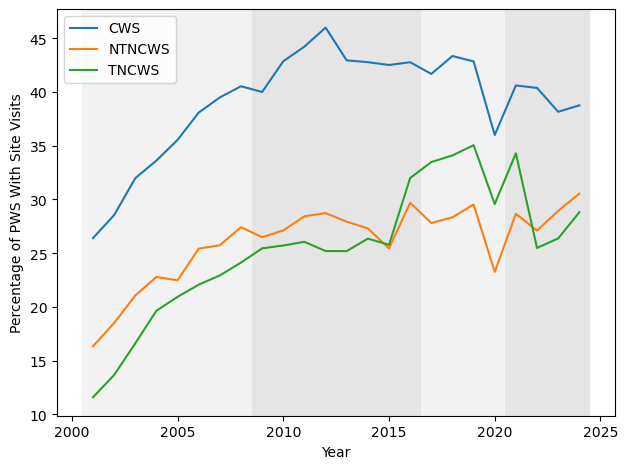

In [193]:
# plot the percentage data
sns.lineplot(data=per_visits_year, x='visit_yr', y='per_pws_visited', hue='PWS_TYPE_CODE')

# add the spans for presidential administrations
pres_spans()

plt.tight_layout()
plt.legend(bbox_to_anchor=(0,1), loc='upper left')
plt.ylabel('Percentage of PWS With Site Visits')
plt.xlabel('Year')
plt.savefig('per_visits_by_year.png')

## What types of visits are these and who is visiting? 

In [139]:
# group visits by type and year
pws_visits_type = pws_visits.groupby(['visit_yr', 'VISIT_REASON_CODE'], as_index=False).count().rename(columns={'VISIT_ID':'num_visits'})[['visit_yr', 'VISIT_REASON_CODE', 'num_visits']]

Text(0, 0.5, 'Number of Visits By Type')

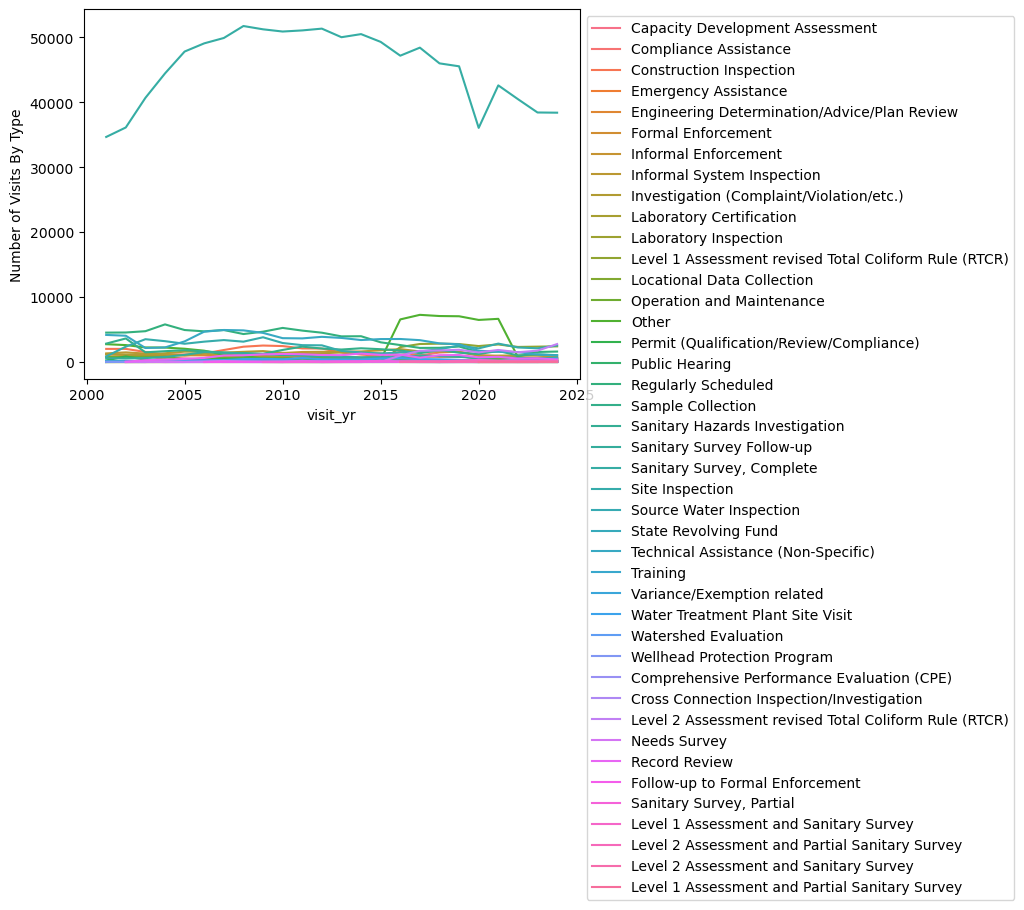

In [140]:
# take a look at the counts over time
sns.lineplot(data=pws_visits_type, x='visit_yr', y='num_visits', hue='VISIT_REASON_CODE')
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.ylabel('Number of Visits By Type')

In [141]:
# So many types. One of them is much more common. 
pws_visits_type[pws_visits_type['num_visits'] == pws_visits_type['num_visits'].max()]

visit_yr          VISIT_REASON_CODE  num_visits
261      2008  Sanitary Survey, Complete       51762

In [142]:
# Sanitary surveys are much more common than any other kind of visit
# Whats the type that becomes a little bit more common than the others around 2016?
pws_visits_type[pws_visits_type['visit_yr']==2016].sort_values(by='num_visits',ascending=False).head(2)

visit_yr          VISIT_REASON_CODE  num_visits
556      2016  Sanitary Survey, Complete       47193
548      2016                      Other        6565

In [143]:
# 'Other' is not super informative

In [144]:
# Who performed the site visits?
pws_visits.groupby('AGENCY_TYPE_CODE').count()['VISIT_ID'].sort_values(ascending=False)

AGENCY_TYPE_CODE
State                            1249937
County                            216884
District                          104828
State Administrative Region        33940
State Administrative District      33506
Region                              8908
Water System                        2786
Federal                              412
Water District                       377
School District                       22
Commission                             5
Name: VISIT_ID, dtype: int64

In [145]:
# States are overwhelmingly responsible for site visits
# States + other sub-federal entities account for vast majority

In [146]:
# Who performed the sanitary survey visits?
pws_visits[pws_visits['VISIT_REASON_CODE']=='Sanitary Survey, Complete'][['AGENCY_TYPE_CODE']].value_counts()

AGENCY_TYPE_CODE             
State                            817668
County                           142114
District                          76499
State Administrative Region       17748
State Administrative District     17614
Region                             7717
Federal                             392
School District                      22
Commission                            5
Water System                          1
Name: count, dtype: int64

In [147]:
# Same pattern for visits overall and sanitary surveys -- the most common type:
# 1. Local authorities, particularly states, do the visits. Makes total sense because most states have implementing authority.
# 2. The number of federal visits is *extremely* low.

### What were the outcomes of the sanitary visits?

Take sanitary survey visits as a subset since they were so much more common that other categories

In [148]:
# Filter for sanitary survey visits (most common type) and outcome categories
outcomes_sanitary = pws_visits[pws_visits['VISIT_REASON_CODE']=='Sanitary Survey, Complete'][['MANAGEMENT_OPS_EVAL_CODE', 'SOURCE_WATER_EVAL_CODE',
                                                                          'SECURITY_EVAL_CODE', 'PUMPS_EVAL_CODE', 'OTHER_EVAL_CODE',
                                                                          'COMPLIANCE_EVAL_CODE', 'DATA_VERIFICATION_EVAL_CODE',
                                                                          'TREATMENT_EVAL_CODE', 'FINISHED_WATER_STOR_EVAL_CODE',
                                                                          'DISTRIBUTION_EVAL_CODE', 'FINANCIAL_EVAL_CODE']].apply(pd.Series.value_counts)
# a bit hard to make sense of as raw numbers instead of percentages, 
for col in outcomes_sanitary.columns:
    outcomes_sanitary[col] = (outcomes_sanitary[col] / outcomes_sanitary[col].sum()) * 100  

# check the math
outcomes_sanitary.sum() 

MANAGEMENT_OPS_EVAL_CODE         100.0
SOURCE_WATER_EVAL_CODE           100.0
SECURITY_EVAL_CODE               100.0
PUMPS_EVAL_CODE                  100.0
OTHER_EVAL_CODE                  100.0
COMPLIANCE_EVAL_CODE             100.0
DATA_VERIFICATION_EVAL_CODE      100.0
TREATMENT_EVAL_CODE              100.0
FINISHED_WATER_STOR_EVAL_CODE    100.0
DISTRIBUTION_EVAL_CODE           100.0
FINANCIAL_EVAL_CODE              100.0
dtype: float64

In [149]:
outcomes_sanitary # of sanitary survey visits

MANAGEMENT_OPS_EVAL_CODE  \
Minor deficiencies                                  7.044828   
No deficiencies or recommendations                 62.963192   
Not applicable                                      3.490569   
Not evaluated                                      14.687770   
Recommendations made                                9.614987   
Sanitary defect                                     0.000304   
Significant deficiencies                            2.198351   

                                    SOURCE_WATER_EVAL_CODE  \
Minor deficiencies                                8.733958   
No deficiencies or recommendations               59.920182   
Not applicable                                    2.979286   
Not evaluated                                    14.758369   
Recommendations made                              9.931628   
Sanitary defect                                   0.008306   
Significant deficiencies                          3.668270   

                                    SECURITY_EVAL_CODE  PUMPS_EVAL_CODE  \
Minor deficiencies                            1.694365         1.789319   
No deficiencies or recommendations           66.091943        68.707864   
Not applicable                               19.487681         9.323855   
Not evaluated                                 9.470347        16.934065   
Recommendations made                          2.910227         2.842277   
Sanitary defect                               0.000177         0.000203   
Significant deficiencies                      0.345260         0.402417   

                                    OTHER_EVAL_CODE  COMPLIANCE_EVAL_CODE  \
Minor deficiencies                         0.433897              1.314491   
No deficiencies or recommendations        39.683336             68.377754   
Not applicable                            29.947871             10.740820   
Not evaluated                             27.825790             15.676442   
Recommendations made                       1.679314              2.918503   
Sanitary defect                            0.000132                   NaN   
Significant deficiencies                   0.429660              0.971990   

                                    DATA_VERIFICATION_EVAL_CODE  \
Minor deficiencies                                     4.888108   
No deficiencies or recommendations                    68.719858   
Not applicable                                         3.812268   
Not evaluated                                         15.459482   
Recommendations made                                   5.370590   
Sanitary defect                                        0.000101   
Significant deficiencies                               1.749593   

                                    TREATMENT_EVAL_CODE  \
Minor deficiencies                             4.927595   
No deficiencies or recommendations            61.119444   
Not applicable                                10.581067   
Not evaluated                                 15.579607   
Recommendations made                           5.705263   
Sanitary defect                                0.001115   
Significant deficiencies                       2.085909   

                                    FINISHED_WATER_STOR_EVAL_CODE  \
Minor deficiencies                                       3.899815   
No deficiencies or recommendations                      64.774153   
Not applicable                                           7.971001   
Not evaluated                                           15.739232   
Recommendations made                                     5.850937   
Sanitary defect                                          0.001317   
Significant deficiencies                                 1.763546   

                                    DISTRIBUTION_EVAL_CODE  \
Minor deficiencies                                5.372594   
No deficiencies or recommendations               66.728233   
Not applicable                                    4.672173 

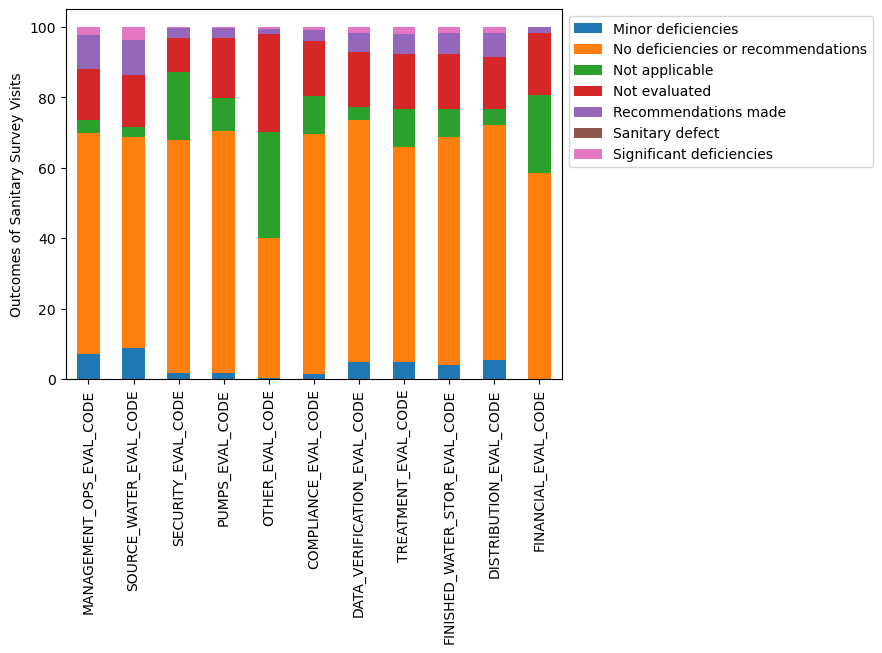

In [150]:
outcomes_sanitary.transpose().plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.ylabel('Outcomes of Sanitary Survey Visits')
plt.savefig('san_visit_outcomes.png', bbox_inches='tight')

In [151]:
# So, very few of these inspections are resulting in actionable discoveries (i.e., 'recommendations made', 'sanitary defects'
# or 'significant deficiencies')